# Predicción de enfermedad de diabetes


**Trabajo de Fin de Master , Iratxe Urbaneja**

## TABLA DE CONTENIDOS:
1. Introducción
2. Análisis exploratorio de datos
3. Limpieza de los datos
4. Selección de características
5. División de los datos en grupos de entrenamiento y test + preprocesado con escalado y SMOTE
6. Entrenamiento de módelo predictivo
7. Evaluación del modelo con métricas de rendimiento

--------------------------

# 1. INTRODUCCIÓN:

PROBLEMA: La diabetes es una enfermedad crónica que afecta a millones de personas en todo el mundo. Según la Organización Mundial de la Salud (OMS), la prevalencia global de diabetes en adultos ha aumentado del 4.7% en 1980 al 8.5% en 2014. La diabetes tipo 2, que es el tipo más común, está particularmente asociada con la obesidad y el estilo de vida sedentario. En algunas poblaciones, como los indios Pima de Arizona, la prevalencia de diabetes tipo 2 es excepcionalmente alta, llegando hasta el 50% en adultos. El diagnóstico temprano y la identificación de factores de riesgo son cruciales para prevenir complicaciones graves como enfermedades cardiovasculares, nefropatía, retinopatía y neuropatía. Este estudio tiene como objetivo desarrollar un modelo predictivo para identificar el riesgo de diabetes basado en factores clínicos y demográficos.

DATASET: El conjunto de datos de Diabetes de los Indios Pima, originalmente del Instituto Nacional de Diabetes y Enfermedades Digestivas y Renales, contiene información de 768 mujeres de al menos 21 años de edad de herencia Pima India. Este dataset ha sido ampliamente utilizado en la investigación de aprendizaje automático para la predicción de diabetes. Incluye variables como el número de embarazos, IMC, nivel de insulina, edad y otras medidas relevantes. El objetivo es predecir si una paciente tiene diabetes basándose en estas medidas diagnósticas.

----------------------------------------------------------------------

## PRIMEROS PASOS:
Antes de poder relaizar nuestro análisis exploratorio de los datos vamos a:
- Importar las librerias necesarias
- Importar el archico csv con los datos
- Crear un Pandas DataFrame para poder trabajar coo los datos
- Comprobar si existen Duplicados

In [ ]:
# Importamos las librerias necesarias:

# Cargamos rich para enriquecer texto
from rich.console import Console
console = Console()

# Librerías básicas para análisis de datos y manipulación
import pandas as pd
import numpy as np
from collections import Counter

# Librerías para visualización
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.graphics.mosaicplot import mosaic

# Librerías para análisis estadístico
from scipy import stats
from scipy.stats import chi2_contingency, kurtosis, shapiro
from statsmodels.stats.contingency_tables import Table2x2

# Librerías de scikit-learn para preprocesamiento, selección de características y modelado
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from scipy.stats.mstats import winsorize
from sklearn.impute import SimpleImputer
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler, StandardScaler, normalize, LabelEncoder
from sklearn.feature_selection import SelectKBest, chi2, mutual_info_classif
from sklearn.feature_selection import SelectFromModel, SelectKBest, f_classif, mutual_info_classif, RFE
from sklearn.decomposition import PCA
from imblearn.combine import SMOTETomek

from sklearn.model_selection import (train_test_split, cross_val_score, KFold, GridSearchCV,
                                     RandomizedSearchCV, StratifiedKFold, cross_val_predict)
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.metrics import (classification_report, confusion_matrix, roc_curve, auc, roc_auc_score,
                             precision_recall_curve, average_precision_score, make_scorer)
from sklearn.inspection import permutation_importance
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    classification_report, confusion_matrix, roc_auc_score, roc_curve,
    precision_score, recall_score, f1_score
)

# Modelos de machine learning
from sklearn.linear_model import LogisticRegression, Lasso
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import (RandomForestClassifier, GradientBoostingClassifier,
                              VotingClassifier, StackingClassifier)
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier

# Librerías para manejo de desbalanceo de clases
from imblearn.over_sampling import SMOTE, ADASYN, BorderlineSMOTE
from imblearn.pipeline import Pipeline as ImbPipeline

# Para manejo de advertencias
import warnings
warnings.filterwarnings('ignore')

# Para transformaciones logarítmicas
from numpy import log1p

# Configuración para mostrar gráficos en el notebook
%matplotlib inline

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving diabetes.csv to diabetes.csv


In [ ]:
# Creamos un dataframe del archivo que se llama 'diabetes.csv'
df = pd.read_csv('diabetes.csv')

In [ ]:
# Comprobar duplicados en el DataFrame
duplicados = df.duplicated()

# Contar el número de duplicados
num_duplicados = duplicados.sum()

print(f"Número de filas duplicadas: {num_duplicados}")

Número de filas duplicadas: 0


- Visulaizaremos las primeras filas del DataFrame
- Visualizaremos la estructura del DataFrame y los tipos de datos
- Extraeremos los atributos identificando la variable objetivo y las variables independientes


In [ ]:
print(df.head(20))
print(df.info())

    Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin   BMI  \
0             6      148             72             35        0  33.6   
1             1       85             66             29        0  26.6   
2             8      183             64              0        0  23.3   
3             1       89             66             23       94  28.1   
4             0      137             40             35      168  43.1   
5             5      116             74              0        0  25.6   
6             3       78             50             32       88  31.0   
7            10      115              0              0        0  35.3   
8             2      197             70             45      543  30.5   
9             8      125             96              0        0   0.0   
10            4      110             92              0        0  37.6   
11           10      168             74              0        0  38.0   
12           10      139             80            

Estructura del Dataset:
El dataset contiene 768 entradas y 9 columnas.
No hay valores nulos reportados en ninguna columna, lo que podría ser engañoso dado que sabemos que hay valores 0 que probablemente representan datos faltantes.

Podemos clasificar los atributos de la siguiente manera:

- Variable objetivo:
Outcome (Diagnóstico de diabetes). Es una variable binaria categórica (0 o 1), lo que indica que estamos ante un problema de clasificación.


- Atributos demográficos:
Age (Edad)


- Historia médica y mediciones:
Pregnancies (Número de embarazos),
DiabetesPedigreeFunction (Función de pedigrí de diabetes, es una medida que cuantifica la probabilidad de que una persona tenga diabetes basándose en su historial familiar. Esta función toma en cuenta tanto la edad como el historial de diabetes en la familia del individuo), Glucose (Nivel de glucosa en plasma), BloodPressure (Presión arterial diastólica), SkinThickness (Grosor del pliegue cutáneo del tríceps), Insulin (Insulina sérica de 2 horas), BMI (Índice de masa corporal)


- Todas las variables en el dataset son numéricas excepto por la variable objetivo que es categórica.
Debemos señalar que dentro de las variables numéricas la mayoria son variable continuas excepto por 'Preganancies' y 'DiabetesPedigreeFunction', que son discretas.

-------------------------------------------------------------------------------

# 2. ANÁLISIS EXPLORATORIO DE DATOS

Para este dataset, vamos a estructurar nuestro análisis en tres partes principales:

### 2.1 Análisis de la Variable Objetivo

- Examinar la distribución de la variable 'Outcome' (diagnóstico de diabetes).
Nos ayudará a identificar si hay un desequilibrio en las clases, lo cual podría afectar nuestro modelado posterior.

### 2.2 Análisis de Variables Cuantitativas

Dado que el resto de las variables son numéricas (continuas o discretas), nos enfocaremos en realizar un análisis estadístico detallado. Esto incluirá el cálculo de estadísticas descriptivas, la creación de visualizaciones como histogramas y diagramas de caja, y un análisis de correlaciones entre variables.

1. Visualización de la Distribución: Crearemos histogramas y diagramas de caja (box plots) para cada variable numérica.
Esto nos permitirá identificar la forma de las distribuciones, asimetrías, y la presencia de valores atípicos.

2. Estadísticas Descriptivas:
Calcularemos medidas de tendencia central (media, mediana) y de dispersión (desviación estándar, rango).
Identificaremos los valores mínimos y máximos para detectar posibles anomalías o errores en los datos.

3. Relación con la Variable Objetivo:
Utilizaremos scatterplots y gráficos de densidad para visualizar cómo cada variable se relaciona con el diagnóstico de diabetes.
Esto nos ayudará a identificar patrones o umbrales potencialmente significativos.

4. Detección de Outliers: Analizaremos los diagramas de caja y las estadísticas para identificar valores atípicos.
Prestaremos especial atención a los valores 0 en variables como BloodPressure, SkinThickness, Insulin y BMI.

5. Análisis de Correlaciones:
Crearemos una matriz de correlación para identificar relaciones lineales entre variables.
Visualizaremos estas correlaciones mediante un heatmap para una interpretación más clara.
Examinaremos específicamente las correlaciones con la variable objetivo 'Outcome'.

### 2.3 Análisis Específico por Variable

Cada variable en nuestro dataset tiene un significado clínico particular. Por lo tanto, dedicaremos tiempo a examinar cada una individualmente, considerando su distribución y su relación con el diagnóstico de diabetes.

- Pregnancies: Distribución y su relación con el diagnóstico de diabetes
- Glucose: Rangos de glucosa y su asociación con el diagnóstico
- BloodPressure: Distribución y posibles umbrales de riesgo
- SkinThickness: Análisis de su distribución y posibles valores atípicos
- Insulin: Distribución y su relación con los niveles de glucosa
- BMI: Categorización (bajo peso, normal, sobrepeso, obeso) y su relación con el diagnóstico
- DiabetesPedigreeFunction: Interpretación de esta función y su impacto en el diagnóstico
- Age: Distribución por grupos de edad y su relación con el diagnóstico

### 2.4 Análisis de Valores Faltantes o Cero

- Identificar y cuantificar los valores cero en columnas donde no son biológicamente posibles (como BloodPressure, SkinThickness, Insulin, BMI)
- Visualizar la distribución de estos valores y su impacto en el diagnóstico. Este análisis será crucial para informar nuestras decisiones de limpieza y preprocesamiento de datos.



Esta estrategia nos permitirá obtener una comprensión profunda de las características del dataset, las relaciones entre variables y los posibles desafíos en la limpieza y preparación de datos para el modelado.


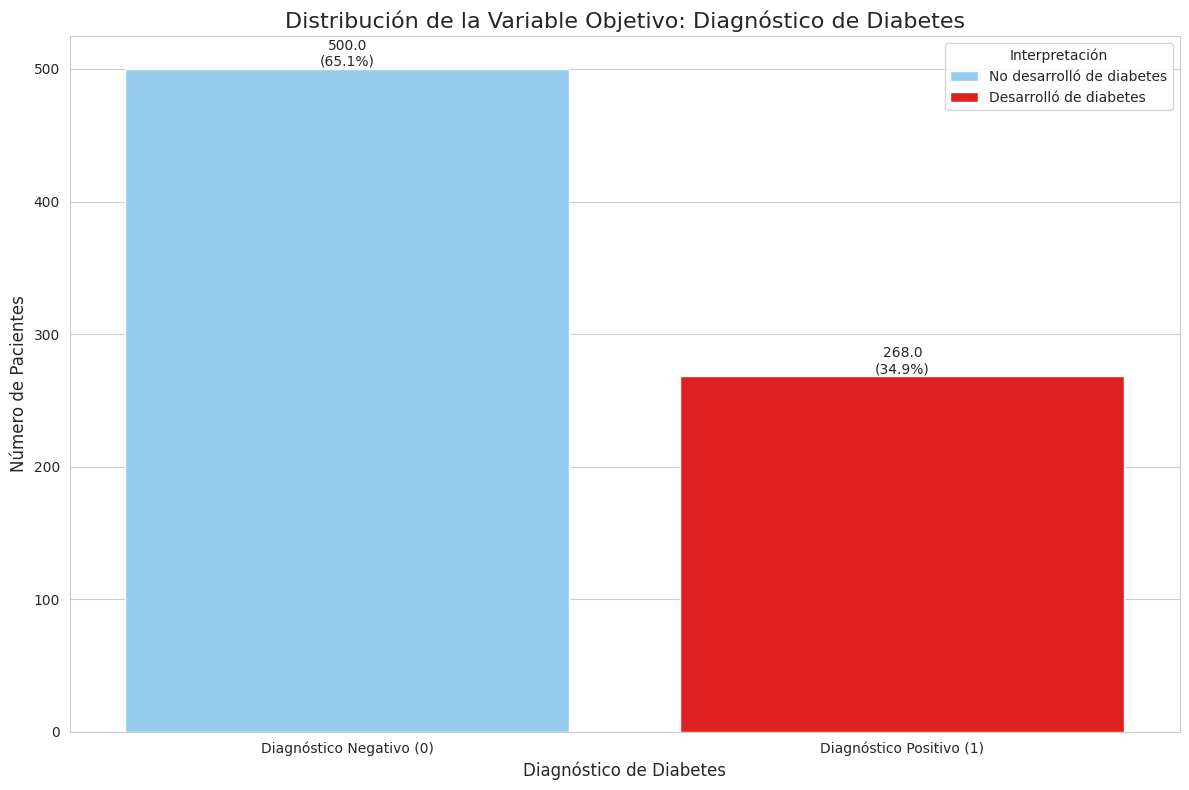

Total de pacientes: 768
Pacientes sin diabetes: 500 (65.1%)
Pacientes con diabetes: 268 (34.9%)


In [ ]:
# Visualización de la variable objetivo Outcome

# Configuración para mejorar la apariencia del gráfico
plt.figure(figsize=(12, 8))
sns.set_style("whitegrid")
colors = ['#87CEFA', '#FF0000']  # Colores para las barras

# Crear el gráfico de barras
ax = sns.countplot(data=df, x='Outcome', palette=colors)

# Añadir etiquetas y título
plt.title('Distribución de la Variable Objetivo: Diagnóstico de Diabetes', fontsize=16)
plt.xlabel('Diagnóstico de Diabetes', fontsize=12)
plt.ylabel('Número de Pacientes', fontsize=12)


# Cambiar las etiquetas del eje x
plt.xticks([0, 1], ['Diagnóstico Negativo (0)', 'Diagnóstico Positivo (1)'], fontsize=10)

# Añadir etiquetas de valor en las barras
total = len(df)
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x() + p.get_width()/2., height + 0.1,
            f'{height}\n({height/total:.1%})',
            ha="center", va="bottom", fontsize=10)

# Añadir una leyenda explicativa
plt.legend(['No desarrolló de diabetes', 'Desarrolló de diabetes'],
           title='Interpretación', loc='upper right', fontsize=10)

# Ajustar el diseño y mostrar el gráfico
plt.tight_layout()
plt.show()

# Imprimir estadísticas adicionales
print(f"Total de pacientes: {total}")
print(f"Pacientes sin diabetes: {df['Outcome'].value_counts()[0]} ({df['Outcome'].value_counts()[0]/total:.1%})")
print(f"Pacientes con diabetes: {df['Outcome'].value_counts()[1]} ({df['Outcome'].value_counts()[1]/total:.1%})")

De la distribución de la variable objetivo que has proporcionado, podemos extraer varias conclusiones importantes:

1. **Desbalance de clases**: Existe un desbalance moderado en el conjunto de datos. La clase mayoritaria (pacientes sin diabetes) representa el 65.1% de los casos, mientras que la clase minoritaria (pacientes con diabetes) representa el 34.9%. Este desbalance de clases, aunque no es extremo, podría afectar el rendimiento de algunos algoritmos de aprendizaje automático. Puede ser necesario considerar técnicas como sobremuestreo de la clase minoritaria (por ejemplo, SMOTE) o submuestreo de la clase mayoritaria durante la fase de preprocesamiento de datos.

2. **Prevalencia de diabetes**: En esta población de estudio, aproximadamente 1 de cada 3 individuos (34.9%) tiene diabetes. Esta es una prevalencia bastante alta en comparación con la población general (5.4%), lo que podría reflejar las características únicas de la población Pima o los criterios de selección del estudio.

3. **Tamaño de la muestra**: Con 768 pacientes en total, tenemos un tamaño de muestra moderado. Esto debería ser suficiente para realizar análisis estadísticos significativos y entrenar modelos de aprendizaje automático, aunque muestras más grandes siempre son preferibles para obtener resultados más robustos.

4. **Relevancia clínica**: La alta proporción de casos positivos (34.9%) subraya la importancia de este estudio para la salud pública, especialmente en poblaciones con alto riesgo de diabetes.

5. **Base para comparaciones**: Esta distribución proporciona una línea base importante para evaluar nuestros modelos predictivos. Un modelo que simplemente predijera siempre la clase mayoritaria (no diabetes) tendría una precisión del 65.1%, lo cual es un punto de referencia útil para evaluar el rendimiento de nuestros modelos más sofisticados.

7. **Generalización de resultados**: Dado el desbalance moderado y la alta prevalencia de diabetes en esta muestra, debemos ser cautelosos al generalizar los resultados a otras poblaciones con diferentes tasas de prevalencia de diabetes.

Estas conclusiones nos ayudarán a guiar nuestro análisis posterior, informar nuestras decisiones de preprocesamiento de datos y establecer expectativas realistas para el rendimiento de nuestros modelos predictivos.


---

# 2.2 Análisis de Variables Cuantitativas

En esta sección, exploraremos las variables numéricas del dataset de diabetes para identificar patrones, tendencias y relaciones significativas que puedan influir en el diagnóstico de diabetes.

Pasos del análisis:

### 1. Visualización de la Distribución de Variables

- Utilizaremos histogramas y boxplots para entender la distribución de cada variable numérica (Pregnancies, Glucose, BloodPressure, SkinThickness, Insulin, BMI, DiabetesPedigreeFunction, Age).
- Esto nos ayudará a identificar asimetrías, curtosis y la presencia de outliers.

### 2. Estadísticas Descriptivas

- Calcularemos medidas como la media, mediana, desviación estándar, y rangos intercuartílicos para cada variable.
- Esto proporcionará un resumen cuantitativo de cada variable y nos ayudará a entender mejor sus características.

### 3. Relación con la Variable Objetivo (Outcome)

- Crearemos scatterplots y pairplots para visualizar cómo cada variable numérica se relaciona con Outcome.
- Buscaremos patrones que puedan indicar asociaciones significativas con el diagnóstico de diabetes.


### 4. Detección de Outliers

- Identificaremos outliers mediante el análisis de boxplots.
- Prestaremos especial atención a los valores 0 en variables como BloodPressure, SkinThickness, Insulin y BMI, que probablemente representen datos faltantes.

### 5. Análisis de Correlación

- Calcularemos la matriz de correlación para identificar relaciones lineales entre variables numéricas.
- Utilizaremos heatmaps para visualizar estas correlaciones y destacar las más fuertes.
- Calcularemos la correlación de nuestras variables numéricas con la variable objetivo 'Outcome'.

Este análisis exhaustivo de las variables cuantitativas nos proporcionará una base sólida para el modelado predictivo de diabetes, permitiéndonos identificar y aprovechar las relaciones clave en el dataset. Además, nos ayudará a abordar los desafíos específicos de este conjunto de datos, como los valores 0 que probablemente representen datos faltantes en algunas variables.


Agrupamos las variables numéricas para trabajar con ellas


In [ ]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB
None


In [ ]:
num_vars = df[['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age']]

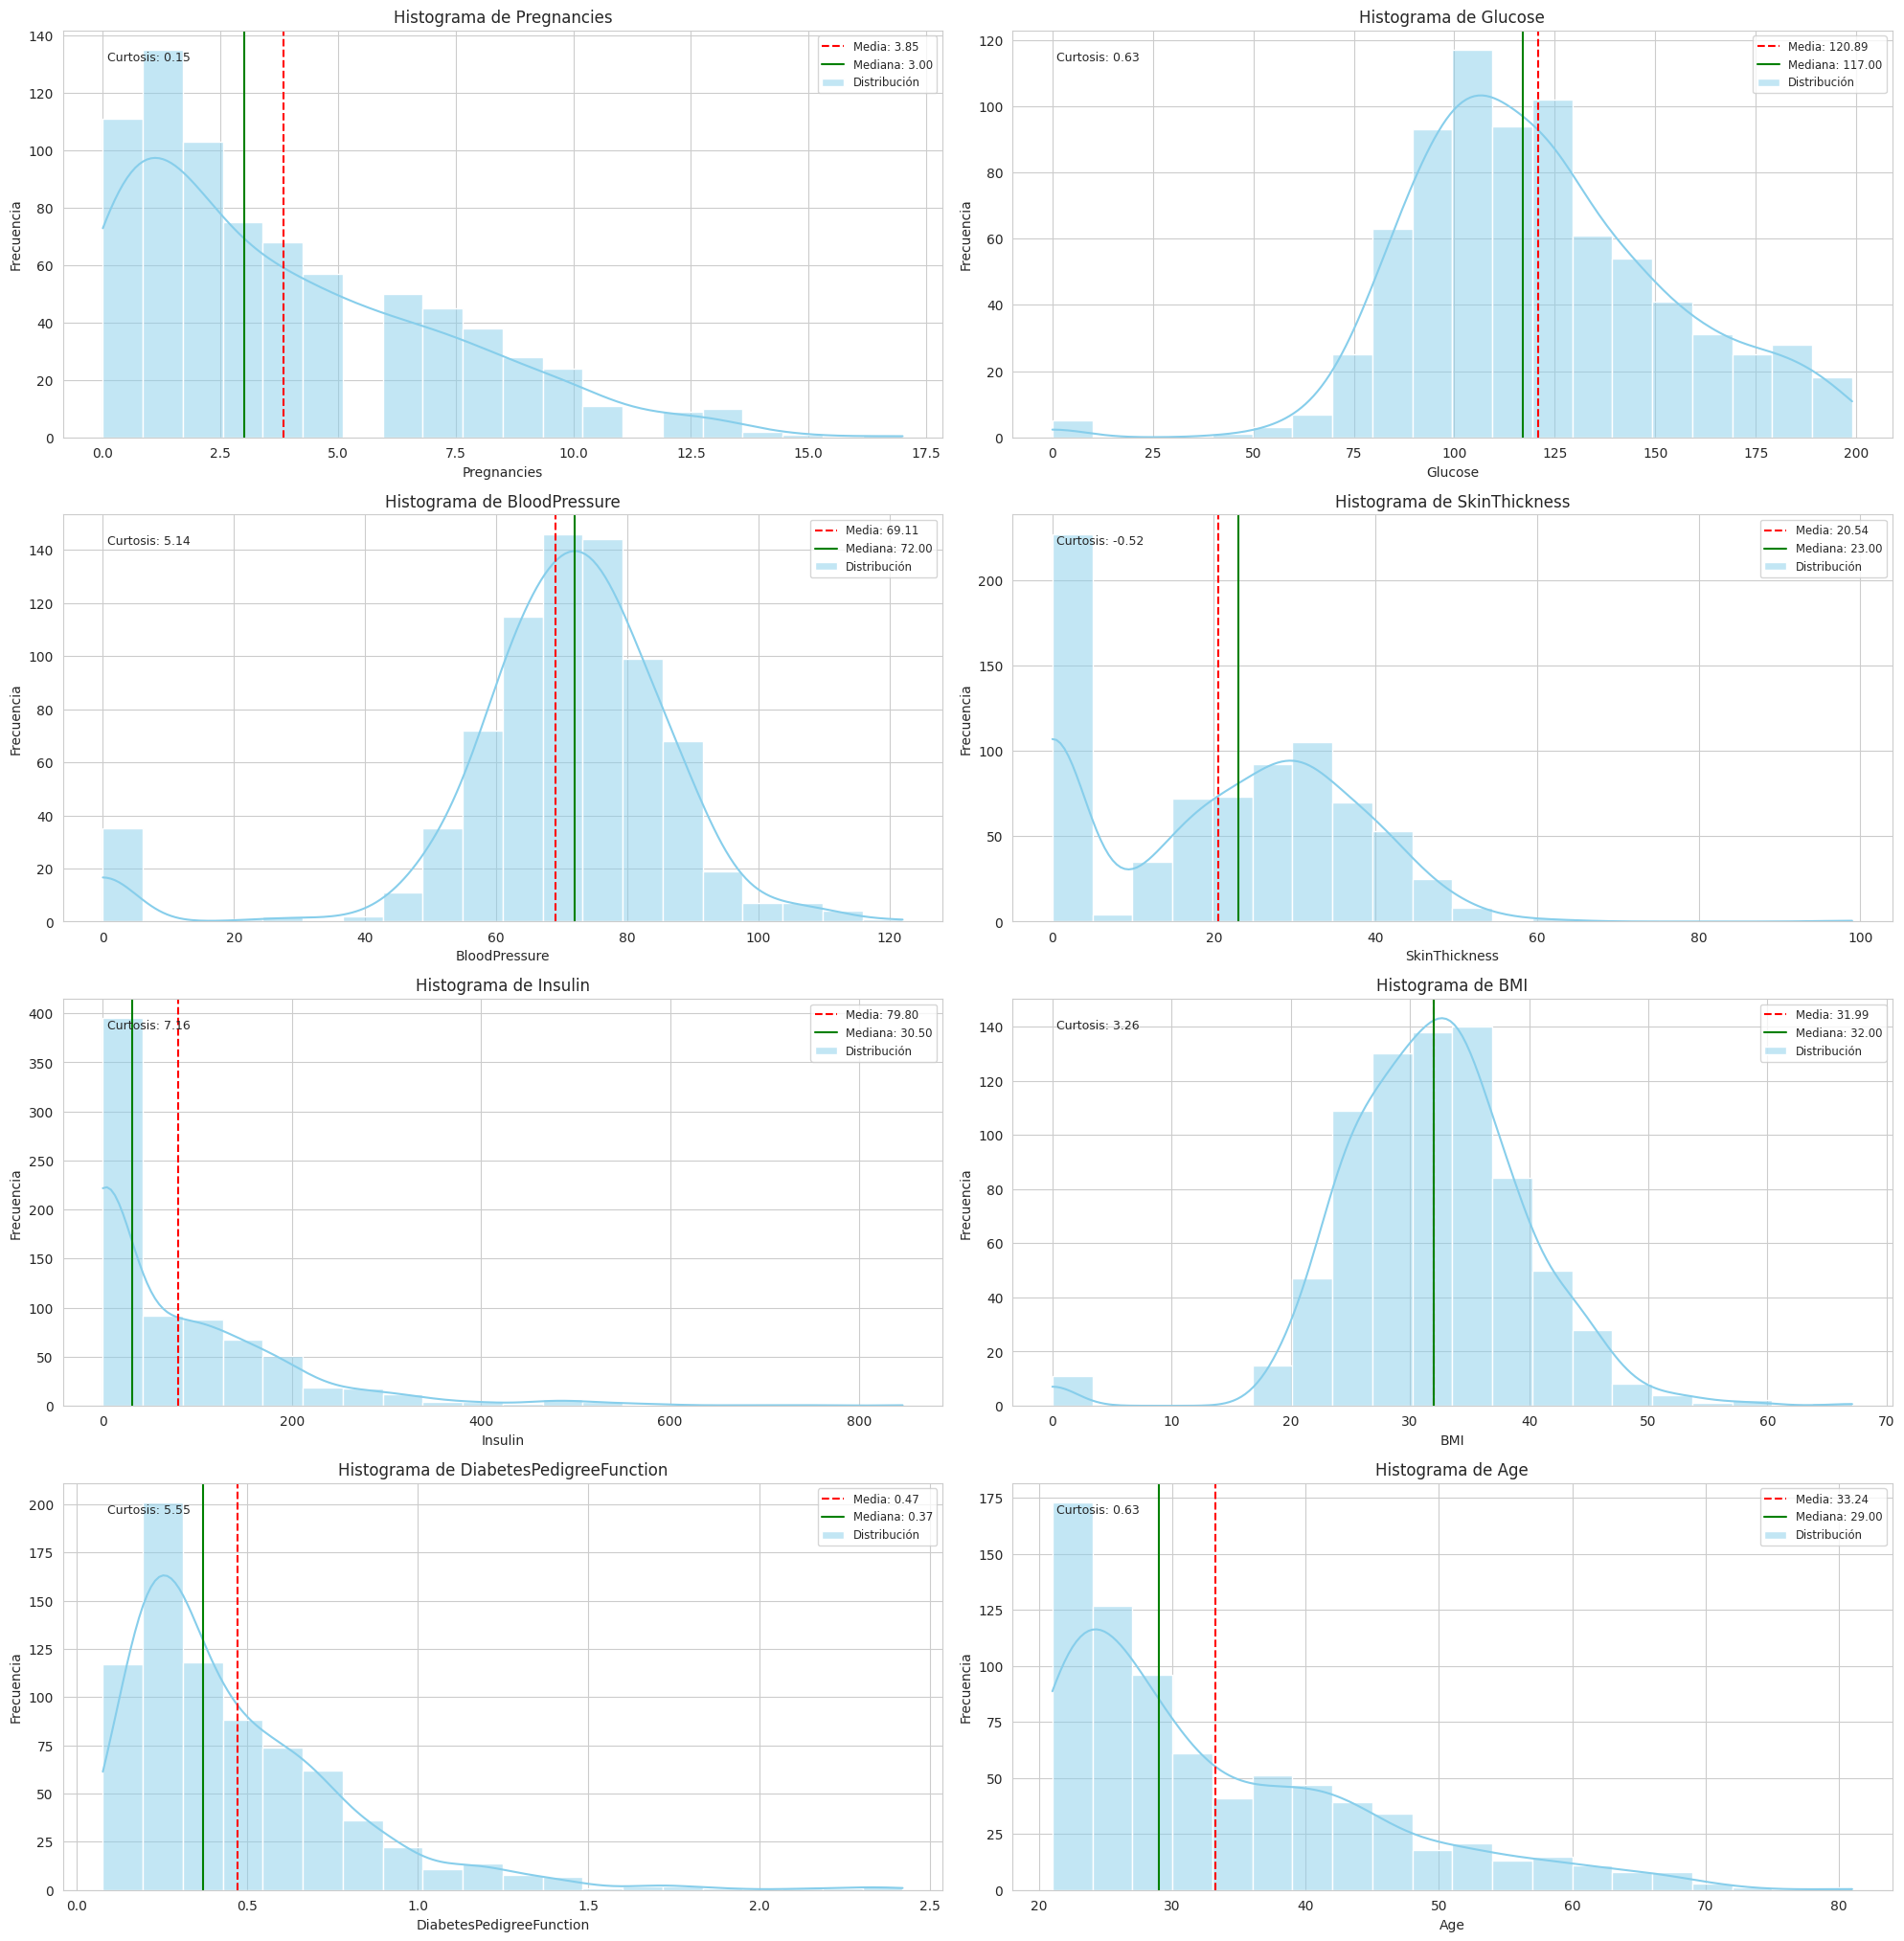

In [ ]:
# Crear histogramas con líneas de media y mediana
plt.figure(figsize=(20, 25))

for i, var in enumerate(num_vars):
    plt.subplot(5, 2, i + 1)
    sns.histplot(df[var], bins=20, kde=True, color='skyblue', label='Distribución')

    # Calcular media y mediana
    mean_val = df[var].mean()
    median_val = df[var].median()
    kurt_val = kurtosis(df[var])

    # Añadir líneas de media y mediana
    plt.axvline(mean_val, color='red', linestyle='--', label=f'Media: {mean_val:.2f}')
    plt.axvline(median_val, color='green', linestyle='-', label=f'Mediana: {median_val:.2f}')

    # Añadir texto de curtosis
    plt.text(0.05, 0.95, f'Curtosis: {kurt_val:.2f}',
             transform=plt.gca().transAxes, fontsize=9,
             verticalalignment='top')

    # Añadir leyenda
    plt.legend(fontsize='small')
    plt.title(f'Histograma de {var}')
    plt.xlabel(var)
    plt.ylabel('Frecuencia')

plt.tight_layout()
plt.show()

In [ ]:
# Calculamos estadísticas descriptivas
descriptive_stats = num_vars.describe().transpose()

# Añadir mediana y rango intercuartílico
descriptive_stats['median'] = num_vars.median()
descriptive_stats['IQR'] = descriptive_stats['75%'] - descriptive_stats['25%']

# Mostrar estadísticas descriptivas
print(descriptive_stats[['mean', 'median', 'std', 'min', '25%', '50%', '75%', 'max', 'IQR']])

                                mean    median         std     min       25%  \
Pregnancies                 3.845052    3.0000    3.369578   0.000   1.00000   
Glucose                   120.894531  117.0000   31.972618   0.000  99.00000   
BloodPressure              69.105469   72.0000   19.355807   0.000  62.00000   
SkinThickness              20.536458   23.0000   15.952218   0.000   0.00000   
Insulin                    79.799479   30.5000  115.244002   0.000   0.00000   
BMI                        31.992578   32.0000    7.884160   0.000  27.30000   
DiabetesPedigreeFunction    0.471876    0.3725    0.331329   0.078   0.24375   
Age                        33.240885   29.0000   11.760232  21.000  24.00000   

                               50%        75%     max       IQR  
Pregnancies                 3.0000    6.00000   17.00    5.0000  
Glucose                   117.0000  140.25000  199.00   41.2500  
BloodPressure              72.0000   80.00000  122.00   18.0000  
SkinThickness  

Basándonos en las estadísticas descriptivas proporcionadas, podemos extraer varias conclusiones importantes sobre las variables numéricas del dataset de diabetes:

1. Pregnancies (Embarazos):
   - La media es de 3.85, con una mediana de 3, indicando una distribución ligeramente sesgada hacia la derecha.
   - El rango va de 0 a 17 embarazos, con un 75% de las mujeres teniendo 6 o menos embarazos.

2. Glucose (Glucosa):
   - La media (120.89) es ligeramente superior a la mediana (117), sugiriendo una distribución levemente sesgada hacia la derecha.
   - El rango va de 0 a 199 mg/dL, con valores de 0 que probablemente indican datos faltantes.
   - El valor máximo (199 mg/dL) supera significativamente el límite superior normal post-comida (140 mg/dL). Esto sugiere que una proporción considerable de la población estudiada presenta niveles elevados de glucosa, indicativo de prediabetes o diabetes.

3. BloodPressure (Presión Arterial):
   - La media (69.11) es menor que la mediana (72), indicando una posible asimetría hacia la izquierda.
   - El valor mínimo de 0 sugiere la presencia de datos faltantes o erróneos.

4. SkinThickness (Grosor del Pliegue Cutáneo):
   - Hay una diferencia notable entre la media (20.54) y la mediana (23), con un mínimo de 0, indicando probables datos faltantes.

5. Insulin (Insulina):
   - Muestra una gran variabilidad, con una desviación estándar (115.24) mayor que la media (79.80).
   - La mediana (30.5) es significativamente menor que la media, indicando una distribución muy sesgada hacia la derecha.
   - El valor máximo (846 mIU/L) es extremadamente alto, sugiriendo casos de resistencia a la insulina severa o errores en los datos.

6. BMI (Índice de Masa Corporal):
   - La media (31.99) y la mediana (32) son similares, sugiriendo una distribución más simétrica.
   - El rango va de 0 a 67.1, con valores de 0 que probablemente indican datos faltantes. El valor máximo (67.1 kg/m²) indica casos de obesidad extrema. Esto sugiere que una gran parte de la población estudiada tiene sobrepeso u obesidad, factores de riesgo conocidos para la diabetes tipo 2.

7. DiabetesPedigreeFunction:
   - Tiene un rango de 0.078 a 2.42, con una media de 0.472 y una mediana de 0.3725.
   - La distribución parece estar sesgada hacia la derecha, con algunos valores altos influyendo en la media.

8. Age (Edad):
   - La media (33.24) es mayor que la mediana (29), indicando una distribución sesgada hacia la derecha.
   - El rango va de 21 a 81 años, con el 75% de los pacientes teniendo 41 años o menos.

Conclusiones generales:
- Varias variables (Glucose, BloodPressure, SkinThickness, Insulin, BMI) tienen valores mínimos de 0, lo que probablemente indica datos faltantes que necesitarán ser tratados.
- La mayoría de las variables muestran algún grado de asimetría en su distribución.
- Hay una gran variabilidad en algunas medidas, especialmente en Insulin y DiabetesPedigreeFunction, lo que podría influir en los modelos predictivos.
- La edad de la población de estudio es relativamente joven, con una concentración en el rango de 20 a 40 años.
- El dataset muestra una población con características de alto riesgo para diabetes tipo 2, incluyendo niveles elevados de glucosa, insulina y BMI. La presión arterial, sin embargo, parece estar dentro de rangos más normales. Estos hallazgos son consistentes con una población en riesgo de desarrollar o ya diagnosticada con diabetes tipo 2.




Para visualizar cómo cada variable numérica se relaciona con Outcome, vamos a usar scatterplots y pairplots.

- Scatterplots: Muestran la relación directa entre cada variable numérica y Outcome.
- Pairplots: Ofrecen una visión más completa de las relaciones entre múltiples variables numéricas, coloreadas por Outcome.

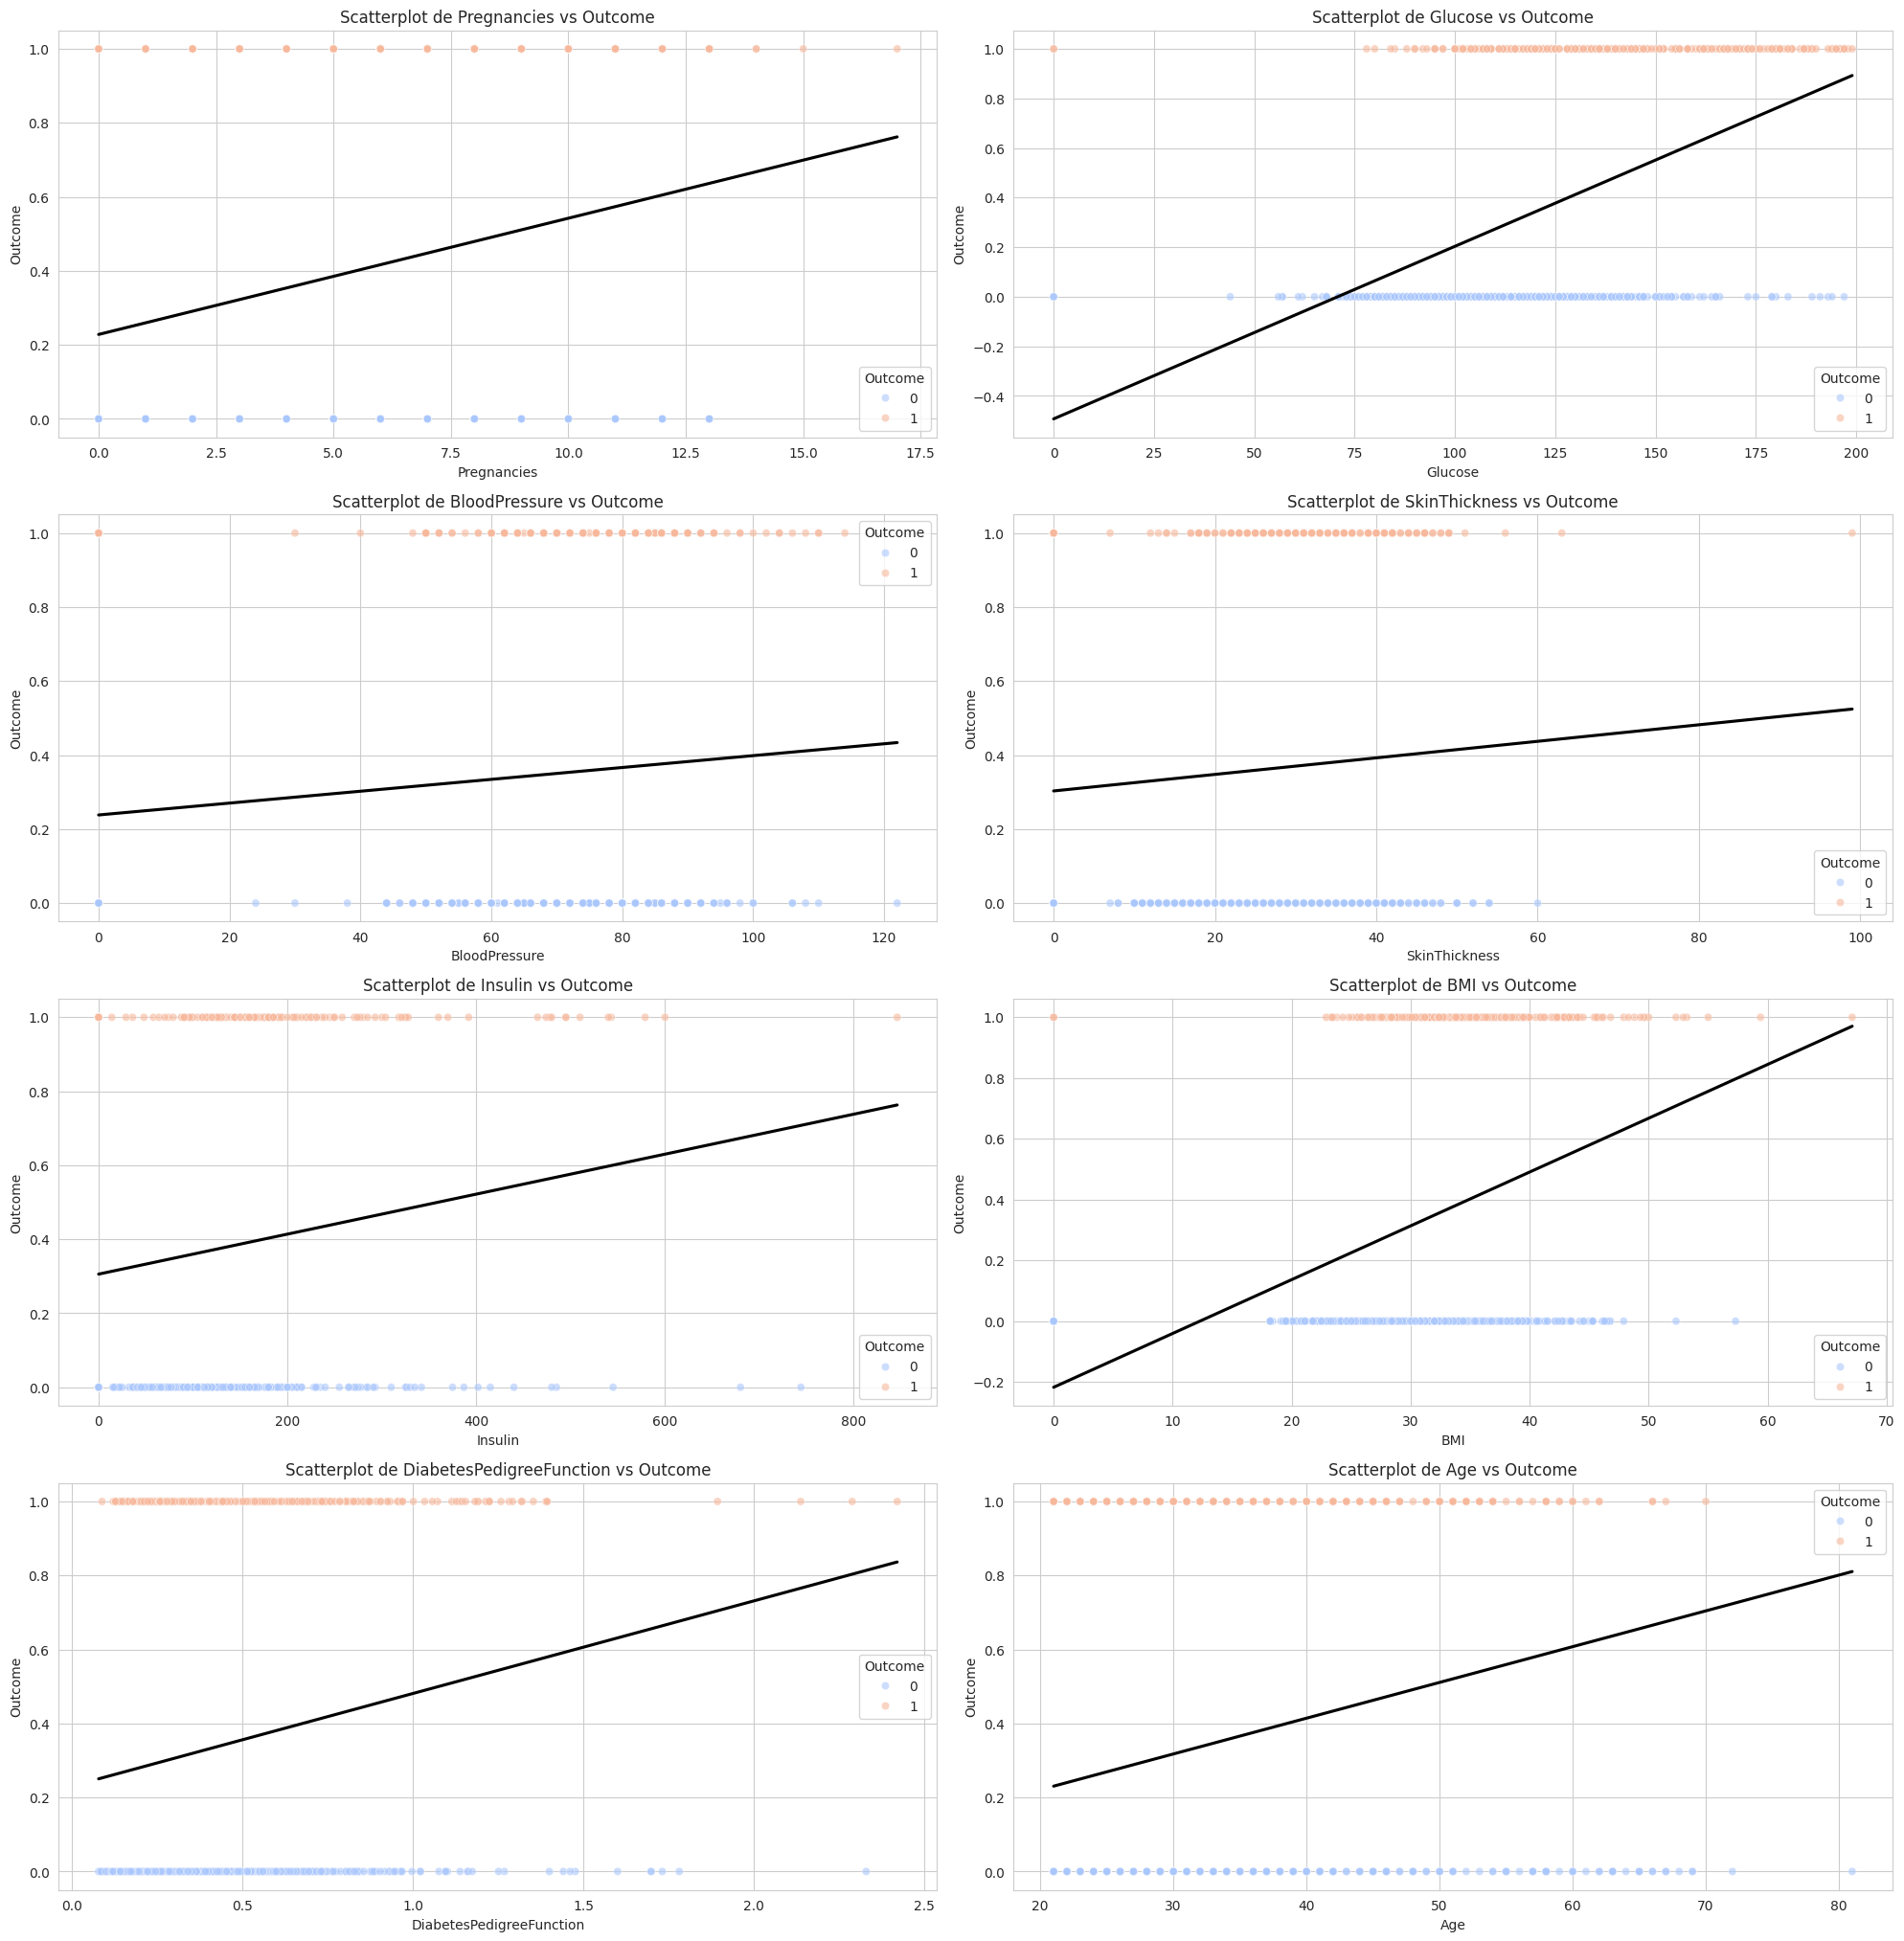

In [ ]:
# Crear scatterplots con colores para la variable objetivo y línea de regresión

# Tamaño de la figura
plt.figure(figsize=(20, 25))

for i, var in enumerate(num_vars):
    plt.subplot(5, 2, i + 1)
    sns.scatterplot(x=df[var], y=df['Outcome'], hue=df['Outcome'], palette='coolwarm', alpha=0.6)
    sns.regplot(x=df[var], y=df['Outcome'], scatter=False, color='black', ci=None)
    plt.title(f'Scatterplot de {var} vs Outcome')
    plt.xlabel(var)
    plt.ylabel('Outcome')

plt.tight_layout()
plt.show()

### 1. **Pregnancies vs. Outcome**
   - Existe una ligera tendencia positiva: a mayor número de embarazos, parece haber una mayor probabilidad de tener diabetes.
   - Esto es consistente con investigaciones que indican que múltiples embarazos pueden estar relacionados con un mayor riesgo de diabetes gestacional y tipo 2.

### 2. **Glucose vs. Outcome**
   - La relación es clara: los valores más altos de glucosa están asociados con una mayor probabilidad de tener diabetes.
   - Este resultado es esperado, ya que niveles elevados de glucosa son un indicador directo de diabetes.

### 3. **BloodPressure vs. Outcome**
   - La relación entre presión arterial y diagnóstico de diabetes parece ser débil o inexistente.
   - Aunque la presión arterial elevada puede ser un factor de riesgo cardiovascular, su conexión directa con la diabetes no es tan evidente en este dataset.

### 4. **SkinThickness vs. Outcome**
   - Hay una ligera tendencia positiva: mayores valores de grosor del pliegue cutáneo están asociados con una mayor probabilidad de tener diabetes.
   - Esto podría reflejar una relación indirecta a través del IMC o la obesidad.

### 5. **Insulin vs. Outcome**
   - Se observa una tendencia positiva: niveles más altos de insulina están asociados con un mayor riesgo de diabetes.
   - Esto es consistente con la resistencia a la insulina, que es un precursor común de la diabetes tipo 2.

### 6. **BMI vs. Outcome**
   - Existe una relación positiva clara: valores más altos del índice de masa corporal (IMC) están asociados con un mayor riesgo de diabetes.
   - Esto subraya el papel importante del sobrepeso y la obesidad como factores de riesgo para la diabetes tipo 2.

### 7. **DiabetesPedigreeFunction vs. Outcome**
   - Se observa una tendencia positiva: valores más altos en esta función (indicando un historial familiar más fuerte) están asociados con un mayor riesgo de diabetes.
   - Esto refuerza el impacto del componente genético en el desarrollo de la enfermedad.

### 8. **Age vs. Outcome**
   - Existe una relación positiva: a mayor edad, aumenta la probabilidad de tener diabetes.
   - Esto es consistente con el hecho conocido de que el riesgo de diabetes tipo 2 aumenta con la edad.

---

### Conclusión General:
- Las variables **Glucose**, **BMI**, y **DiabetesPedigreeFunction** muestran relaciones claras y fuertes con el diagnóstico de diabetes, lo que las podría  convertir en predictores importantes.
- Variables como **Pregnancies**, **Insulin**, y **Age** también tienen una relación positiva significativa, aunque menos marcada.
- Variables como **BloodPressure** y, en menor medida, **SkinThickness**, parecen tener relaciones más débiles o indirectas con el diagnóstico.

Estos patrones serán útiles para priorizar variables en el modelado predictivo y para entender los factores clave asociados al diagnóstico de diabetes en esta población.


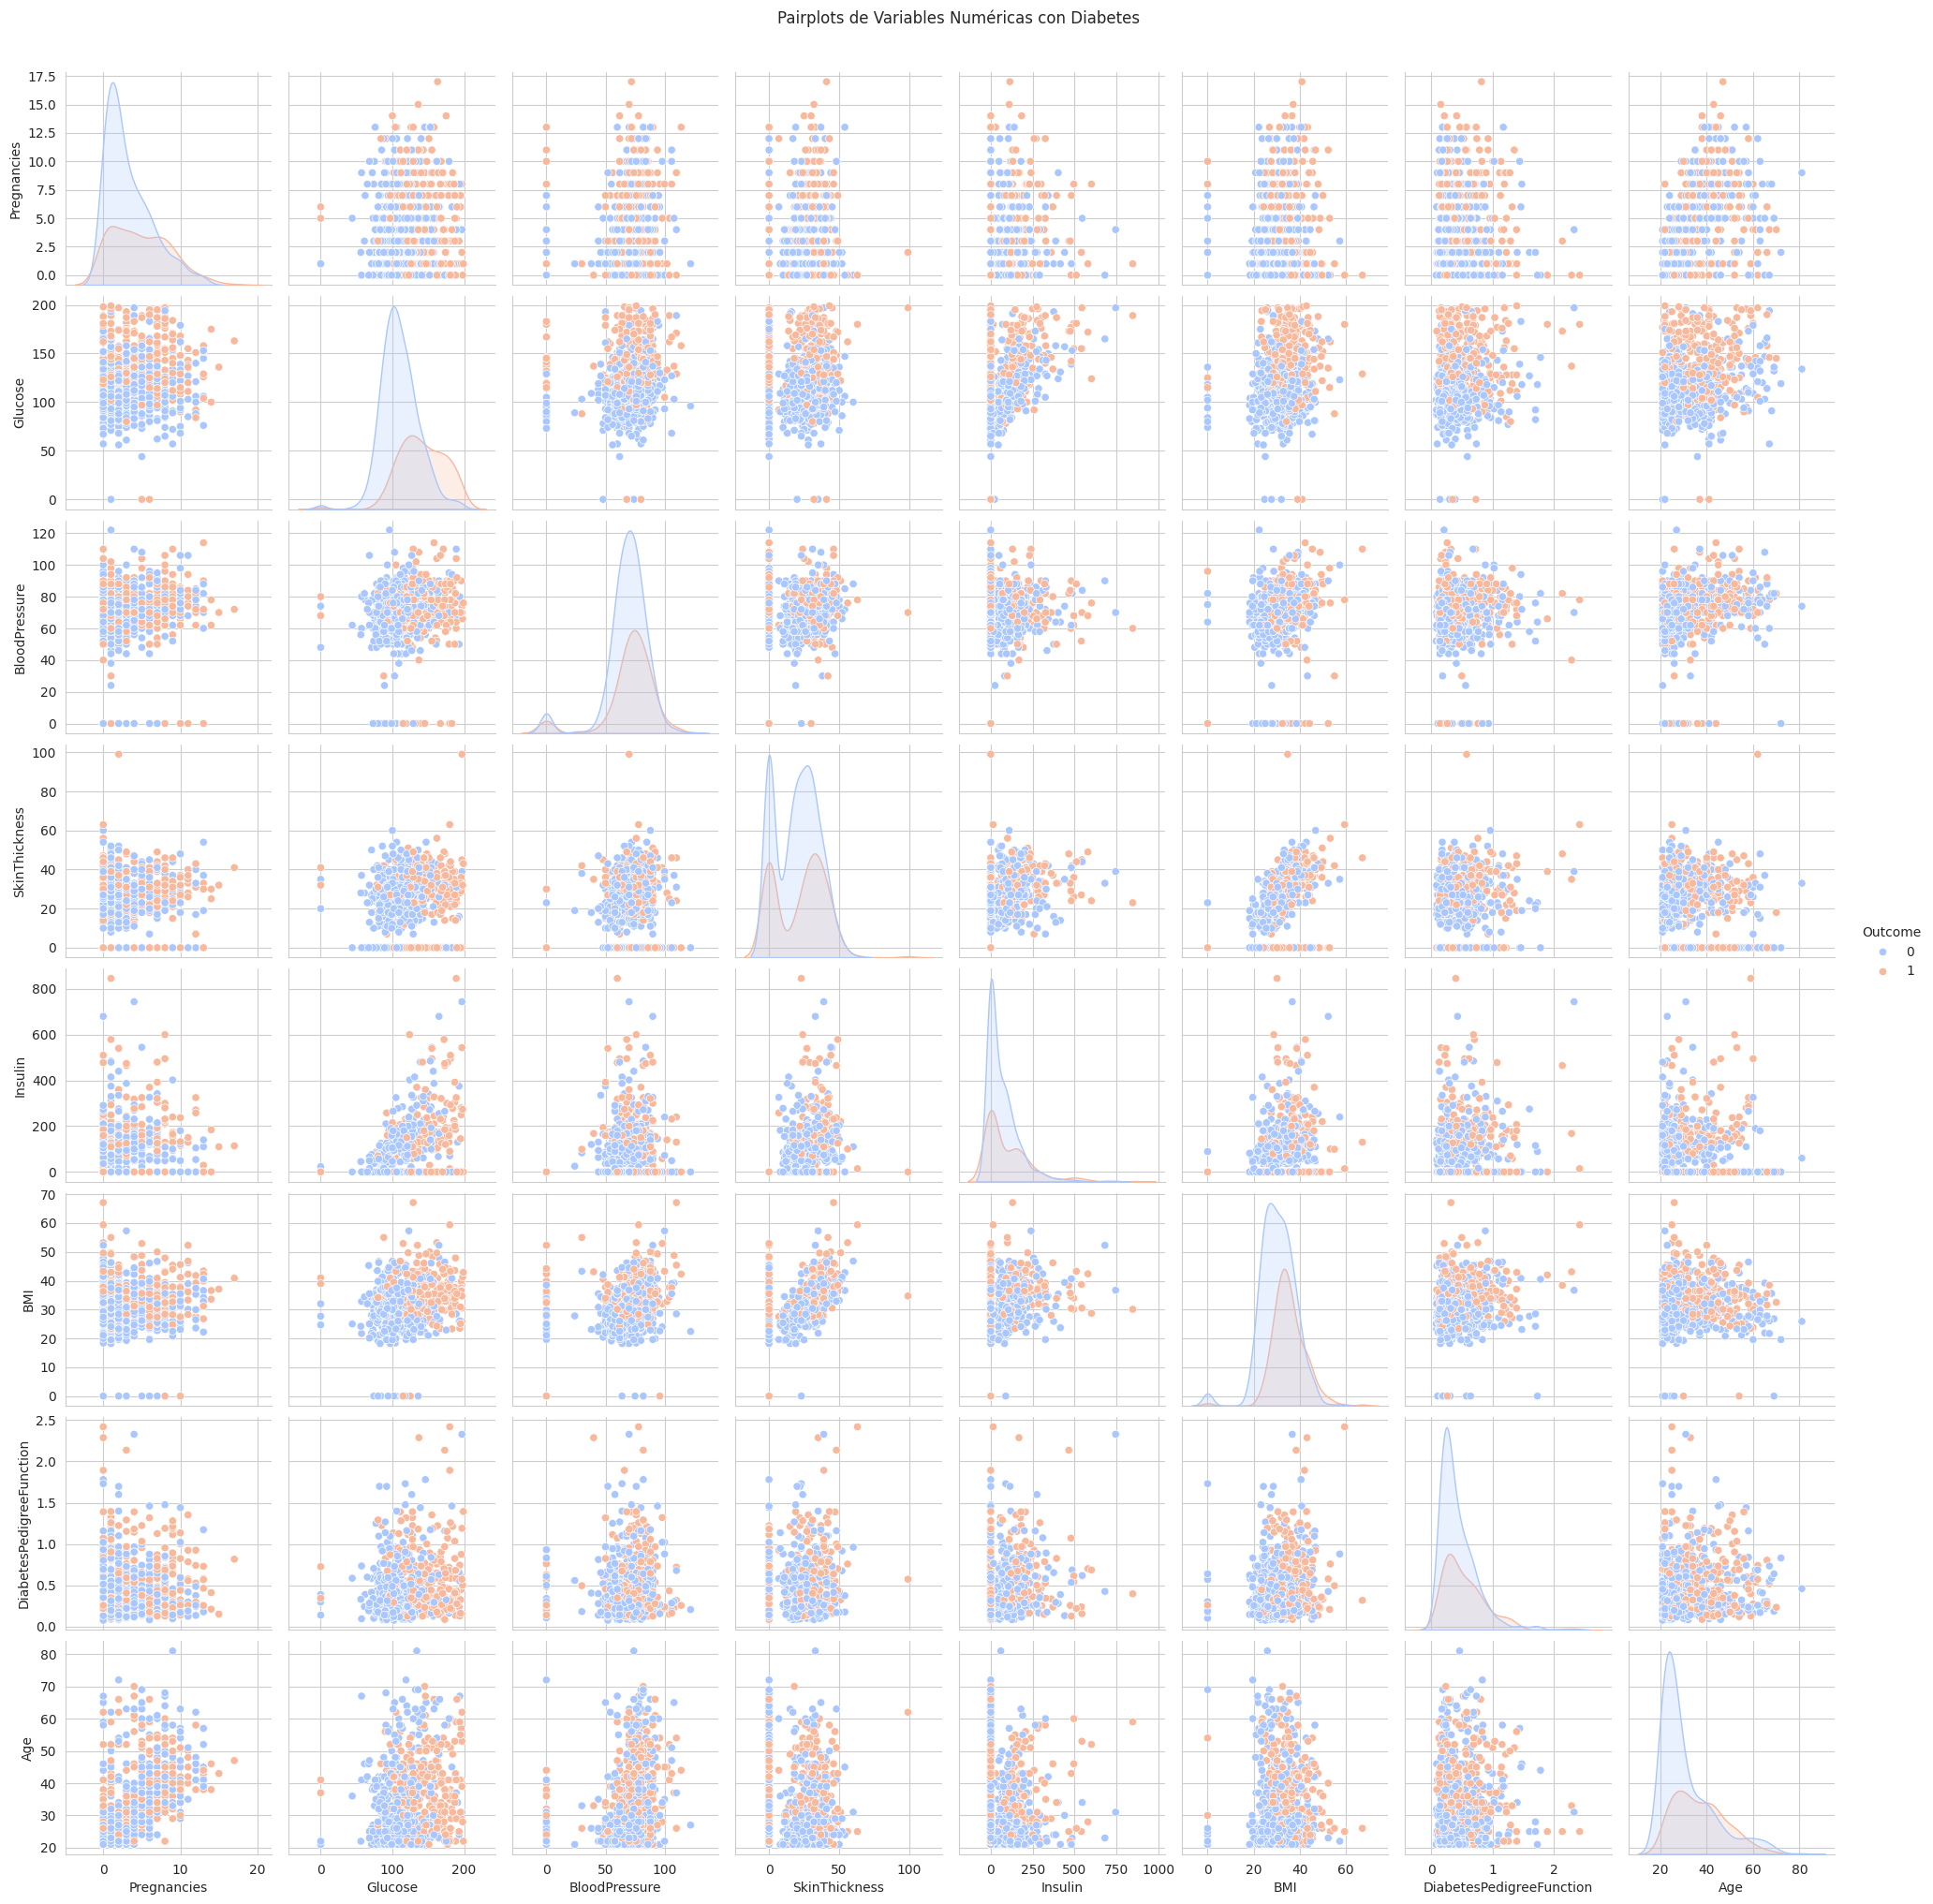

In [ ]:
# Crear pairplot para visualizar relaciones entre variables numéricas y Outcome
sns.pairplot(df, vars=num_vars, hue='Outcome', diag_kind='kde', palette='coolwarm')
plt.suptitle('Pairplots de Variables Numéricas con Diabetes', y=1.02)
plt.show()

### 1. **Distribuciones Univariadas**
   - Las distribuciones de las variables **Glucose**, **BMI**, y **DiabetesPedigreeFunction** muestran diferencias claras entre los pacientes con diabetes (Outcome = 1) y sin diabetes (Outcome = 0).
     - Por ejemplo, los pacientes diabéticos tienden a tener valores más altos en estas variables.
   - Variables como **BloodPressure** y **SkinThickness** tienen distribuciones más solapadas entre ambos grupos, lo que sugiere que estas variables podrían tener un menor poder predictivo.

### 2. **Relaciones entre Variables**
   - **Glucose y BMI**: Existe una correlación positiva moderada entre estas dos variables. Esto tiene sentido, ya que el sobrepeso u obesidad (reflejado en un BMI alto) está relacionado con la resistencia a la insulina y niveles elevados de glucosa.
   - **Age y Pregnancies**: Hay una relación positiva esperada, ya que las mujeres mayores tienden a haber tenido más embarazos.
   - **Insulin y Glucose**: Se observa una relación positiva, consistente con el hecho de que niveles altos de glucosa suelen ir acompañados de niveles elevados de insulina en personas con resistencia a la insulina.

### 3. **Solapamiento entre Grupos**
   - En muchas combinaciones de variables (por ejemplo, **BloodPressure vs. SkinThickness** o **Age vs. BloodPressure**), los puntos correspondientes a Outcome = 0 (azul) y Outcome = 1 (naranja) están muy mezclados. Esto indica que estas combinaciones no separan bien a los pacientes diabéticos de los no diabéticos.
   - En contraste, combinaciones como **Glucose vs. BMI** o **Glucose vs. DiabetesPedigreeFunction** muestran una separación más clara entre ambos grupos.

### 4. **Outliers**
   - El pairplot confirma la presencia de valores extremos en variables como **Insulin**, donde algunos puntos están muy alejados del resto, especialmente en el eje horizontal.
   - También se observan posibles outliers en variables como **SkinThickness** y **BMI**, aunque estos son menos extremos.

### 5. **Interacción entre DiabetesPedigreeFunction y Otras Variables**
   - La variable **DiabetesPedigreeFunction**, aunque no correlaciona fuertemente con otras variables numéricas, muestra una clara diferencia en sus valores para pacientes diabéticos frente a no diabéticos.

---

### Conclusión General:
El pairplot refuerza algunas observaciones previas, como la importancia de variables como **Glucose**, **BMI**, y **DiabetesPedigreeFunction** para predecir diabetes. Sin embargo, también destaca nuevas relaciones entre variables (como Glucose y BMI o Insulin y Glucose) que podrían ser útiles para el modelado. Además, confirma que ciertas variables (como BloodPressure o SkinThickness) tienen menor capacidad para discriminar entre pacientes diabéticos y no diabéticos cuando se analizan individualmente o en combinación con otras.



**ANÁLISIS DE CORRELACIÓN:**

**Ahora calcularemos la matriz de correlación y la representaremos con un heatmap:**
Esto nos ayudará a identificar rápidamente las relaciones lineales más fuertes entre las variables numéricas.

**Calcularemos la correación de las variables numéricas con la variable objetivo**

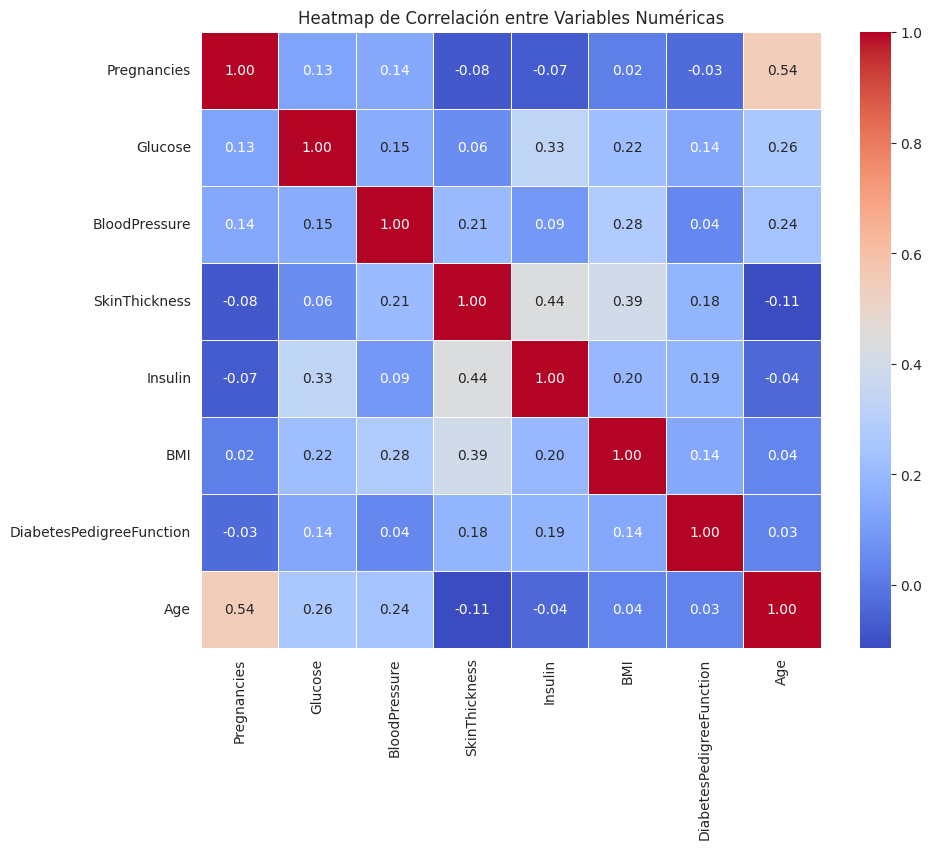

In [ ]:
# Calcular la matriz de correlación
correlation_matrix = num_vars.corr()

# Crear un heatmap para visualizar la matriz de correlación
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Heatmap de Correlación entre Variables Numéricas')
plt.show()

El heatmap de correlación revela que **Pregnancies** y **Age** tienen una correlación moderada (0.54), lo que es esperable ya que las mujeres mayores tienden a tener más embarazos. También se observa una relación positiva entre **SkinThickness** e **Insulin** (0.44), probablemente vinculada a la obesidad o resistencia a la insulina. Variables como **Glucose** e **Insulin** (0.33) y **BMI** con **SkinThickness** (0.39) muestran correlaciones moderadas, reflejando relaciones fisiológicas conocidas. Sin embargo, la mayoría de las demás correlaciones son débiles, lo que sugiere que cada variable aporta información única al modelo predictivo. Este análisis destaca combinaciones clave como **Glucose e Insulin** para entender mejor los factores asociados al diagnóstico de diabetes.


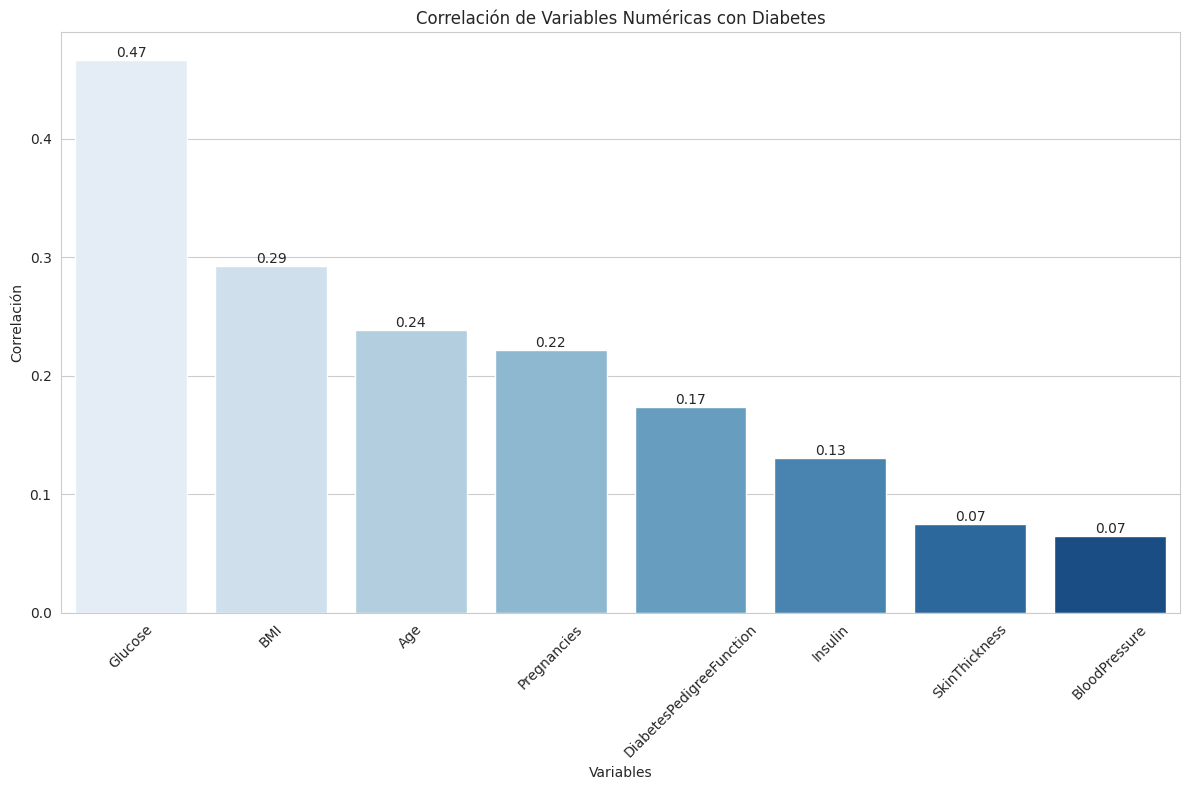

In [ ]:
# Calcular correlaciones con Outcome
correlations = df.corr()['Outcome'].drop('Outcome')

# Ordenar de forma descendente
correlations_sorted = correlations.sort_values(ascending=False)

# Crear barplot
plt.figure(figsize=(12, 8))
sns.barplot(x=correlations_sorted.index, y=correlations_sorted.values, palette='Blues')

# Añadir etiquetas a las barras
for index, value in enumerate(correlations_sorted.values):
    plt.text(index, value, f'{value:.2f}', ha='center', va='bottom')

plt.title('Correlación de Variables Numéricas con Diabetes')
plt.xlabel('Variables')
plt.ylabel('Correlación')
plt.xticks(rotation=45)  # Rotar etiquetas para que no se superpongan
plt.tight_layout()  # Ajustar el diseño para evitar recortes
plt.show()

- Glucose es la variable con la correlación más alta (0.47) con el diagnóstico de diabetes, lo que confirma que los niveles de glucosa son un predictor clave de la enfermedad.

- BMI (Índice de Masa Corporal) tiene una correlación moderada (0.29), destacando el impacto del sobrepeso y la obesidad en el riesgo de diabetes.

- Age (0.24) y Pregnancies (0.22) también muestran correlaciones moderadas, lo que indica que la edad y el número de embarazos tienen una relación significativa, aunque menos fuerte, con el diagnóstico.

- DiabetesPedigreeFunction tiene una correlación baja (0.17), pero sigue siendo relevante al reflejar el historial familiar como un factor de riesgo.

- Insulin, SkinThickness, y BloodPressure tienen correlaciones muy bajas (< 0.13), lo que sugiere que estas variables tienen menor impacto directo en el diagnóstico de diabetes en este dataset.

- En general, las variables más relevantes para predecir diabetes en este dataset son Glucose, BMI, y en menor medida, Age y Pregnancies, mientras que otras variables parecen tener un papel menos significativo.

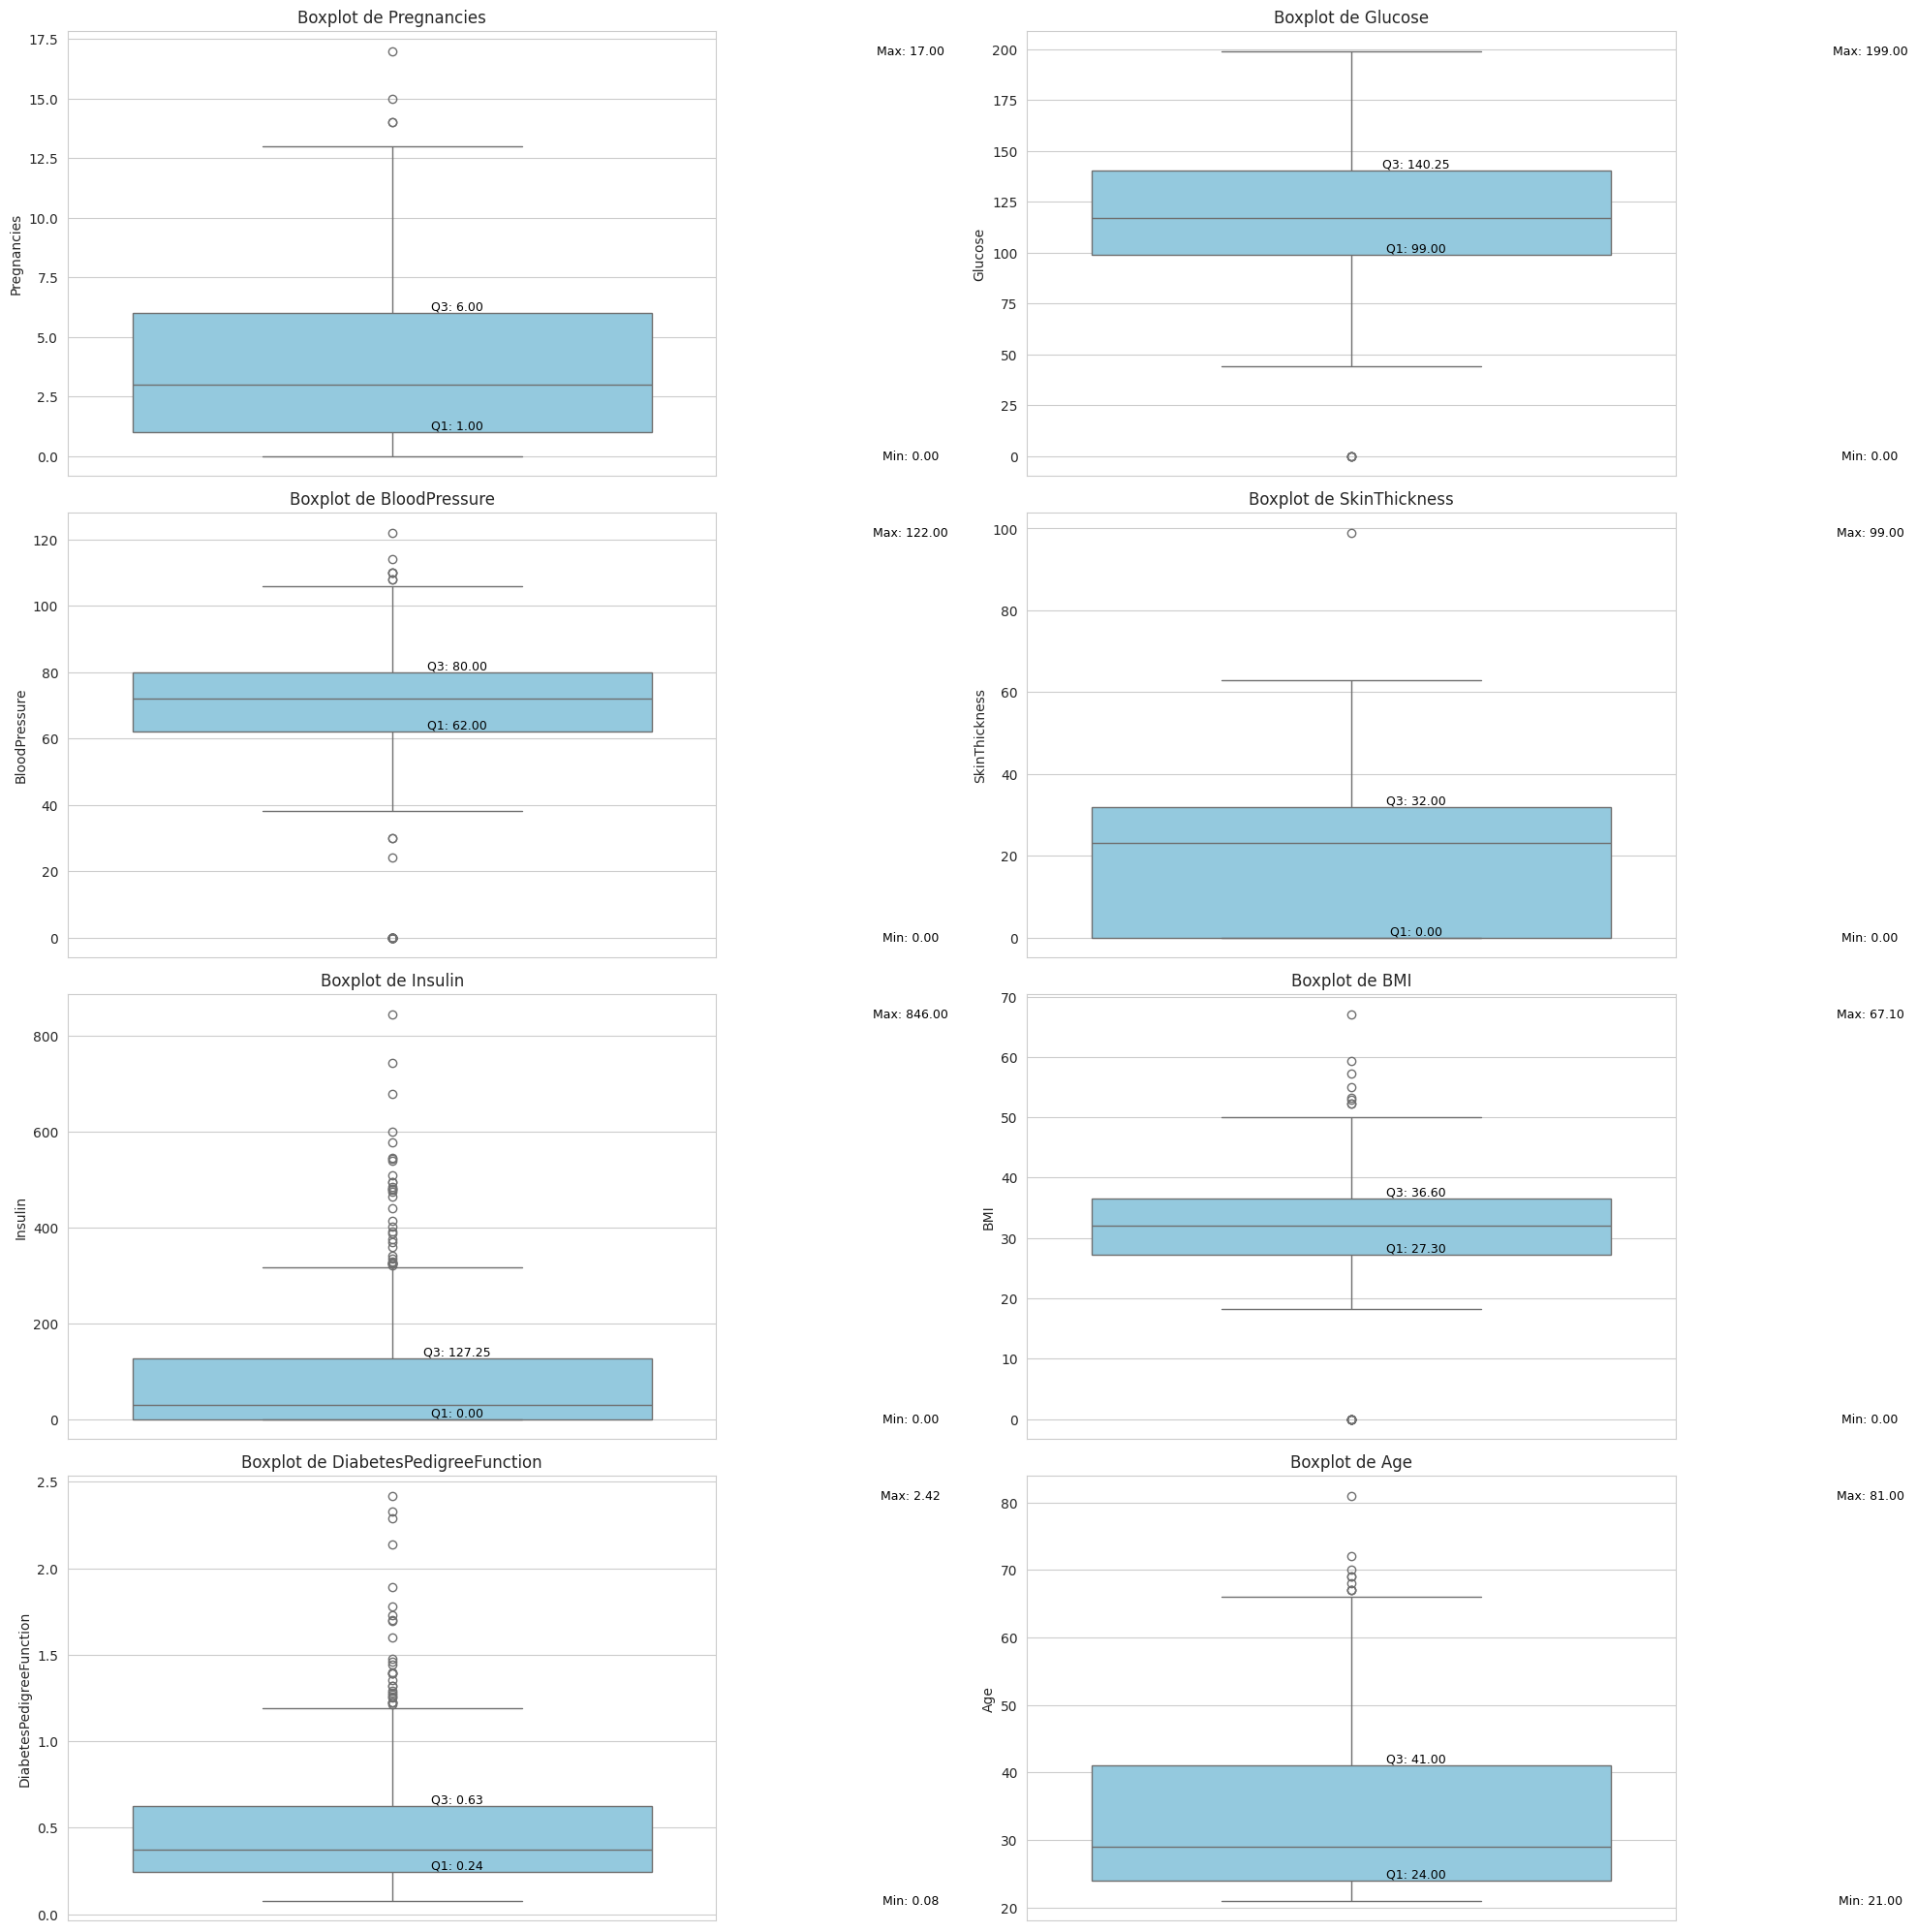

In [ ]:
# Crear boxplots para cada variable con anotaciones
plt.figure(figsize=(20, 25))

for i, var in enumerate(num_vars.columns):
    plt.subplot(5, 2, i + 1)
    sns.boxplot(y=df[var], color='skyblue')
    plt.title(f'Boxplot de {var}')

    # Calcular estadísticas
    stats = df[var].describe()
    q1, q2, q3 = stats['25%'], stats['50%'], stats['75%']
    min_val, max_val = stats['min'], stats['max']

    # Anotar estadísticas al lado del gráfico
    plt.text(0.8, min_val, f'Min: {min_val:.2f}', horizontalalignment='center', verticalalignment='center', fontsize=9, color='black')
    plt.text(0.8, max_val, f'Max: {max_val:.2f}', horizontalalignment='center', verticalalignment='center', fontsize=9, color='black')

    # Anotar estadísticas sobre el gráfico
    plt.text(0.1, q1, f'Q1: {q1:.2f}', horizontalalignment='center', verticalalignment='bottom', fontsize=9, color='black')
    plt.text(0.1, q3, f'Q3: {q3:.2f}', horizontalalignment='center', verticalalignment='bottom', fontsize=9, color='black')

plt.tight_layout()
plt.show()

- Pregnancies:
Hay valores atípicos por encima de 13 embarazos, lo cual es poco común pero posible en casos extremos.

- Glucose:
Existen pocos outliers por debajo del primer cuartil (Q1), lo que sugiere niveles de glucosa inusualmente bajos.

- BloodPressure:
Existen valores atípicos bajos, incluyendo valores de 0, que son fisiológicamente imposibles y probablemente representan datos faltantes.

- SkinThickness:
Hay outliers altos, pero también se observan valores de 0, lo cual indica datos faltantes en esta variable.

- Insulin:
Presenta numerosos outliers altos, con valores que superan los 400, lo que podría reflejar resistencia a la insulina extrema o errores en los datos.
También hay valores de 0, indicando datos faltantes.

- BMI:
Existen outliers altos, especialmente por encima de 50, lo que representa casos de obesidad extrema.

- DiabetesPedigreeFunction:
Se observan algunos outliers altos por encima de 1.5, lo que sugiere un historial familiar excepcionalmente fuerte de diabetes.

- Age:
Hay algunos outliers altos por encima de los 70 años, aunque estos son menos significativos y representan casos esperables en una población mayor.

---

# 3. PREPROCESADO DE DATOS

## COMENZAMOS CON LA LIMPIEZA DE DATOS:

Tratamiento de Valores Faltantes: Podemos eliminarlos o rellenados con un valor específico.

Tratamiento de Outliers: Identificaremos y trataremos valores atípicos que pueden sesgar el modelo.

In [ ]:
print(df.isnull().sum())

Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64


In [ ]:
# Contar valores iguales a 0 por columna
missing_values = (num_vars == 0).sum()
print(missing_values)


missing_percentage = missing_values / len(df) * 100
print(missing_percentage)

# Determinar el umbral del 5%
threshold = 5

# Decidir qué hacer con las variables
for var in num_vars.columns:
    if missing_percentage[var] > threshold:
        print(f"La variable {var} supera el umbral del 5% de valores faltantes.")


Pregnancies                 111
Glucose                       5
BloodPressure                35
SkinThickness               227
Insulin                     374
BMI                          11
DiabetesPedigreeFunction      0
Age                           0
dtype: int64
Pregnancies                 14.453125
Glucose                      0.651042
BloodPressure                4.557292
SkinThickness               29.557292
Insulin                     48.697917
BMI                          1.432292
DiabetesPedigreeFunction     0.000000
Age                          0.000000
dtype: float64
La variable Pregnancies supera el umbral del 5% de valores faltantes.
La variable SkinThickness supera el umbral del 5% de valores faltantes.
La variable Insulin supera el umbral del 5% de valores faltantes.


A pesar de que 'SkinThickness' y 'Insulin' superan nuestro threshold, siguen siendo variables relevante en el contexto de salud.

La insulina es un marcador crucial en la evaluación del riesgo de diabetes y otras enfermedades metabólicas. Su papel principal es regular los niveles de glucosa en sangre, permitiendo que las células utilicen la glucosa como fuente de energía. La resistencia a la insulina o la insuficiencia de esta hormona puede conducir a condiciones graves como diabetes tipo 2, complicaciones cardiovasculares y daño renal.

La grosura de la piel es un indicador importante tanto en el diagnóstico como en el monitoreo de condiciones fisiológicas y patológicas. En el contexto médico, se utiliza para evaluar cambios relacionados con enfermedades metabólicas, envejecimiento, cicatrización y otras afecciones cutáneas. Además, su medición puede ser relevante para terapias transdérmicas, como la administración de insulina en pacientes diabéticos. Los valores anómalos en el grosor de la piel pueden reflejar alteraciones metabólicas o estructurales que requieren atención clínica.

Por ello vamos a imputar los valores faltantes en ellas también. Utilizaremos un mapa de calor para visualizar los patrones de valores faltantes en el dataset. Esto ayudará a identificar si los valores faltantes están relacionados con otras variables. Nos permitirá seleccionar mejor el metodo de imputación.

<Axes: >

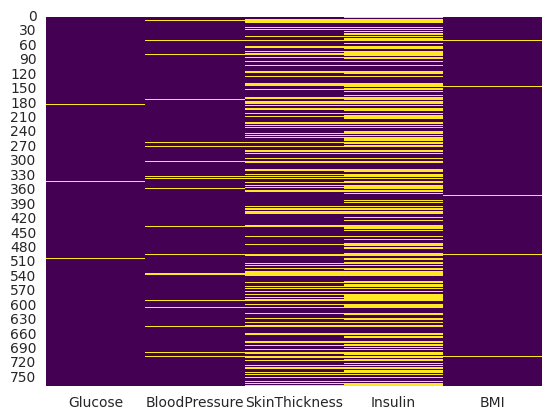

In [ ]:
cero_vars = df[['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']] == 0

# Analizar patrones de valores faltantes
sns.heatmap(cero_vars, cbar=False, cmap='viridis')

El mapa de calor sugiere que existe una relación entre los valores faltantes en las variables SkinThickness e Insulin. Esto podría indicar un problema compartido en la medición o recolección de datos para estas variables. Antes de imputar los valores, sería útil investigar si esta correlación tiene una base lógica o si se debe a errores sistemáticos. Además, las técnicas de imputación deberían considerar estas relaciones para preservar la coherencia del dataset.


- Verificaremos la correlación entre las variables Insulin y SkinThickness (sin valores faltantes)

- Analizaremos patrones de valores faltantes:
Para ver si los valores faltantes (ceros) en Insulin y SkinThickness ocurren simultáneamente con más frecuencia de lo esperado.

In [ ]:
# Filtrar filas donde Insulin y SkinThickness no sean 0
valid_data = df[(df['Insulin'] != 0) & (df['SkinThickness'] != 0)]

# Calcular la correlación entre Insulin y SkinThickness
correlation = valid_data[['Insulin', 'SkinThickness']].corr()
print(correlation)


                Insulin  SkinThickness
Insulin        1.000000       0.184888
SkinThickness  0.184888       1.000000


In [ ]:
# Crear una columna booleana para indicar filas con valores faltantes en ambas variables
df['missing_both'] = (df['Insulin'] == 0) & (df['SkinThickness'] == 0)

# Contar cuántas filas tienen valores faltantes en ambas variables
missing_both_count = df['missing_both'].sum()
print(f"Filas con valores faltantes en ambas variables: {missing_both_count}")

# Comparar con el total de valores faltantes individuales
missing_insulin = (df['Insulin'] == 0).sum()
missing_skinthickness = (df['SkinThickness'] == 0).sum()

print(f"Valores faltantes en Insulin: {missing_insulin}")
print(f"Valores faltantes en SkinThickness: {missing_skinthickness}")


Filas con valores faltantes en ambas variables: 227
Valores faltantes en Insulin: 374
Valores faltantes en SkinThickness: 227


A partir de los gráficos y los datos proporcionados, podemos realizar las siguientes observaciones sobre la relación entre los valores faltantes (representados por ceros) en las variables Insulin y SkinThickness:

1. Correlación entre Insulin y SkinThickness:
El coeficiente de correlación entre estas dos variables es 0.184888, lo cual indica una correlación débil pero positiva. Esto sugiere que, en los datos válidos (cuando ambas variables no son 0), no hay una relación fuerte entre Insulin y SkinThickness. Por lo tanto, la correlación de valores faltantes probablemente no se debe a una relación lógica inherente entre estas dos variables.

2. Filas con valores faltantes en ambas variables:
Cada vez que SkinThickness es 0, también lo es Insulin. Sin embargo, no ocurre lo mismo al revés, ya que Insulin tiene un total de 374 valores faltantes, lo que significa que hay casos donde solo Insulin es 0.
Este patrón sugiere un posible problema sistemático en la recolección o registro de datos para estas dos variables.

Según la documentación del dataset, estos valores fueron introducidos como marcadores para indicar datos faltantes debido a:
- Errores sistemáticos en la recolección: Es posible que ciertos parámetros no se midieran para algunos pacientes debido a limitaciones técnicas o logísticas.

- Falta de relevancia clínica: En algunos casos, las mediciones podrían haberse omitido si no eran necesarias para el diagnóstico o seguimiento del paciente.

- Fuentes de datos mixtas: Los datos provienen tanto de registros electrónicos como manuales, lo que podría haber contribuido a inconsistencias en la captura de información.

- Es necesario imputar estos valores para evitar sesgos en el análisis posterior.

## Estrategia de imputación:

1. Glucose:
Es un marcador clave en el diagnóstico de diabetes. Solo presenta 5 valores faltantes, lo que equivale a un porcentaje muy bajo del dataset. Imputaremos con la mediana de la variable, ya que la cantidad de valores faltantes es baja y no afecta significativamente la distribución.
2. BloodPressure: Presenta una cantidad de valores faltantes moderada (35).
Imputaremos con la mediana, ya que no hay una fuerte correlación con otras variables y la cantidad de valores faltantes sigue siendo manejable.
3. BMI: Lantidad de valores faltantes es baja (11).
Imputaremos con la mediana, ya que los valores faltantes son pocos y no afectan significativamente el análisis.
4. SkinThicknes: La cantidad de valores faltantes es alta (227). Dado que SkinThickness tiene una correlación moderada con BMI (0.39) y Insulin (0.44), usaremos un enfoque iterativo para manejar sus valores faltantes:
Crearemos una columna temporal (SkinThickness_temp) donde imputaremos los valores faltantes de SkinThickness utilizando la mediana.
Utilizaremos esta columna temporal junto con el resto de las variables relevantes (Glucose, BMI, Age, BloodPressure, Pregnancies, DiabetesPedigreeFunction) para imputar los valores faltantes de Insulin mediante un modelo Random Forest.
Finalmente, reimputaremos los valores reales de SkinThickness utilizando un modelo Random Forest, considerando como predictores las variables completas, incluida la versión imputada de Insulin.
5. Insulin: La cantidad de valores faltantes es alta (374). Dado que Insulin tiene una correlación moderada con Glucose (0.33) y SkinThickness (0.44), usaremos un modelo Random Forest para imputar esta variable utilizando como predictores:
Glucose,
SkinThickness_temp (columna temporal),
BMI,
Age,
BloodPressure,
Pregnancies,
DiabetesPedigreeFunction.
- Anteriormente utilizamos la técnica MICE para imputar simultáneamente SkinThickness e Insulin. Sin embargo, esto resultó en sesgos en las distribuciones y relaciones entre estas variables, especialmente en la correlación entre ellas, que disminuyó significativamente tras la imputación. Para resolver este problema:
  - Adoptamos un enfoque iterativo que evita dependencias mutuas directas entre variables con muchos valores faltantes.
  - Usamos modelos avanzados como Random Forest para capturar mejor las relaciones no lineales entre las variables.
  - Este enfoque preserva mejor las correlaciones clave (SkinThickness-BMI, Insulin-Glucose) y genera distribuciones más consistentes con los datos válidos del dataset original.


In [ ]:
# Crear una copia del DataFrame original para realizar imputaciones
df_cleaned = df.copy()

In [ ]:
# Imputamos valores de Glucosa
df_cleaned['Glucose'] = df_cleaned['Glucose'].replace(0, df_cleaned['Glucose'].median())

# Imputamos valores de BloodPressure
df_cleaned['BloodPressure'] = df_cleaned['BloodPressure'].replace(0, df_cleaned['BloodPressure'].median())

# Imputamos valores de BMI
df_cleaned['BMI'] = df_cleaned['BMI'].replace(0, df_cleaned['BMI'].median())


Debemos tener en cuenta que el imputador iterativo (IterativeImputer) solo imputa valores faltantes representados como NaN. Si los valores faltantes están representados como ceros (como en este caso), el imputador no los considera como datos faltantes y no los reemplazará. Debemos convertir los ceros en las columnas SkinThickness e Insulin a NaN antes de aplicar la imputación iterativa.

In [ ]:
# Paso 1: Crear una columna temporal para SkinThickness -> ['SkinThickness_temp']

# Reemplazar ceros por NaN
df_cleaned[['SkinThickness', 'Insulin']] = df_cleaned[['SkinThickness', 'Insulin']].replace(0, np.nan)

# Imputar SkinThickness preliminarmente con la mediana
df_cleaned['SkinThickness_temp'] = df_cleaned['SkinThickness'].fillna(df_cleaned['SkinThickness'].median())



In [ ]:
# Paso 2: Usar la columna temporal para predecir Insulin
from sklearn.ensemble import RandomForestRegressor

# Filtrar datos completos para Insulin
complete_data_insulin = df_cleaned[df_cleaned['Insulin'].notnull()]
X_insulin = complete_data_insulin[['Glucose', 'SkinThickness_temp', 'BMI', 'Age', 'BloodPressure', 'Pregnancies', 'DiabetesPedigreeFunction']]
y_insulin = complete_data_insulin['Insulin']

# Filtrar datos con valores faltantes en Insulin
missing_data_insulin = df_cleaned[df_cleaned['Insulin'].isnull()]
X_missing_insulin = missing_data_insulin[['Glucose', 'SkinThickness_temp', 'BMI', 'Age', 'BloodPressure', 'Pregnancies', 'DiabetesPedigreeFunction']]

# Entrenar modelo Random Forest para Insulin
rf_model_insulin = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model_insulin.fit(X_insulin, y_insulin)

# Predecir los valores faltantes de Insulin
predicted_insulin = rf_model_insulin.predict(X_missing_insulin)

# Reemplazar los valores faltantes en Insulin
df_cleaned.loc[missing_data_insulin.index, 'Insulin'] = predicted_insulin


In [ ]:
# Paso 3: Reimputar la columna original de SkinThickness

# Filtrar datos completos para SkinThickness
complete_data_skin = df_cleaned[df_cleaned['SkinThickness'].notnull()]
X_skin = complete_data_skin[['Glucose', 'Insulin', 'BMI', 'Age', 'BloodPressure', 'Pregnancies', 'DiabetesPedigreeFunction']]
y_skin = complete_data_skin['SkinThickness']

# Filtrar datos con valores faltantes en SkinThickness
missing_data_skin = df_cleaned[df_cleaned['SkinThickness'].isnull()]
X_missing_skin = missing_data_skin[['Glucose', 'Insulin', 'BMI', 'Age', 'BloodPressure', 'Pregnancies', 'DiabetesPedigreeFunction']]

# Entrenar modelo Random Forest con ajustes en los hiperparámetros
rf_model_skin = RandomForestRegressor(
    n_estimators=200,  # Incrementamos el número de árboles
    max_depth=10,      # Limitamos la profundidad máxima
    min_samples_leaf=5,  # Aumentamos el mínimo de muestras por hoja
    random_state=42
)
rf_model_skin.fit(X_skin, y_skin)

# Predecir los valores faltantes de SkinThickness
predicted_skinthickness = rf_model_skin.predict(X_missing_skin)

# Reemplazar los valores faltantes en SkinThickness
df_cleaned.loc[missing_data_skin.index, 'SkinThickness'] = predicted_skinthickness

# Eliminar la columna temporal si ya no es necesaria
df_cleaned.drop(columns=['SkinThickness_temp'], inplace=True)




In [ ]:
# Verificar si quedan valores faltantes
print((df_cleaned[['Glucose', 'BloodPressure', 'BMI', 'SkinThickness', 'Insulin']]== 0).sum())


Glucose          0
BloodPressure    0
BMI              0
SkinThickness    0
Insulin          0
dtype: int64


Para evaluar si la imputación realizada ha sido adecuada y si no deberíamos haber utilizado otro modelo, seguiremos estos pasos de validación:

- Comparar las distribuciones de las variables antes y después de la imputación para asegurarnos de que los valores imputados son consistentes con los datos originales.
- Comparar estadísticas descriptivas (media, mediana, percentiles) antes y después de la imputación para detectar desviaciones significativas.
- Verifica si las relaciones entre variables (correlaciones) se mantienen consistentes después de la imputación. Esto es especialmente importante para SkinThickness e Insulin, ya que sus valores fueron imputados usando modelos predictivos basados en otras variables.

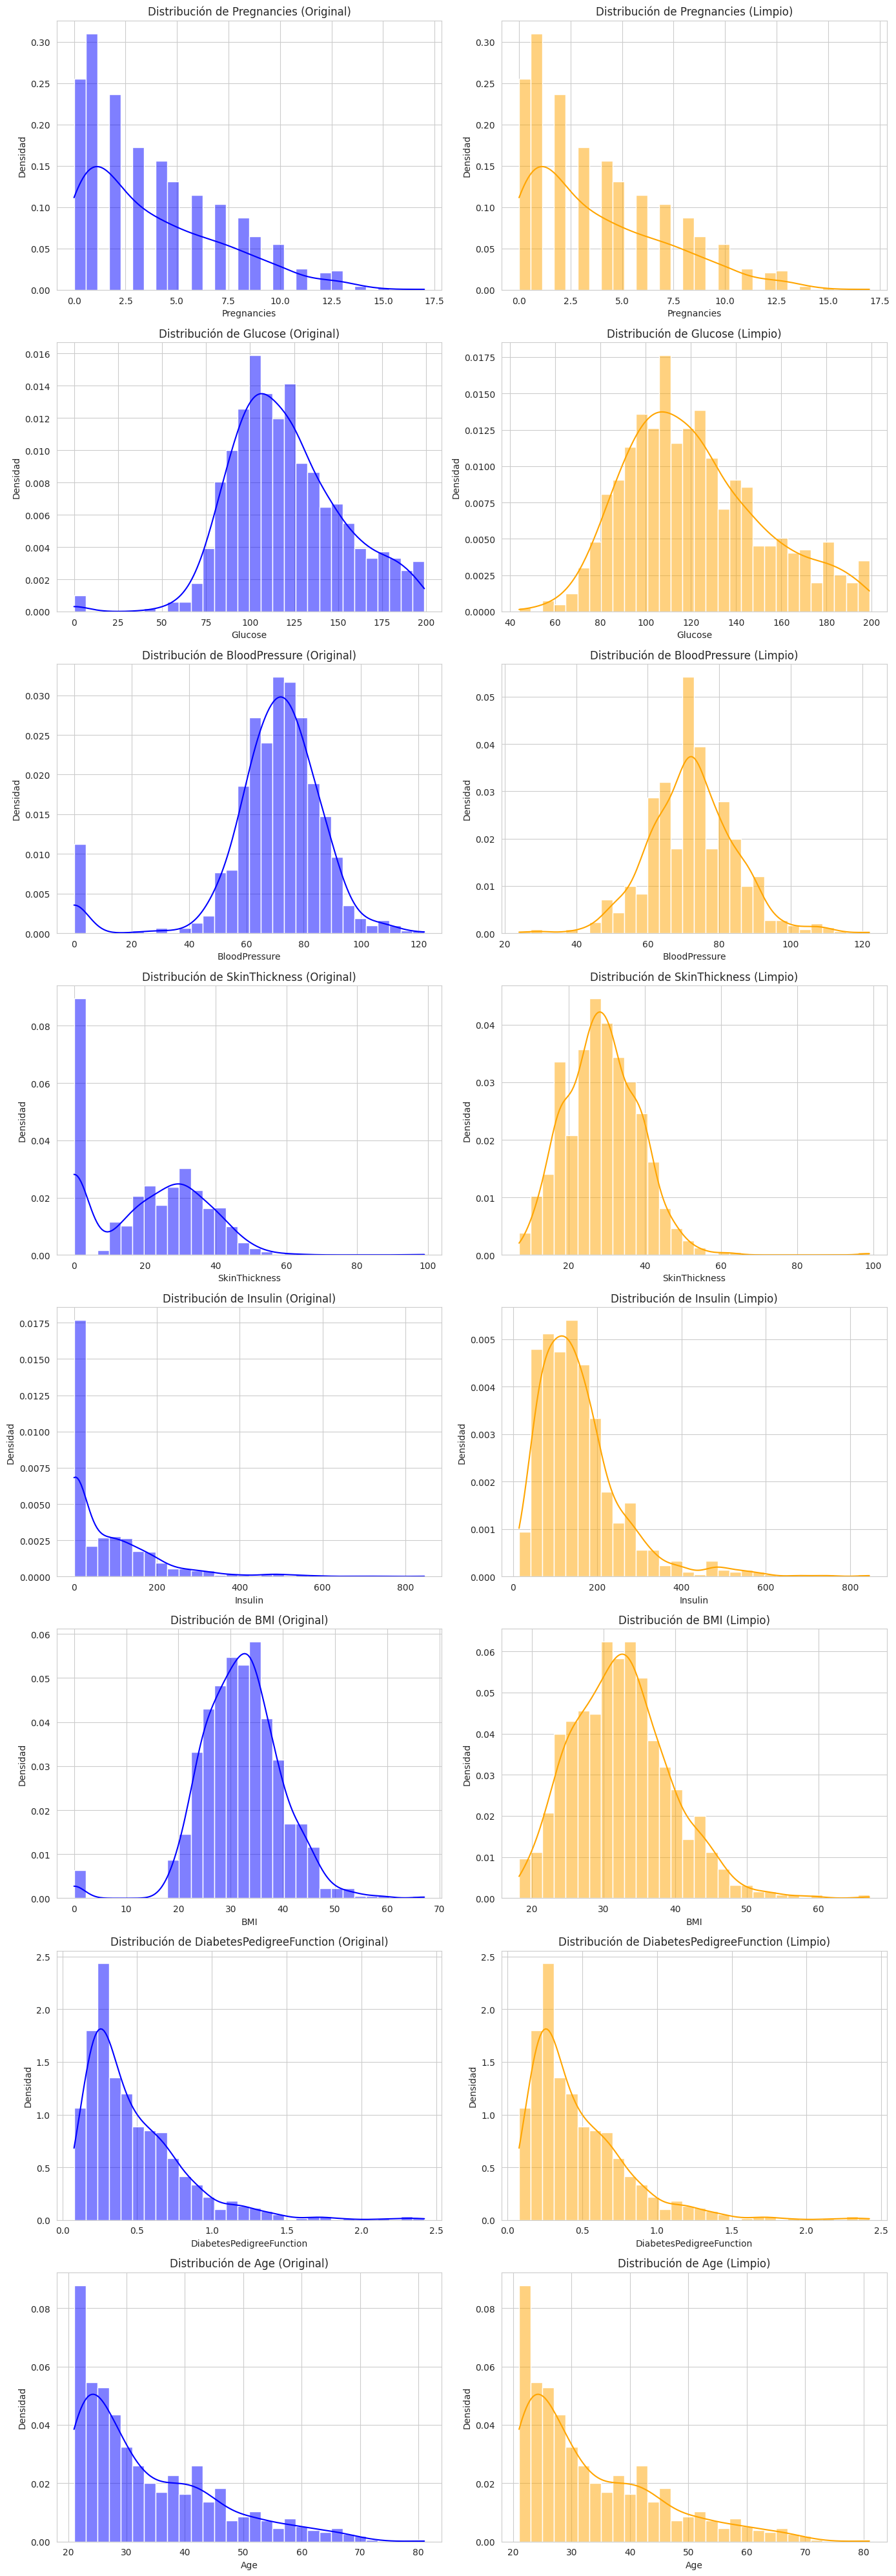

In [ ]:
# Lista de variables numéricas a comparar, excluyendo 'Outcome' y 'missing_both'
variables = [col for col in df.columns if col not in ['Outcome', 'missing_both']]

# Calcular el número de filas necesarias (una fila por variable)
n_variables = len(variables)

# Crear subplots con dos columnas (original y limpio)
fig, axes = plt.subplots(n_variables, 2, figsize=(14, 5 * n_variables))

# Iterar sobre cada variable
for i, variable in enumerate(variables):
    # Dataset original (izquierda)
    sns.histplot(df[variable], kde=True, color='blue', stat='density', bins=30, ax=axes[i, 0])
    axes[i, 0].set_title(f'Distribución de {variable} (Original)')
    axes[i, 0].set_xlabel(variable)
    axes[i, 0].set_ylabel('Densidad')

    # Dataset limpio (derecha)
    sns.histplot(df_cleaned[variable], kde=True, color='orange', stat='density', bins=30, ax=axes[i, 1])
    axes[i, 1].set_title(f'Distribución de {variable} (Limpio)')
    axes[i, 1].set_xlabel(variable)
    axes[i, 1].set_ylabel('Densidad')

# Ajustar el diseño
plt.tight_layout()
plt.show()


In [ ]:
# Verificar y eliminar la columna 'missing_both'
if 'missing_both' in df.columns:
    df.drop(columns=['missing_both'], inplace=True)

if 'missing_both' in df_cleaned.columns:
    df_cleaned.drop(columns=['missing_both'], inplace=True)


In [ ]:
print(df_cleaned.describe())
print(df.describe())

       Pregnancies     Glucose  BloodPressure  SkinThickness     Insulin  \
count   768.000000  768.000000     768.000000     768.000000  768.000000   
mean      3.845052  121.656250      72.386719      28.852713  157.002161   
std       3.369578   30.438286      12.096642       9.573208  102.416317   
min       0.000000   44.000000      24.000000       7.000000   14.000000   
25%       1.000000   99.750000      64.000000      22.000000   87.797500   
50%       3.000000  117.000000      72.000000      28.536146  135.000000   
75%       6.000000  140.250000      80.000000      35.032540  192.220000   
max      17.000000  199.000000     122.000000      99.000000  846.000000   

              BMI  DiabetesPedigreeFunction         Age     Outcome  
count  768.000000                768.000000  768.000000  768.000000  
mean    32.450911                  0.471876   33.240885    0.348958  
std      6.875366                  0.331329   11.760232    0.476951  
min     18.200000                  

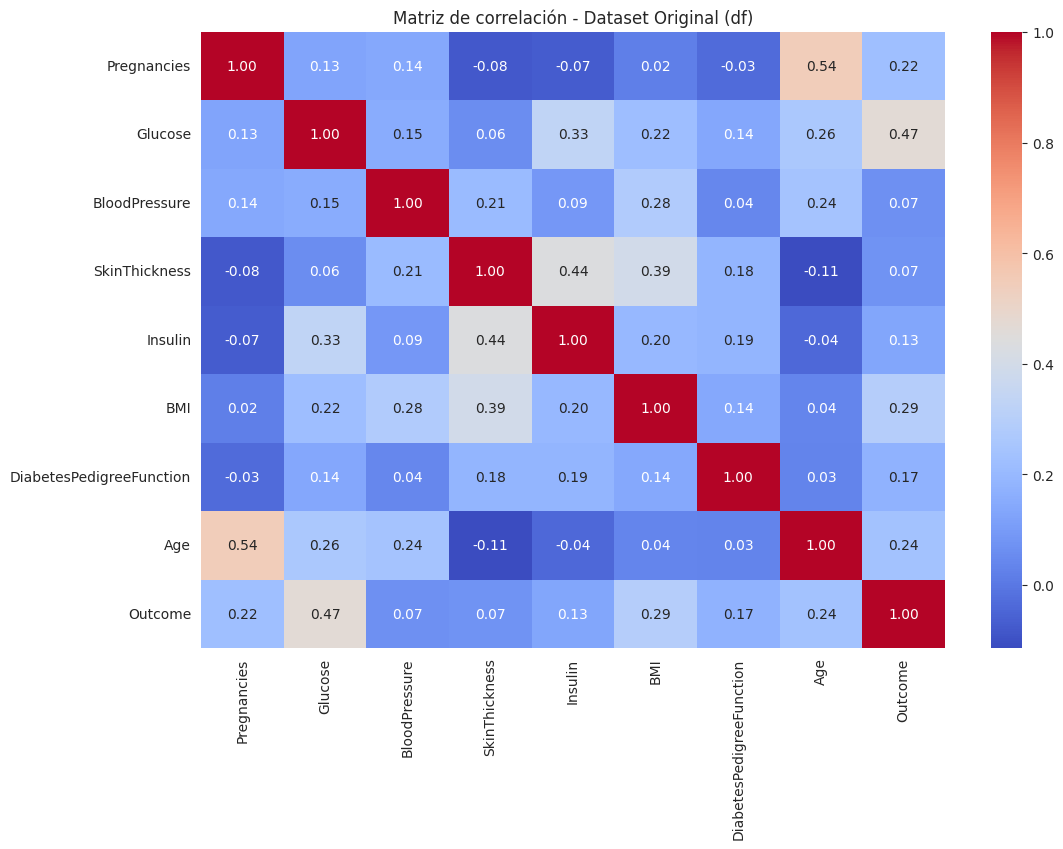

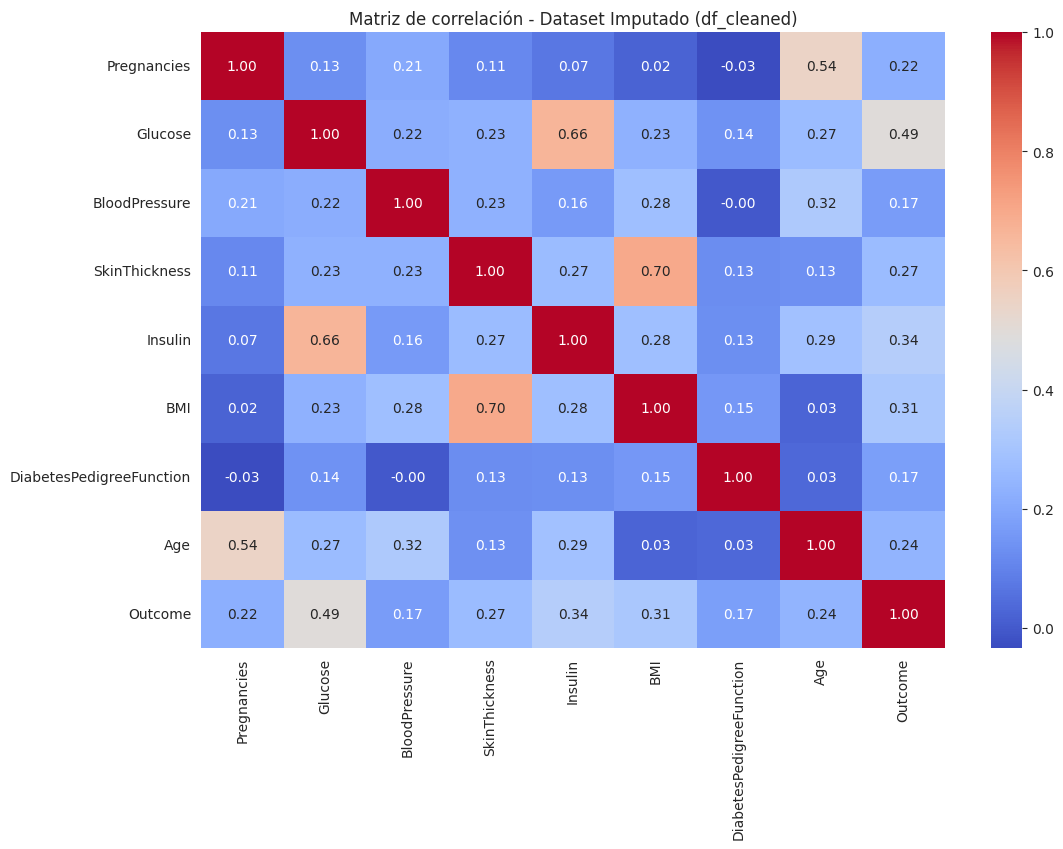

In [ ]:
# Calcular la matriz de correlación para el dataset original (df)
correlation_original = df.corr()

# Calcular la matriz de correlación para el dataset imputado (df_cleaned)
correlation_cleaned = df_cleaned.corr()

# Crear el mapa de calor para el dataset original
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_original, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Matriz de correlación - Dataset Original (df)")
plt.show()

# Crear el mapa de calor para el dataset imputado
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_cleaned, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Matriz de correlación - Dataset Imputado (df_cleaned)")
plt.show()

- Glucose, BloodPressure, y BMI han sido correctamente imputadas utilizando métodos simples como la mediana.
Las distribuciones son consistentes con los datos originales y no muestran sesgos significativos.

- Variables con modelos predictivos:
SkinThickness e Insulin han sido bien imputadas utilizando Random Forest:
Ambas variables muestran distribuciones naturales y consistentes con los datos válidos del dataset original.
Las colas largas características se han preservado, reflejando mejor la variabilidad esperada.

- Relaciones entre variables:
Las correlaciones entre variables relacionadas fisiológicamente (SkinThickness y BMI, Insulin y Glucose) ahora son más fuertes, lo cual es razonable tras la imputación.
Esto sugiere que el modelo predictivo utilizado para imputar estas variables capturó correctamente las relaciones subyacentes.
Las correlaciones entre otras variables (Pregnancies, Age, y Outcome) permanecen consistentes, lo que indica que la imputación no introdujo sesgos significativos en estas relaciones.

## Identificamos los outliers y decidimos cómo tratarlos

In [ ]:
# Seleccionar las columnas numéricas
nume_vars = ['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age']

# Identificar outliers usando el rango intercuartílico (IQR)
outliers = {}
for var in nume_vars:
    Q1 = df_cleaned[var].quantile(0.25)
    Q3 = df_cleaned[var].quantile(0.75)
    IQR = Q3 - Q1

    # Calcular los límites inferior y superior
    lower_bound = max(Q1 - 1.5 * IQR, 0)  # Ajustar el límite inferior a 0 si es negativo
    upper_bound = Q3 + 1.5 * IQR

    # Filtrar outliers
    outliers[var] = df_cleaned[(df_cleaned[var] < lower_bound) | (df_cleaned[var] > upper_bound)][var]

    print(f"Límites para {var}:")
    print(f"Lower Bound: {lower_bound}, Upper Bound: {upper_bound}")
    print(f"Número de outliers en {var}: {len(outliers[var])}")


Límites para Pregnancies:
Lower Bound: 0, Upper Bound: 13.5
Número de outliers en Pregnancies: 4
Límites para Glucose:
Lower Bound: 39.0, Upper Bound: 201.0
Número de outliers en Glucose: 0
Límites para BloodPressure:
Lower Bound: 40.0, Upper Bound: 104.0
Número de outliers en BloodPressure: 14
Límites para SkinThickness:
Lower Bound: 2.451190235569328, Upper Bound: 54.58134960738445
Número de outliers en SkinThickness: 4
Límites para Insulin:
Lower Bound: 0, Upper Bound: 348.85375
Número de outliers en Insulin: 36
Límites para BMI:
Lower Bound: 13.849999999999998, Upper Bound: 50.25
Número de outliers en BMI: 8
Límites para DiabetesPedigreeFunction:
Lower Bound: 0, Upper Bound: 1.2
Número de outliers en DiabetesPedigreeFunction: 29
Límites para Age:
Lower Bound: 0, Upper Bound: 66.5
Número de outliers en Age: 9


- Las variables Insulin, BloodPressure, y DiabetesPedigreeFunction presentan un número significativo de outliers, lo cual es esperado debido a su alta variabilidad fisiológica.

- Los valores atípicos en variables como Pregnancies, SkinThickness, y BMI son plausibles pero representan casos extremos que podrían influir en los análisis posteriores si no se manejan adecuadamente.

- No se identificaron outliers en Glucose, lo que indica que esta variable está dentro de un rango razonable tras la imputación.

- En el presente análisis del conjunto de datos de Diabetes de los Indios Pima, adoptamos un enfoque cauteloso hacia el tratamiento de los valores atípicos. Reconocemos que, si bien algunos valores extremos podrían considerarse errores de medición, muchos de ellos representan características biológicas reales y plausibles dentro de la población de estudio. Por ejemplo, niveles elevados de insulina pueden indicar resistencia a la insulina o etapas tempranas de la diabetes tipo 2, mientras que un alto número de embarazos puede reflejar patrones demográficos específicos de la comunidad Pima.

Por lo tanto, en lugar de eliminar o transformar agresivamente estos valores atípicos, optamos por aplicar técnicas de tratamiento que mitiguen su impacto en los modelos predictivos sin eliminar por completo la información que contienen. Esto nos permite preservar la variabilidad natural de los datos y evitar la introducción de sesgos artificiales, al tiempo que mejoramos la robustez y la generalización de los modelos

- Hemos optado por crear diferentes DataFrames para probar distintos enfoques de tratamiento de outliers y comparar los resultados. En este cuaderno vamos a aplicar:
  - Transformación logarítmica para variables con distribuciones sesgadas hacia la derecha (como Insulin, BMI, o DiabetesPedigreeFunction).
  - Imputación con la mediana para variables con pocos valores atípicos que no afectan significativamente la distribución general.
  - Winsorización para reducir el impacto de los valores extremos mientras se preservan todos los registros.
  - Reemplazo por límites aceptables cuando los valores extremos son plausibles pero deben ajustarse a límites razonables.

In [ ]:
# Crear una nueva copia del DataFrame para la nueva estrategia de outliers
df_adjusted = df_cleaned.copy()

Este DataFrame representa nuestra primera iteración en el tratamiento de outliers. Aquí aplicamos:
- Transformación logarítmica: Para variables sesgadas hacia la derecha, como Insulin, BMI y DiabetesPedigreeFunction.
- Winsorización: Para variables con valores extremos plausibles pero que deben ajustarse, como Pregnancies y Age.
- Imputación con la mediana: Para variables con pocos valores atípicos, como SkinThickness y BloodPressure.

In [ ]:
# 1. Transformación Logarítmica + Winsorización para Insulin, BMI y DiabetesPedigreeFunction
log_vars = ['Insulin', 'BMI', 'DiabetesPedigreeFunction']
winsorization_limit = 0.025  # Reducir este límite para mayor control

for var in log_vars:
    # Transformación Logarítmica
    df_adjusted[f'{var}_log'] = np.log1p(df_adjusted[var])

    # Winsorización de la variable transformada
    df_adjusted[f'{var}_log_winsorized'] = winsorize(df_adjusted[f'{var}_log'], limits=[winsorization_limit, winsorization_limit])


In [ ]:
# 2. Ajuste de Límites de Winsorización para Pregnancies y Age
winsorization_limit_pregnancies = 0.05  # Aumentar este límite para reducir la acumulación
winsorization_limit_age = 0.05  # Aumentar este límite para reducir la acumulación

df_adjusted['Pregnancies_winsorized'] = winsorize(df_adjusted['Pregnancies'], limits=[winsorization_limit_pregnancies, winsorization_limit_pregnancies])
df_adjusted['Age_winsorized'] = winsorize(df_adjusted['Age'], limits=[winsorization_limit_age, winsorization_limit_age])

In [ ]:
# 3. Imputación con la mediana para SkinThickness y BloodPressure (sin cambios)
median_vars = ['SkinThickness', 'BloodPressure']
for var in median_vars:
    median_value = df_adjusted[var].median()
    iqr = df_adjusted[var].quantile(0.75) - df_adjusted[var].quantile(0.25)
    lower_bound = df_adjusted[var].quantile(0.25) - 1.5 * iqr
    upper_bound = df_adjusted[var].quantile(0.75) + 1.5 * iqr

    # Reemplazar outliers por la mediana
    df_adjusted[var] = np.where(
        (df_adjusted[var] < lower_bound) | (df_adjusted[var] > upper_bound),
        median_value,
        df_adjusted[var]
    )

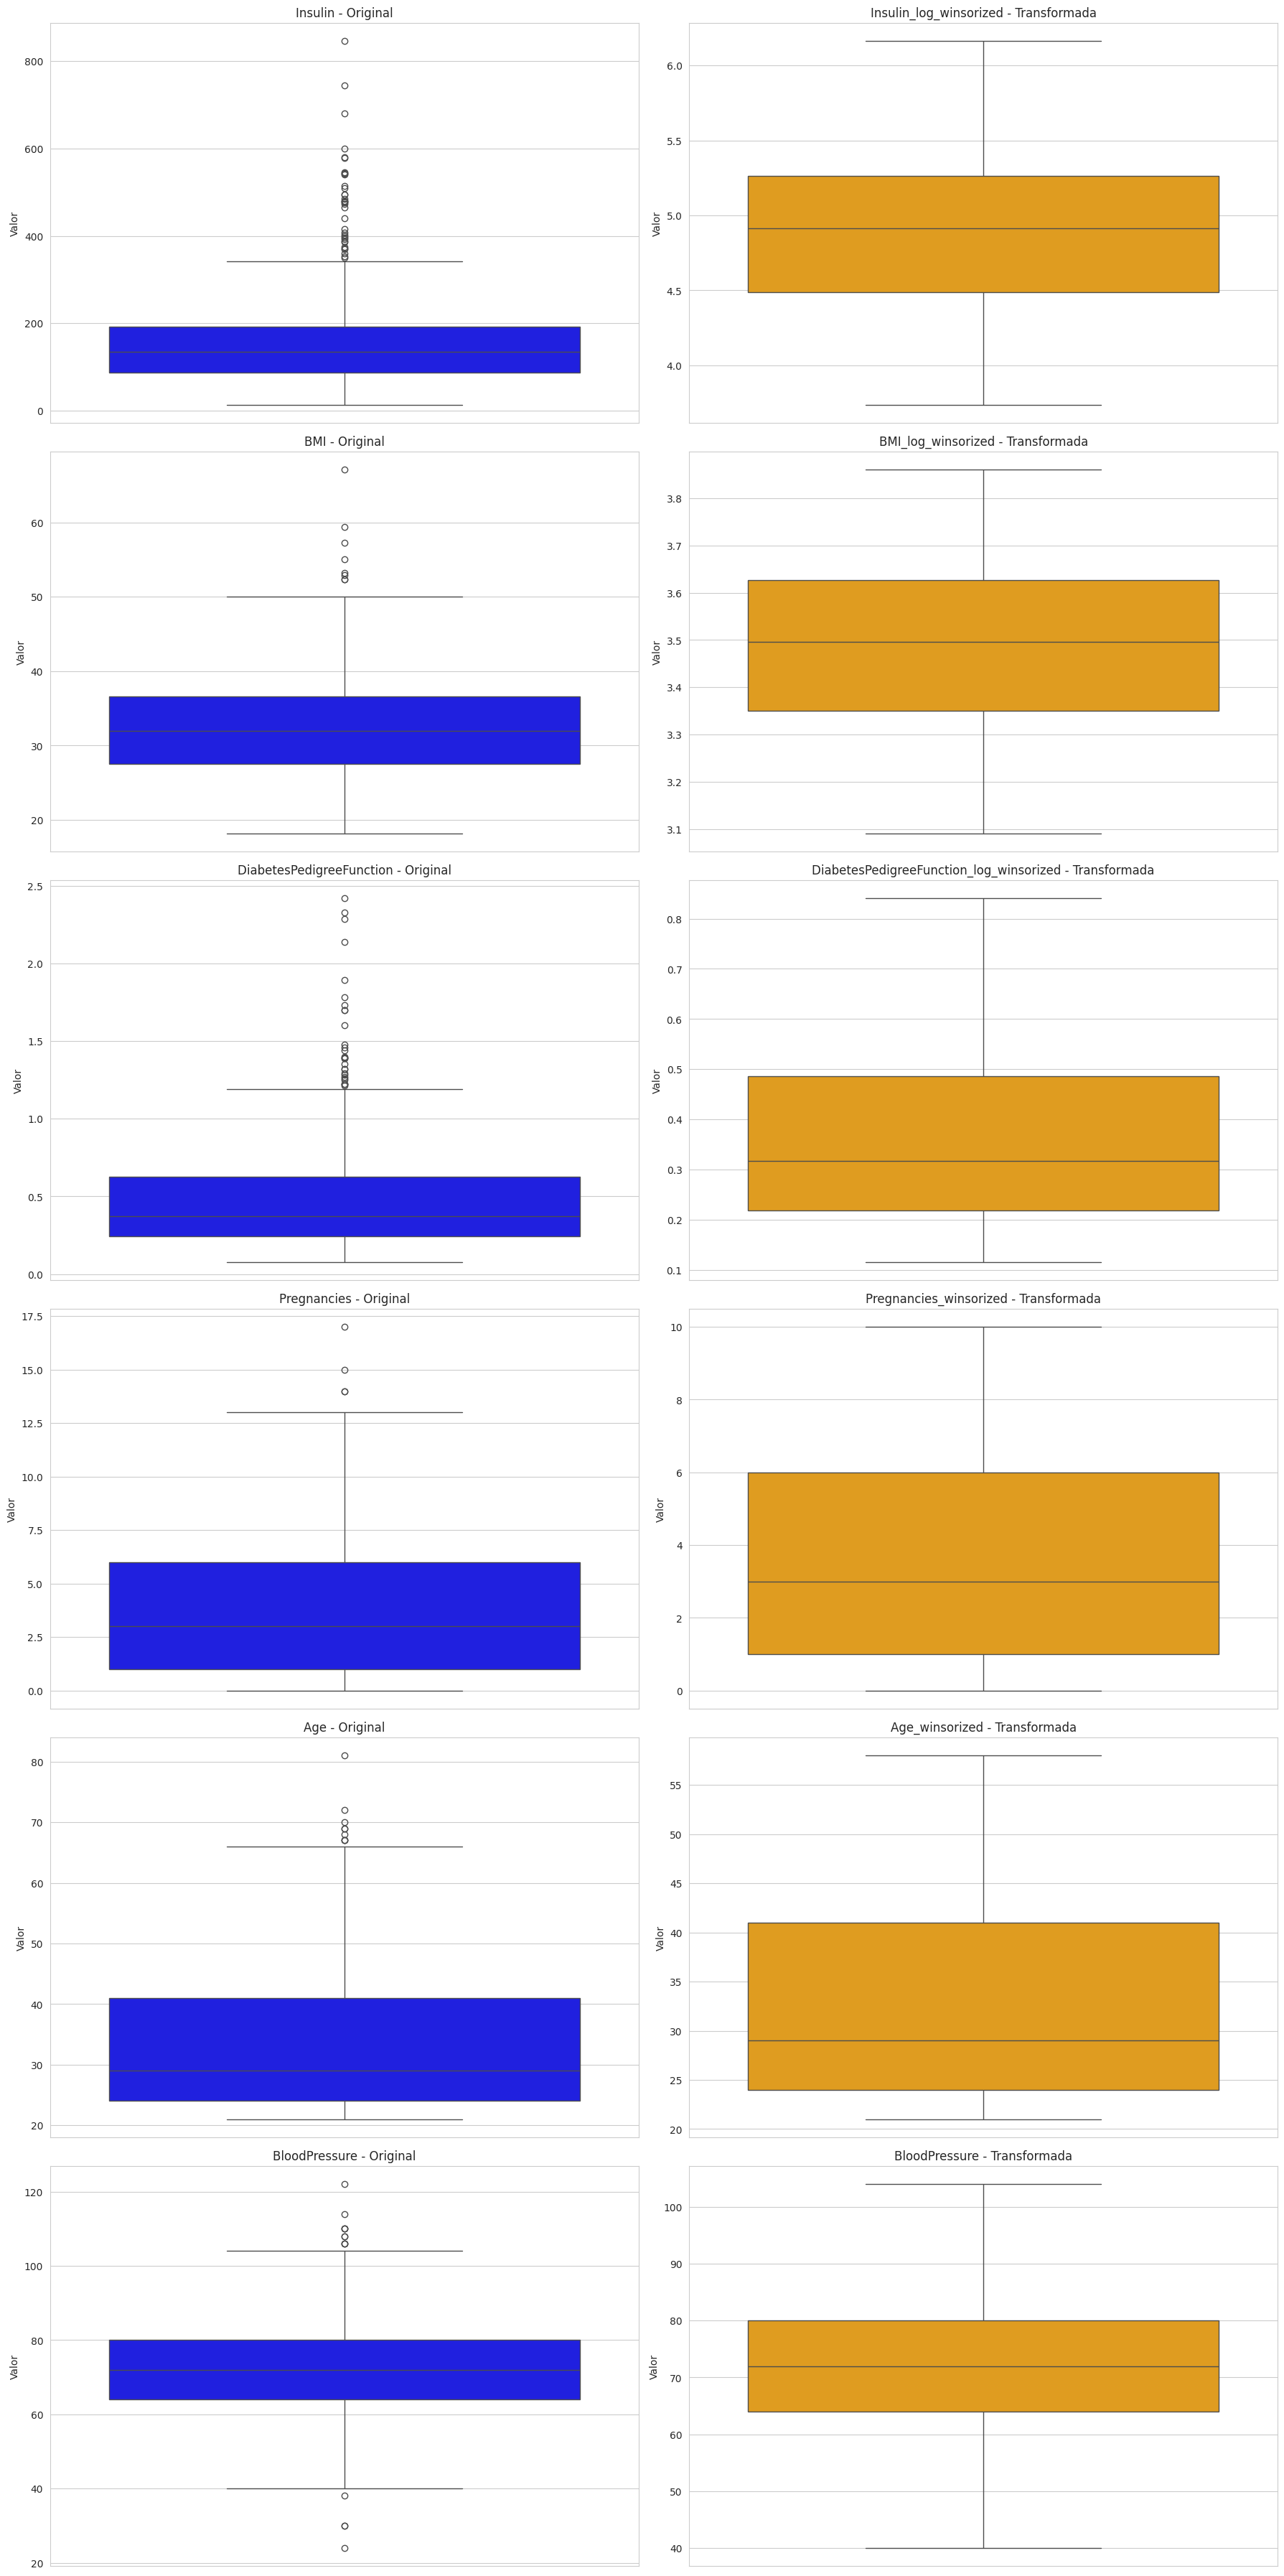

In [ ]:
# Lista de variables a visualizar
variables_a_visualizar = {
    'Insulin': ('Insulin', 'Insulin_log_winsorized'),
    'BMI': ('BMI', 'BMI_log_winsorized'),
    'DiabetesPedigreeFunction': ('DiabetesPedigreeFunction', 'DiabetesPedigreeFunction_log_winsorized'),
    'Pregnancies': ('Pregnancies', 'Pregnancies_winsorized'),
    'Age': ('Age', 'Age_winsorized'),
    'BloodPressure': ('BloodPressure', 'BloodPressure')  # Ya que imputamos, mostramos la variable directamente
}

# Calcular el número de filas necesarias para las variables
n_variables = len(variables_a_visualizar)

# Crear subplots
fig, axes = plt.subplots(n_variables, 2, figsize=(18, 6 * n_variables))

# Iterar sobre las variables y crear los gráficos
for i, (var, (var_original, var_transformada)) in enumerate(variables_a_visualizar.items()):
    # Boxplot de la variable original
    sns.boxplot(y=df_cleaned[var_original], color='blue', ax=axes[i, 0])
    axes[i, 0].set_title(f'{var_original} - Original')
    axes[i, 0].set_ylabel('Valor')

    # Boxplot de la variable transformada
    sns.boxplot(y=df_adjusted[var_transformada], color='orange', ax=axes[i, 1])
    axes[i, 1].set_title(f'{var_transformada} - Transformada')
    axes[i, 1].set_ylabel('Valor')

plt.tight_layout()
plt.show()


---

Ahora vamos a crear un nuevo dataframe llamado df_adjusted2:

Este DataFrame refleja un enfoque refinado basado en las observaciones del primer ajuste.

- Mantenemos la transformación logarítmica y winsorización para Insulin y BMI.

- Aplicamos un límite de winsorización más estricto (1%) para DiabetesPedigreeFunction para abordar mejor sus valores extremos.

- Aumentamos el límite de winsorización al 7.5% para Pregnancies y Age para reducir la acumulación de valores en los extremos.

- Mantenemos la misma estrategia de imputación para SkinThickness y BloodPressure.

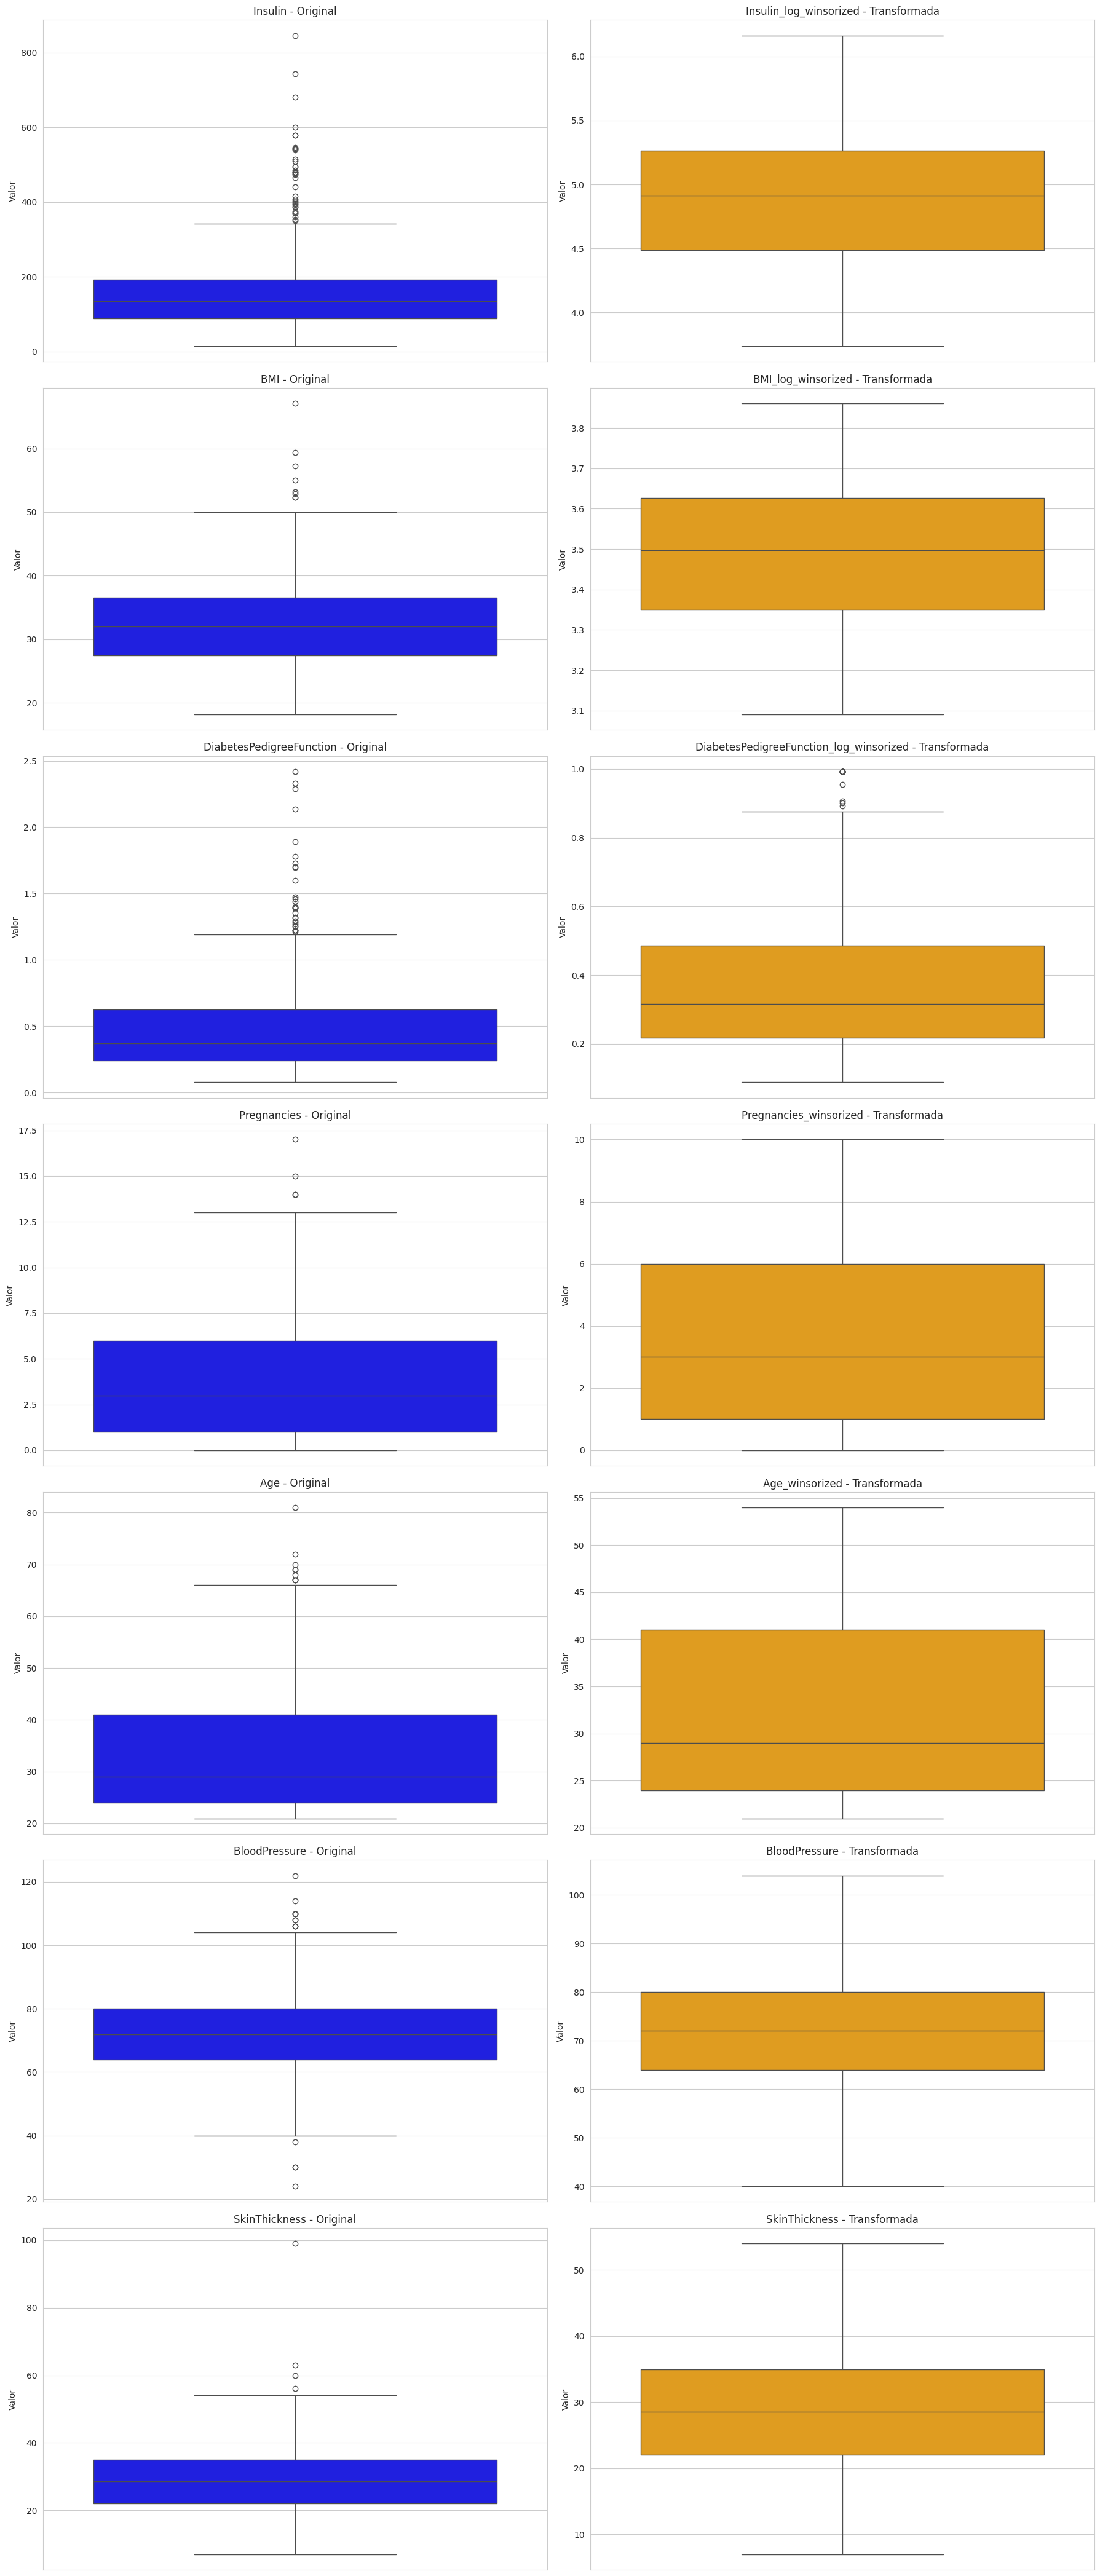

In [ ]:
# Crear una nueva copia del DataFrame para la nueva estrategia de outliers
df_adjusted2 = df_cleaned.copy()

# 1. Transformación Logarítmica + Winsorización para Insulin, BMI y DiabetesPedigreeFunction
log_vars = ['Insulin', 'BMI', 'DiabetesPedigreeFunction']
winsorization_limit = 0.025

for var in log_vars:
    # Transformación Logarítmica
    df_adjusted2[f'{var}_log'] = np.log1p(df_adjusted2[var])

    # Winsorización de la variable transformada
    df_adjusted2[f'{var}_log_winsorized'] = winsorize(df_adjusted2[f'{var}_log'], limits=[winsorization_limit, winsorization_limit])

# 2. Ajuste de Límites de Winsorización para Pregnancies y Age
winsorization_limit_pregnancies = 0.075  # Aumentar este límite para reducir la acumulación
winsorization_limit_age = 0.075  # Aumentar este límite para reducir la acumulación

df_adjusted2['Pregnancies_winsorized'] = winsorize(df_adjusted2['Pregnancies'], limits=[winsorization_limit_pregnancies, winsorization_limit_pregnancies])
df_adjusted2['Age_winsorized'] = winsorize(df_adjusted2['Age'], limits=[winsorization_limit_age, winsorization_limit_age])

# 3. Reducir winsorization_limit para DiabetesPedigreeFunction

winsorization_limit_diabetes = 0.01
log_vars = ['DiabetesPedigreeFunction']

for var in log_vars:
    # Transformación Logarítmica
    df_adjusted2[f'{var}_log'] = np.log1p(df_adjusted2[var])

    # Winsorización de la variable transformada
    df_adjusted2[f'{var}_log_winsorized'] = winsorize(df_adjusted2[f'{var}_log'], limits=[winsorization_limit_diabetes, winsorization_limit_diabetes])

# 4. Imputación con la mediana para SkinThickness y BloodPressure (sin cambios)
median_vars = ['SkinThickness', 'BloodPressure']
for var in median_vars:
    median_value = df_adjusted2[var].median()
    iqr = df_adjusted2[var].quantile(0.75) - df_adjusted2[var].quantile(0.25)
    lower_bound = df_adjusted2[var].quantile(0.25) - 1.5 * iqr
    upper_bound = df_adjusted2[var].quantile(0.75) + 1.5 * iqr

    # Reemplazar outliers por la mediana
    df_adjusted2[var] = np.where(
        (df_adjusted2[var] < lower_bound) | (df_adjusted2[var] > upper_bound),
        median_value,
        df_adjusted2[var]
    )

# Lista de variables a visualizar
variables_a_visualizar = {
    'Insulin': ('Insulin', 'Insulin_log_winsorized'),
    'BMI': ('BMI', 'BMI_log_winsorized'),
    'DiabetesPedigreeFunction': ('DiabetesPedigreeFunction', 'DiabetesPedigreeFunction_log_winsorized'),
    'Pregnancies': ('Pregnancies', 'Pregnancies_winsorized'),
    'Age': ('Age', 'Age_winsorized'),
    'BloodPressure': ('BloodPressure', 'BloodPressure'),
    'SkinThickness':('SkinThickness', 'SkinThickness') # Ya que imputamos, mostramos la variable directamente
}

# Calcular el número de filas necesarias para las variables
n_variables = len(variables_a_visualizar)

# Crear subplots
fig, axes = plt.subplots(n_variables, 2, figsize=(18, 6 * n_variables))

# Iterar sobre las variables y crear los gráficos
for i, (var, (var_original, var_transformada)) in enumerate(variables_a_visualizar.items()):
    # Boxplot de la variable original
    sns.boxplot(y=df_cleaned[var_original], color='blue', ax=axes[i, 0])
    axes[i, 0].set_title(f'{var_original} - Original')
    axes[i, 0].set_ylabel('Valor')

    # Boxplot de la variable transformada
    sns.boxplot(y=df_adjusted2[var_transformada], color='orange', ax=axes[i, 1])
    axes[i, 1].set_title(f'{var_transformada} - Transformada')
    axes[i, 1].set_ylabel('Valor')

plt.tight_layout()
plt.show()

- En general, las transformaciones aplicadas han sido efectivas para reducir la cantidad de outliers en las variables. La combinación de la transformación logarítmica y la winsorización ha sido útil para mitigar los valores extremos en variables como Insulin, BMI y DiabetesPedigreeFunction.

- Las transformaciones han preservado en gran medida la forma general de las distribuciones, lo que es importante para no distorsionar demasiado la información original en los datos.

- El ajuste de los límites de winsorización ha sido efectivo para reducir la acumulación en los límites en variables como Pregnancies y Age.

Para poder escoger el dataframe co la trasnformación mas apropiada, vamos a representar la distribución de los datos con histogramas para ver si la transformación ha afectado la forma general de la distribución (por ejemplo, si ha introducido sesgos o acumulaciones, si hay pérdida de información relevante ó si la variabilidad de lso datos se a visto afectada).


Compararando las distribuciones originales y transformadas nos permitirá tomar una decisión más informada sobre que transformación es más adecuada para nuestros datos.

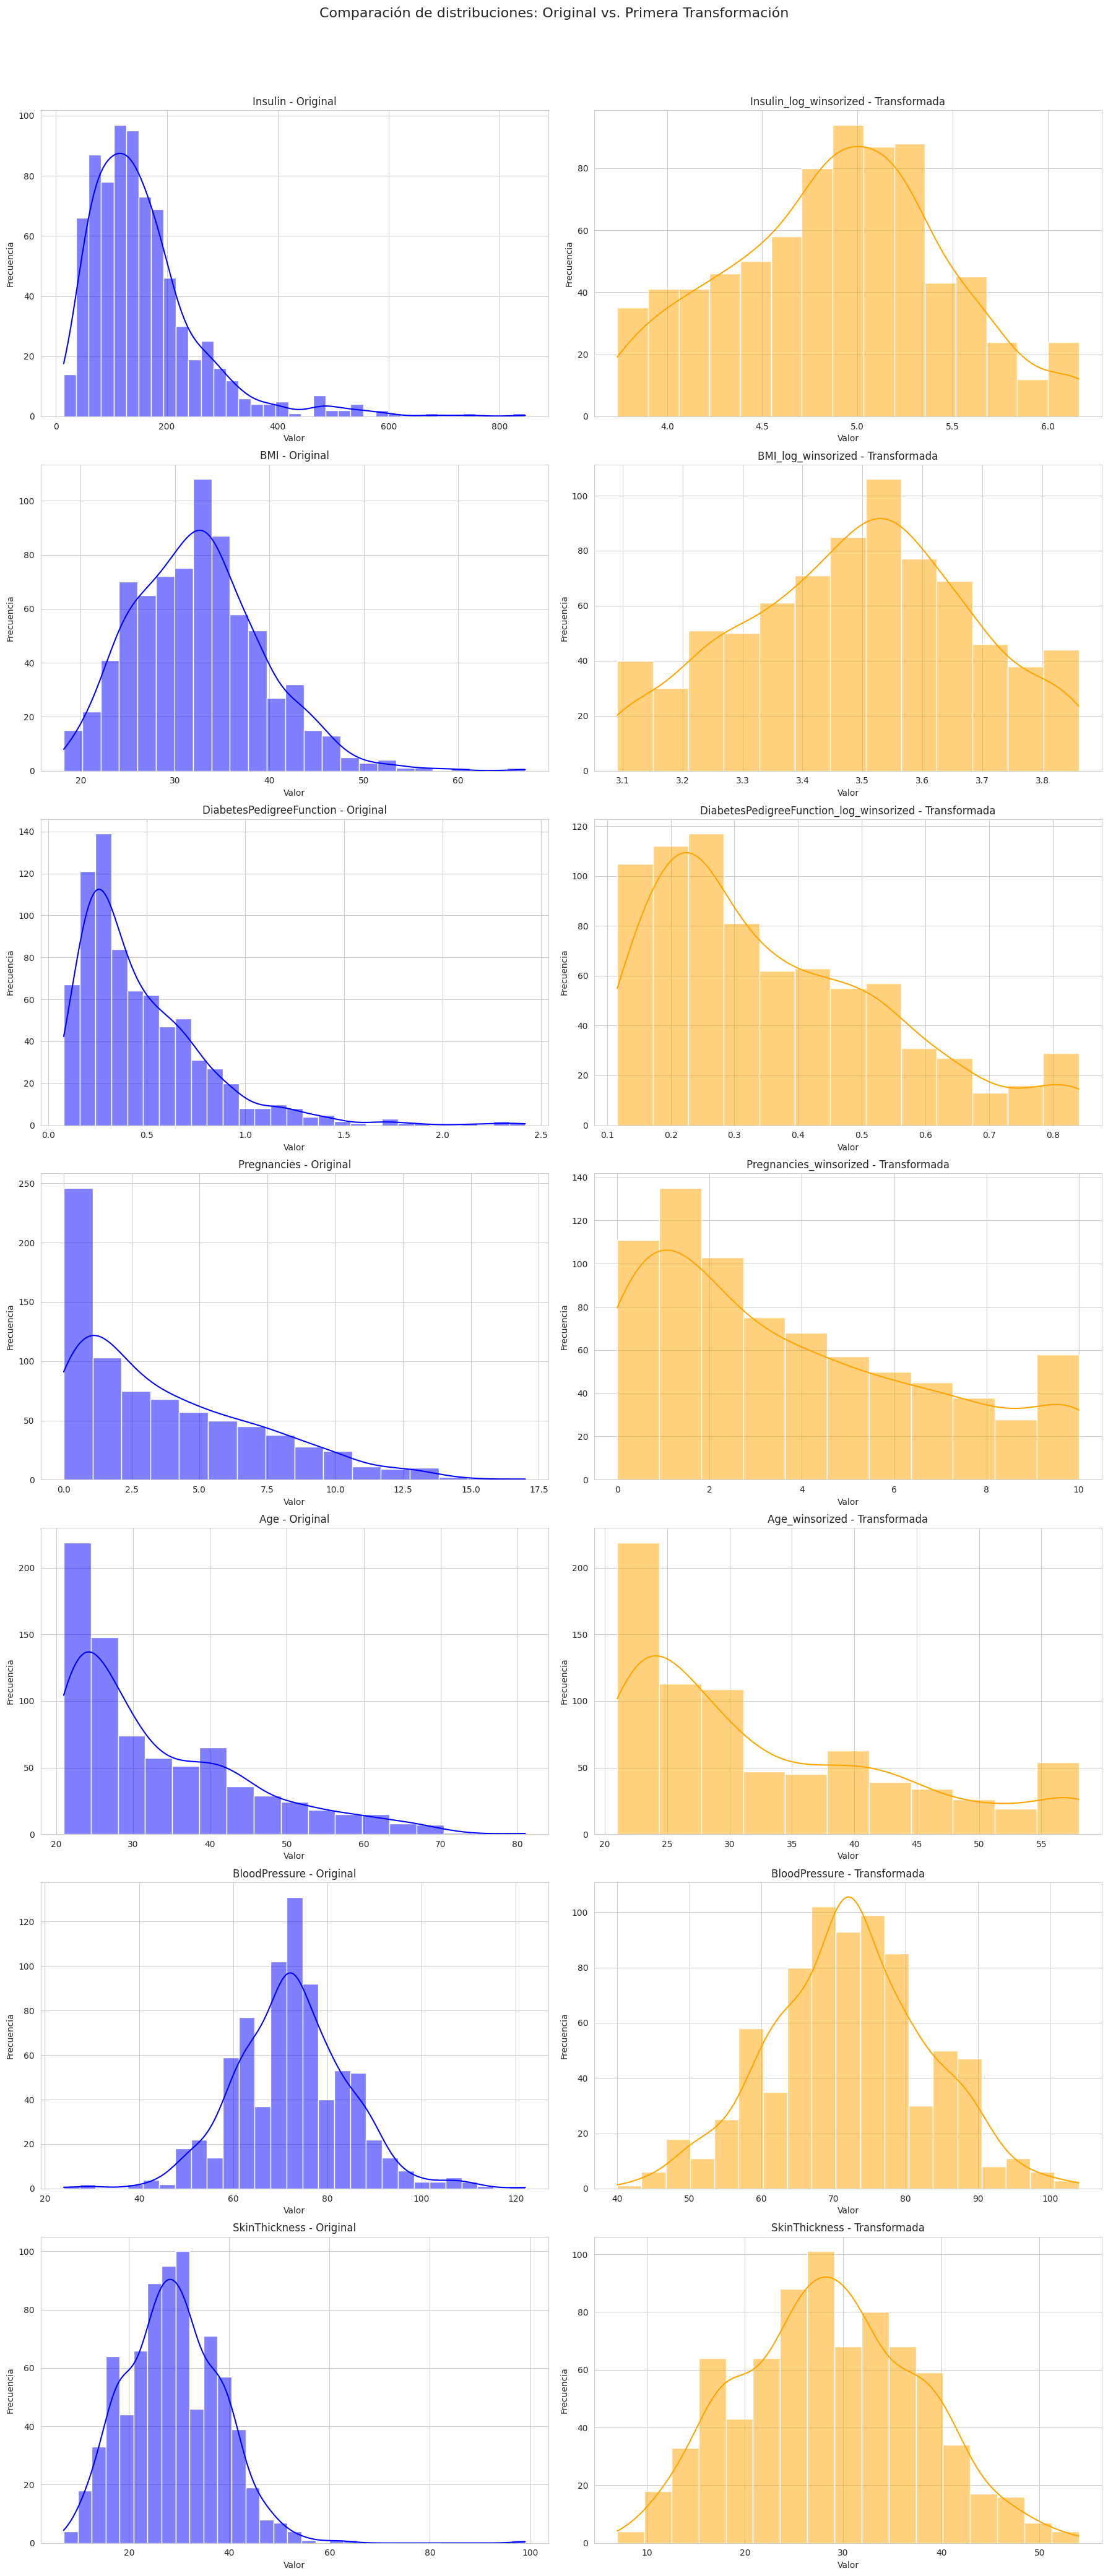

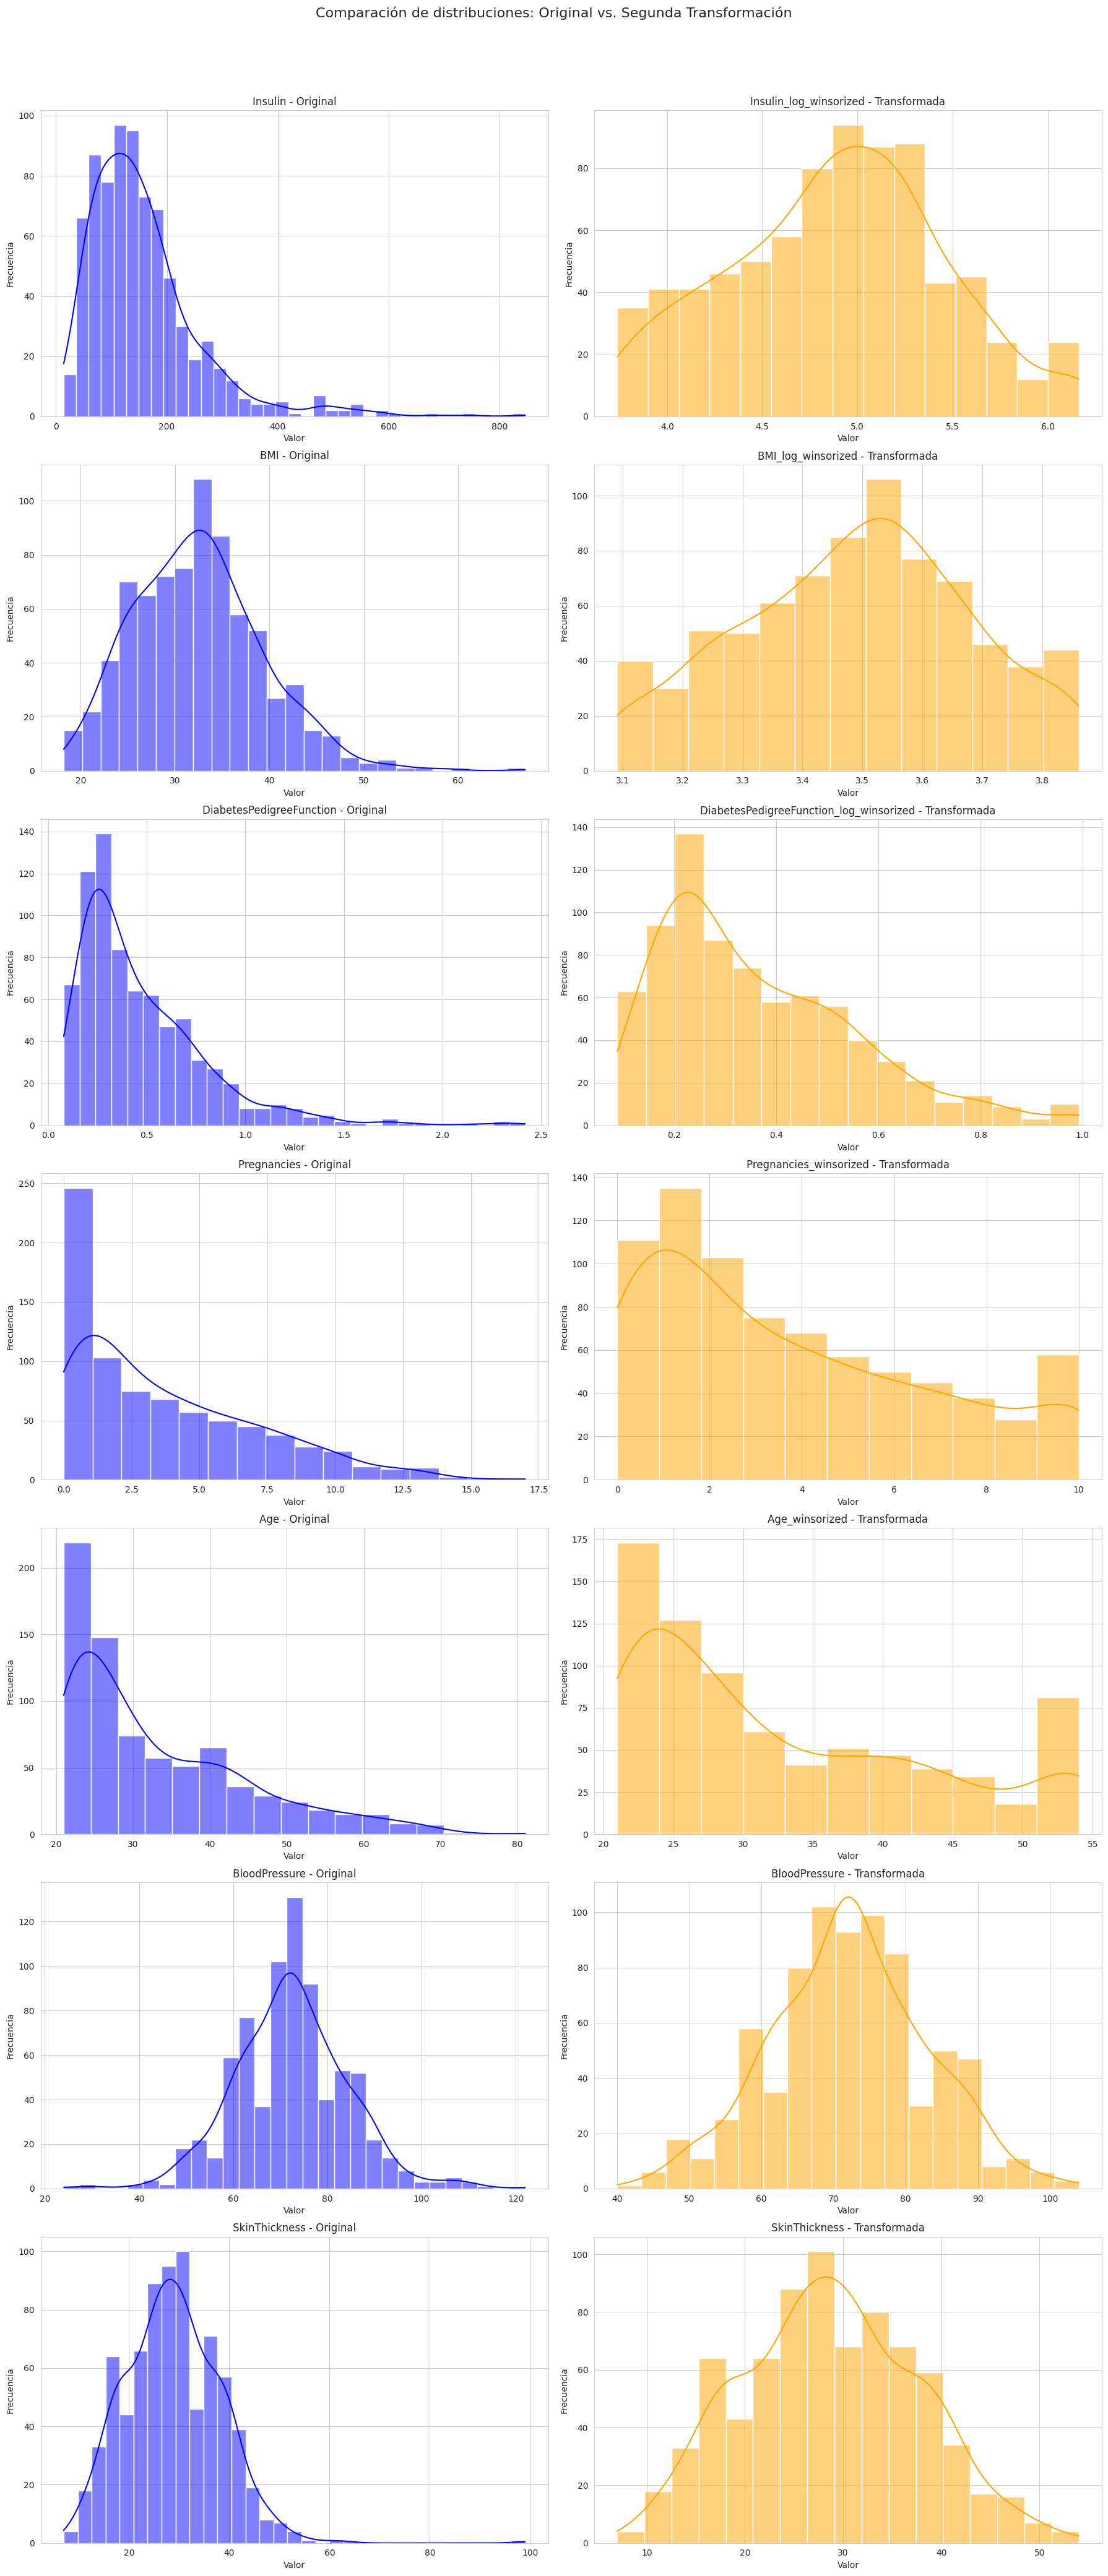

In [ ]:
# Lista de variables a visualizar
variables_a_visualizar = {
    'Insulin': ('Insulin', 'Insulin_log_winsorized'),
    'BMI': ('BMI', 'BMI_log_winsorized'),
    'DiabetesPedigreeFunction': ('DiabetesPedigreeFunction', 'DiabetesPedigreeFunction_log_winsorized'),
    'Pregnancies': ('Pregnancies', 'Pregnancies_winsorized'),
    'Age': ('Age', 'Age_winsorized'),
    'BloodPressure': ('BloodPressure', 'BloodPressure'),
    'SkinThickness':('SkinThickness', 'SkinThickness')
}

# Función para crear y mostrar histogramas
def plot_histograms(df_original, df_transformed, title):
    fig, axes = plt.subplots(len(variables_a_visualizar), 2, figsize=(18, 6 * len(variables_a_visualizar)))

    for i, (var, (var_original, var_transformada)) in enumerate(variables_a_visualizar.items()):
        # Histograma de la variable original
        sns.histplot(df_original[var_original], kde=True, color='blue', ax=axes[i, 0])
        axes[i, 0].set_title(f'{var_original} - Original')
        axes[i, 0].set_xlabel('Valor')
        axes[i, 0].set_ylabel('Frecuencia')

        # Histograma de la variable transformada
        sns.histplot(df_transformed[var_transformada], kde=True, color='orange', ax=axes[i, 1])
        axes[i, 1].set_title(f'{var_transformada} - Transformada')
        axes[i, 1].set_xlabel('Valor')
        axes[i, 1].set_ylabel('Frecuencia')

    plt.suptitle(title, fontsize=16, y=0.99)
    plt.tight_layout()
    plt.subplots_adjust(top=0.95)  # Ajustar el espacio superior para que el título no se superponga
    plt.show()

# Crear y mostrar la comparación con la primera transformación
plot_histograms(df_cleaned, df_adjusted, "Comparación de distribuciones: Original vs. Primera Transformación")

# Crear y mostrar la comparación con la segunda transformación
plot_histograms(df_cleaned, df_adjusted2, "Comparación de distribuciones: Original vs. Segunda Transformación")


Después de revisar los outputs de los gráficos vamos a mantener la primera transformación para las variables Insulin, BMI y DiabetesPedigreeFunction, y mantenemos la segunda transformación para Pregnancies y Age.

- Insulin y BMI:
La primera transformación proporciona una distribución más suave después de la transformación logarítmica y la winsorización. Se observa una mejor dispersión de los valores en comparación con la distribución original.

- DiabetesPedigreeFunction:
La primera transformación logra mitigar la influencia de valores extremos y proporciona una distribución más razonable. En cambio, en la segunda transformación, se comprime mucho más esta variable.

- Pregnancies y Age:
La segunda transformación parece mejor, ya que al suavizar la acumulación de valores en los límites, se mantiene mejor la forma general de las distribuciones.

- SkinThickness y BloodPressure:
Mantenemos la imputación con la mediana, ya que el objetivo es simplemente reducir la influencia de valores atípicos sin alterar significativamente la distribución general.

In [ ]:
# Crear una nueva copia del DataFrame para la nueva estrategia de outliers
df_final_adjusted = df_cleaned.copy()

# Aplicar la primera transformación a Insulin, BMI y DiabetesPedigreeFunction
log_vars = ['Insulin', 'BMI', 'DiabetesPedigreeFunction']
winsorization_limit = 0.025

for var in log_vars:
    df_final_adjusted[f'{var}_log'] = np.log1p(df_final_adjusted[var])
    df_final_adjusted[f'{var}_log_winsorized'] = winsorize(df_final_adjusted[f'{var}_log'], limits=[winsorization_limit, winsorization_limit])

# Aplicar la segunda transformación a Pregnancies y Age
winsorization_limit_pregnancies = 0.075
winsorization_limit_age = 0.075

df_final_adjusted['Pregnancies_winsorized'] = winsorize(df_final_adjusted['Pregnancies'], limits=[winsorization_limit_pregnancies, winsorization_limit_pregnancies])
df_final_adjusted['Age_winsorized'] = winsorize(df_final_adjusted['Age'], limits=[winsorization_limit_age, winsorization_limit_age])

# Reducir winsorization_limit para DiabetesPedigreeFunction

winsorization_limit_diabetes = 0.01
log_vars = ['DiabetesPedigreeFunction']

for var in log_vars:
    # Transformación Logarítmica
    df_final_adjusted[f'{var}_log'] = np.log1p(df_final_adjusted[var])

    # Winsorización de la variable transformada
    df_final_adjusted[f'{var}_log_winsorized'] = winsorize(df_final_adjusted[f'{var}_log'], limits=[winsorization_limit_diabetes, winsorization_limit_diabetes])

# Aplicar imputación con la mediana a SkinThickness y BloodPressure
median_vars = ['SkinThickness', 'BloodPressure']
for var in median_vars:
    median_value = df_final_adjusted[var].median()
    iqr = df_final_adjusted[var].quantile(0.75) - df_final_adjusted[var].quantile(0.25)
    lower_bound = df_final_adjusted[var].quantile(0.25) - 1.5 * iqr
    upper_bound = df_final_adjusted[var].quantile(0.75) + 1.5 * iqr

    # Reemplazar outliers por la mediana
    df_final_adjusted[var] = np.where(
        (df_final_adjusted[var] < lower_bound) | (df_final_adjusted[var] > upper_bound),
        median_value,
        df_final_adjusted[var]
    )


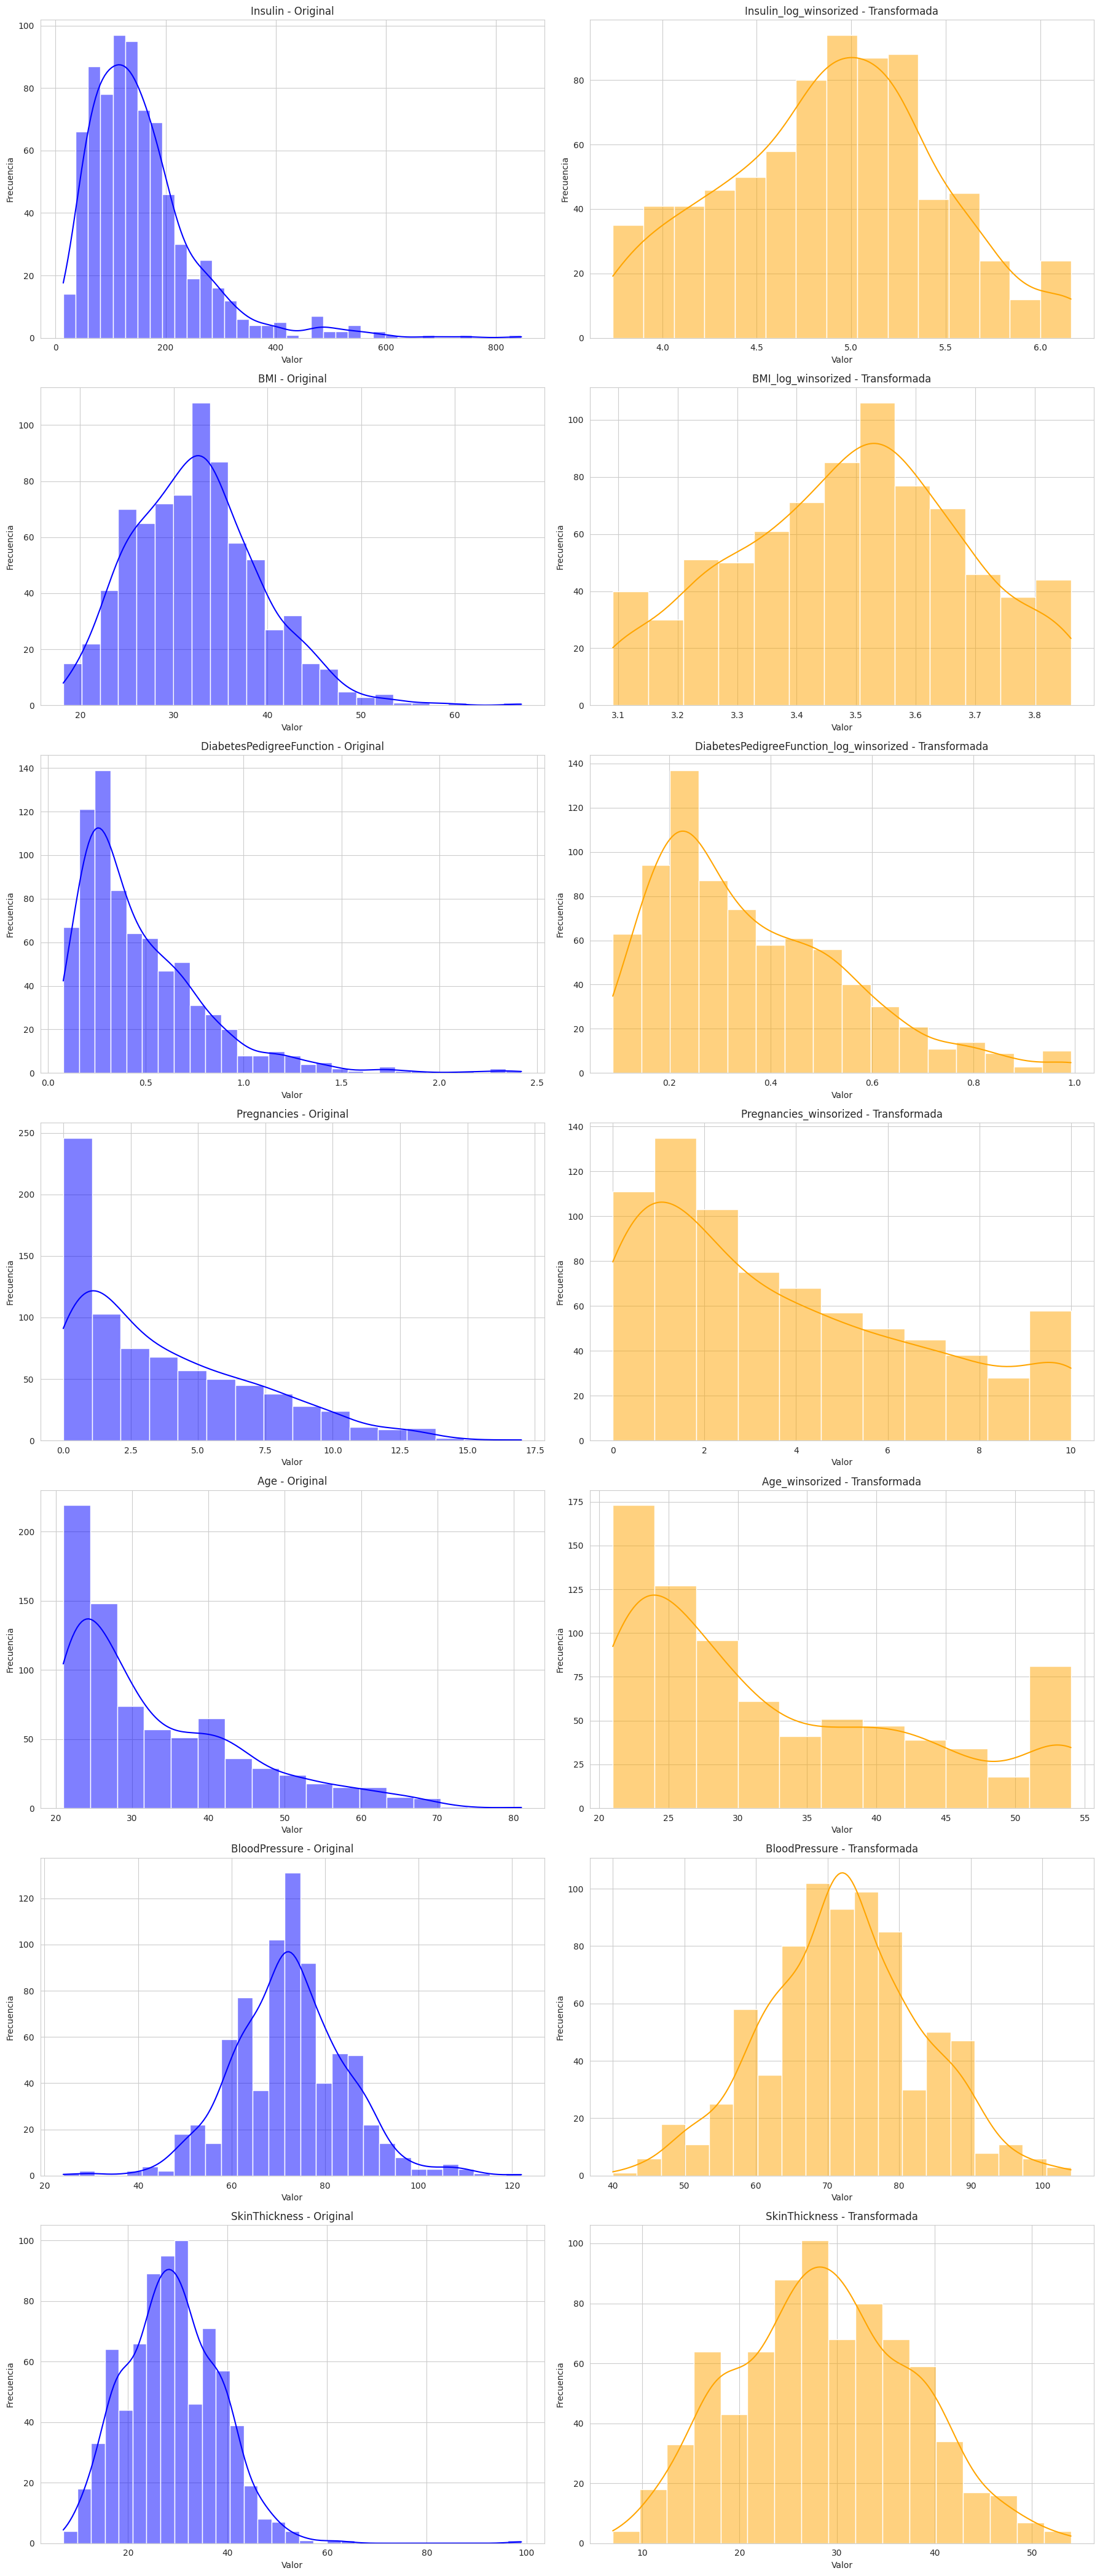

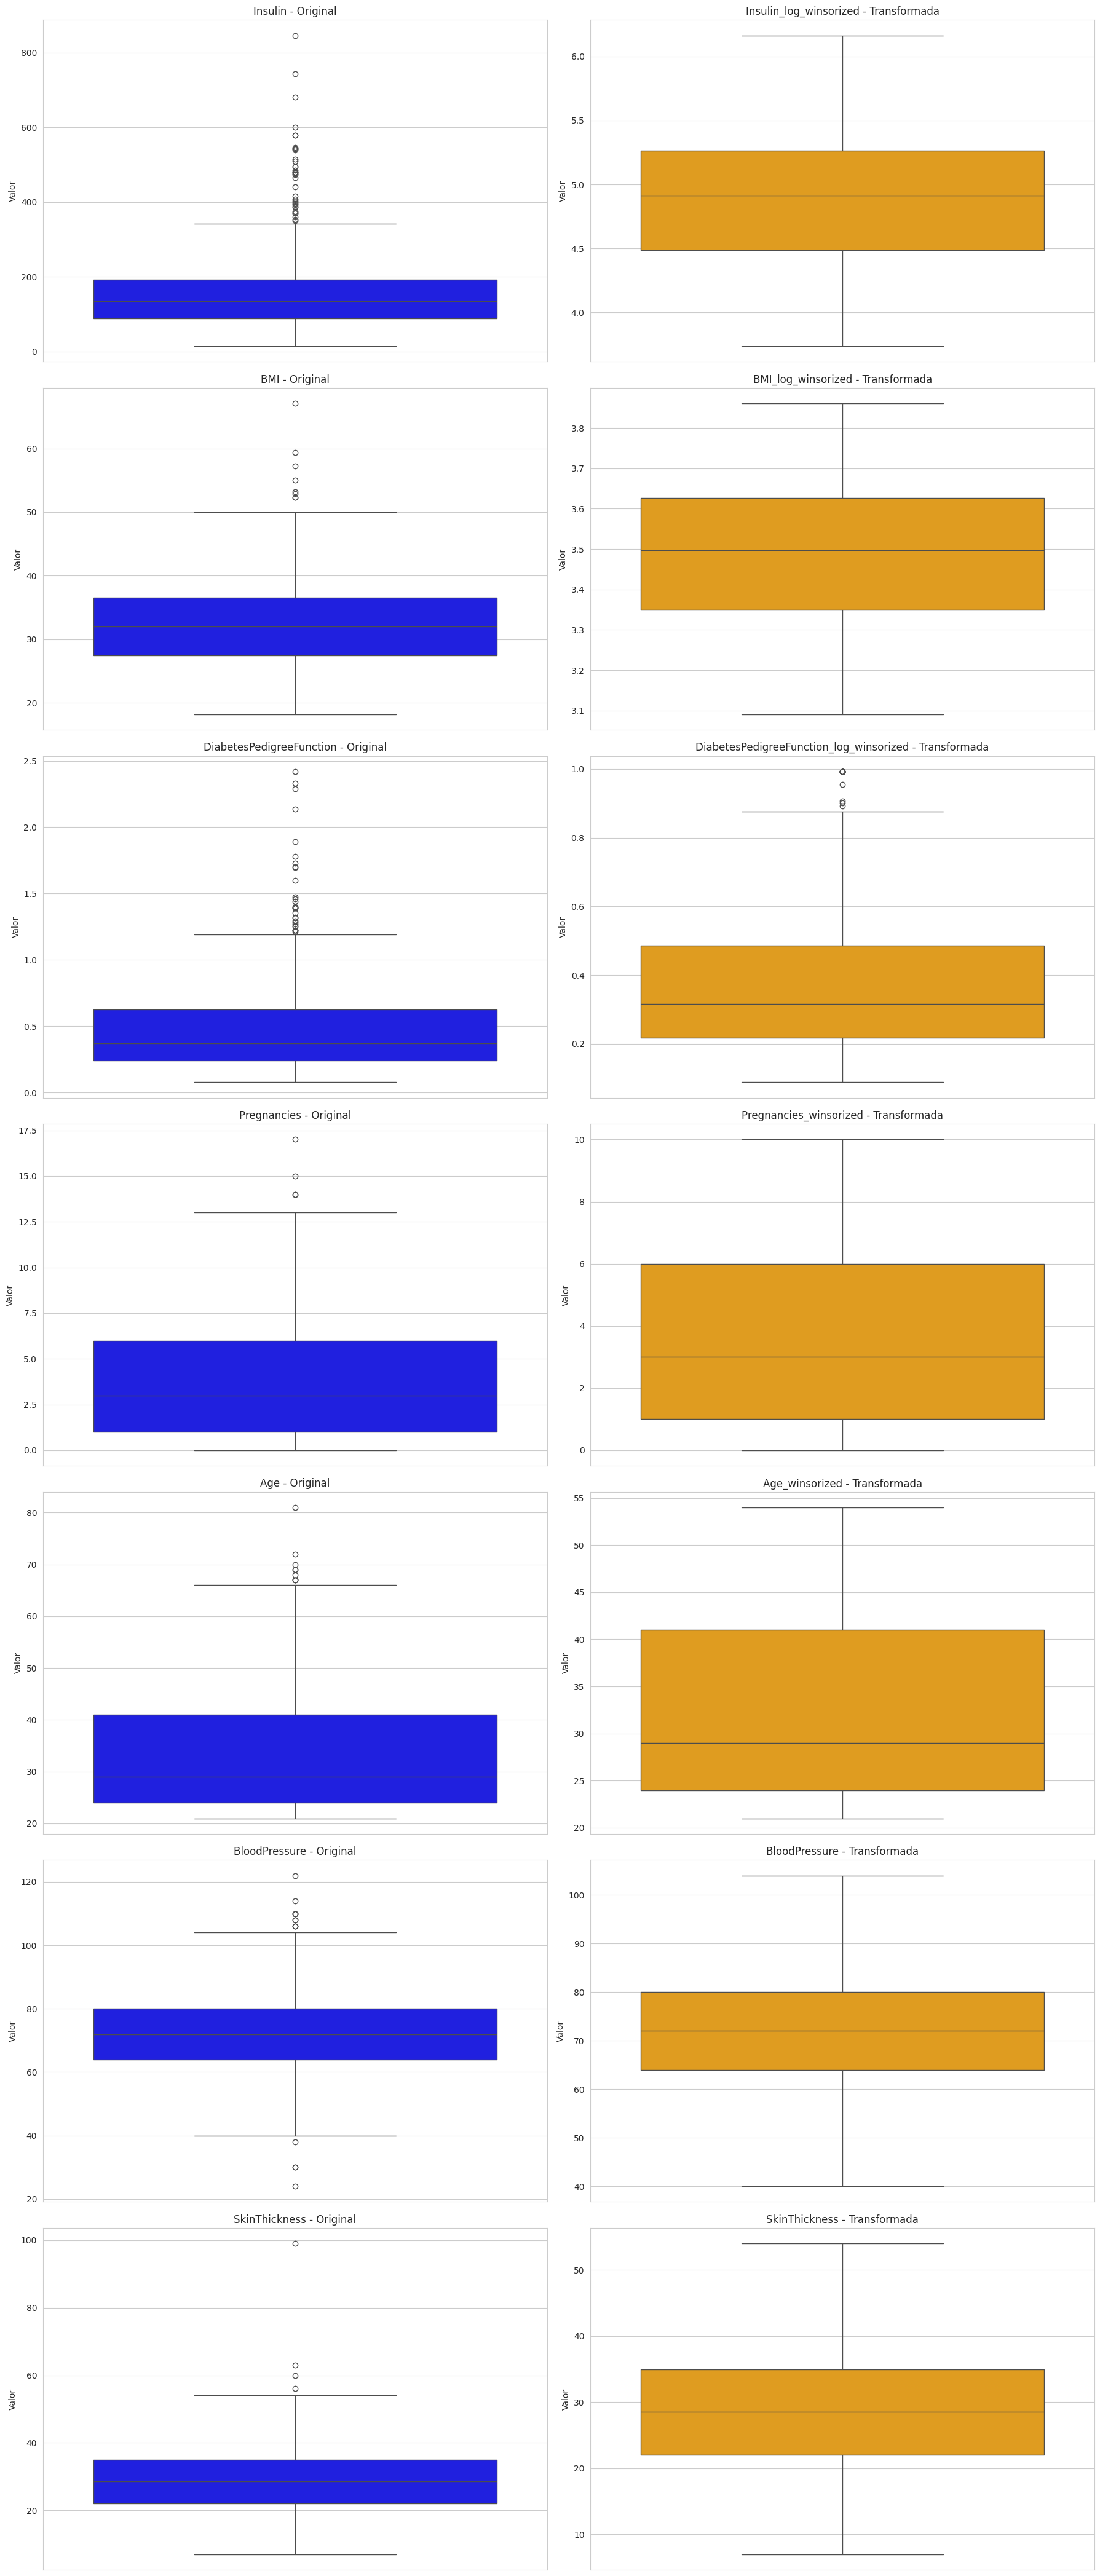

In [ ]:
# Visulizamos transformaciones
# Lista de variables a visualizar
variables_a_visualizar = {
    'Insulin': ('Insulin', 'Insulin_log_winsorized'),
    'BMI': ('BMI', 'BMI_log_winsorized'),
    'DiabetesPedigreeFunction': ('DiabetesPedigreeFunction', 'DiabetesPedigreeFunction_log_winsorized'),
    'Pregnancies': ('Pregnancies', 'Pregnancies_winsorized'),
    'Age': ('Age', 'Age_winsorized'),
    'BloodPressure': ('BloodPressure', 'BloodPressure'),
    'SkinThickness': ('SkinThickness', 'SkinThickness')
}

# Crear subplots
fig, axes = plt.subplots(len(variables_a_visualizar), 2, figsize=(18, 6 * len(variables_a_visualizar)))

# Iterar sobre las variables y crear los gráficos
for i, (var, (var_original, var_transformada)) in enumerate(variables_a_visualizar.items()):
    # Histograma de la variable original
    sns.histplot(df_cleaned[var_original], kde=True, color='blue', ax=axes[i, 0])
    axes[i, 0].set_title(f'{var_original} - Original')
    axes[i, 0].set_xlabel('Valor')
    axes[i, 0].set_ylabel('Frecuencia')

    # Histograma de la variable transformada
    sns.histplot(df_final_adjusted[var_transformada], kde=True, color='orange', ax=axes[i, 1])
    axes[i, 1].set_title(f'{var_transformada} - Transformada')
    axes[i, 1].set_xlabel('Valor')
    axes[i, 1].set_ylabel('Frecuencia')

plt.tight_layout()
plt.show()

fig, axes = plt.subplots(len(variables_a_visualizar), 2, figsize=(18, 6 * len(variables_a_visualizar)))

# Iterar sobre las variables y crear los gráficos
for i, (var, (var_original, var_transformada)) in enumerate(variables_a_visualizar.items()):
    # Boxplot de la variable original
    sns.boxplot(y=df_cleaned[var_original], color='blue', ax=axes[i, 0])
    axes[i, 0].set_title(f'{var_original} - Original')
    axes[i, 0].set_ylabel('Valor')

    # Boxplot de la variable transformada
    sns.boxplot(y=df_final_adjusted[var_transformada], color='orange', ax=axes[i, 1])
    axes[i, 1].set_title(f'{var_transformada} - Transformada')
    axes[i, 1].set_ylabel('Valor')

plt.tight_layout()
plt.show()


In [ ]:
print(df_final_adjusted.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 17 columns):
 #   Column                                   Non-Null Count  Dtype  
---  ------                                   --------------  -----  
 0   Pregnancies                              768 non-null    int64  
 1   Glucose                                  768 non-null    int64  
 2   BloodPressure                            768 non-null    float64
 3   SkinThickness                            768 non-null    float64
 4   Insulin                                  768 non-null    float64
 5   BMI                                      768 non-null    float64
 6   DiabetesPedigreeFunction                 768 non-null    float64
 7   Age                                      768 non-null    int64  
 8   Outcome                                  768 non-null    int64  
 9   Insulin_log                              768 non-null    float64
 10  Insulin_log_winsorized                   768 non-n

In [ ]:
# Crear una copia de df_final_adjusted
df_imputed = df_final_adjusted.copy()

# Eliminar las columnas originales de las variables transformadas
df_imputed.drop(['Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Pregnancies', 'Age'], axis=1, inplace=True)

# Eliminar las columnas log sin winsorización
df_imputed.drop(['Insulin_log', 'BMI_log', 'DiabetesPedigreeFunction_log'], axis=1, inplace=True)

print(df_imputed.columns)


Index(['Glucose', 'BloodPressure', 'SkinThickness', 'Outcome',
       'Insulin_log_winsorized', 'BMI_log_winsorized',
       'DiabetesPedigreeFunction_log_winsorized', 'Pregnancies_winsorized',
       'Age_winsorized'],
      dtype='object')


Al aplicar una combinación de transformaciones logarítmicas, winsorización e imputación, hemos logrado controlar los valores extremos mientras se conservaba la forma general de las distribuciones. Nuestros datos están ahora más limpios y preparados para los siguientes pasos del proceso de modelado.

---

# 5. PREPARACIÓN Y DIVISIÓN DE LOS DATOS

- En este notebook no crearemos nuevas características
- Prepararemos los datos en X (variables predictoras) e y (variable objetivo).
- Dividiremos los datos en X_train, X_test, y_train, y_test utilizando train_test_split.
- Haremos la selección de características
- Escalado: Aplicaremos StandardScaler a las variables numéricas de X_train y X_test. Es crucial escalar después de la división para evitar data leakage. Usaremos únicamente X_train para calcular los parámetros del escalador (media y desviación estándar para StandardScaler). Utilizaremos el mismo escalador ajustado con X_train para transformar X_validation y X_test. Esto asegura que todos los conjuntos de datos se escalen de manera consistente, usando las estadísticas del conjunto de entrenamiento.
- Manejo del desbalance: Aplicaremos SMOTE (Synthetic Minority Over-sampling Technique) solo a X_train e y_train. Esto generará muestras sintéticas de la clase minoritaria para equilibrar el dataset. No aplicaremos SMOTE a los datos de prueba para mantener su distribución original.
Este enfoque asegura que nuestro modelo se entrene con datos balanceados y escalados correctamente, mientras mantenemos un conjunto de prueba representativo de la distribución real del problema.

## Selección de características

Dividimos primero los datos para evitar el data leakage. Si seleccionamos las características usando todo el conjunto de datos y luego lo dividimos, se estaría filtrando información del conjunto de prueba al de entrenamiento.

La selección de características debe realizarse solo en el conjunto de entrenamiento para asegurar que el conjunto de prueba permanezca completamente independiente y no influya en el proceso de modelado.

Utilizaremos varios métodos de selección de características. Estos métodos se pueden clasificar en tres categorías principales:

- Métodos de filtrado: Estos métodos seleccionan características basándose en medidas estadísticas, sin utilizar ningún modelo de aprendizaje.
  - Correlación de Pearson: Este método mide la correlación lineal entre cada característica y la variable objetivo. Las características con mayor correlación absoluta se consideran más importantes.
  - Información mutua: Utiliza la función mutual_info_classif para medir la dependencia entre cada característica y la variable objetivo. Se seleccionan las 10 características con mayor información mutua.
  - Chi-cuadrado: Este método es especialmente útil para características categóricas. Se utiliza SelectKBest con la función chi2 para seleccionar las 10 mejores características según esta prueba estadística.
- Métodos de envoltura: Estos métodos utilizan un modelo de aprendizaje automático para evaluar subconjuntos de características.
  - Eliminación de características recursivas (RFE): Este método utiliza un modelo (en este caso, RandomForestClassifier) para eliminar recursivamente las características menos importantes hasta que queden solo 10.
- Métodos incorporados: Estos métodos realizan la selección de características como parte del proceso de entrenamiento del modelo.
  - LASSO (Least Absolute Shrinkage and Selection Operator): Este método de regularización L1 puede reducir algunos coeficientes a cero, efectivamente seleccionando características. Las características con coeficientes no nulos son seleccionadas.
  - Importancia de características en Random Forest: Este método utiliza la importancia de características inherente al algoritmo Random Forest. Se seleccionan las 10 características más importantes según este criterio.


Cada uno de estos métodos proporciona una perspectiva diferente sobre la importancia de las características, lo que permite una selección más robusta y completa para el modelo final.

A continuación realizaremos un análisis de la frecuencia de las características seleccionadas por los diferentes métodos de selección de características. Escogeremos las características que han sido seleccionadas como más importantes por al menos 3 metodos de selección.

In [ ]:
# Preparar X e y
X = df_imputed.drop('Outcome', axis=1)
y = df_imputed['Outcome']

print("X shape:", X.shape)
print("Preview of X:", X.head())

# Dividir los datos en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# Métodos de filtrado:
# 1. Correlación de Pearson
corr_features = X_train.corrwith(y_train).abs().sort_values(ascending=False)

# 2. Información Mutua
mi_selector = SelectKBest(mutual_info_classif, k=10)
mi_selector.fit(X_train, y_train)
mi_features = X_train.columns[mi_selector.get_support()]

# 3. Chi-cuadrado (requiere valores no negativos)
chi2_selector = SelectKBest(chi2, k=10)
X_train_non_negative = X_train.clip(lower=0)  # Asegurarse de que no haya valores negativos
chi2_selector.fit(X_train_non_negative, y_train)
chi2_features = X_train.columns[chi2_selector.get_support()]

# Métodos de envoltura:
# 4. Eliminación de características recursivas (RFE) con Random Forest
rfe_selector = RFE(estimator=RandomForestClassifier(random_state=42), n_features_to_select=10)
rfe_selector.fit(X_train, y_train)
rfe_features = X_train.columns[rfe_selector.support_]

# Métodos incorporados:
# 5. LASSO (Regularización L1)
lasso = Lasso(alpha=0.1, random_state=42)  # Ajustar alpha según sea necesario
lasso.fit(X_train, y_train)
lasso_features = X_train.columns[lasso.coef_ != 0]

# 6. Importancia de características en Random Forest
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train)
rf_features = X_train.columns[rf.feature_importances_.argsort()[::-1][:10]]

# Imprimir las características seleccionadas por cada método
print("Pearson Correlation:", list(corr_features.index[:10]))
print("Mutual Information:", list(mi_features))
print("Chi-square:", list(chi2_features))
print("RFE:", list(rfe_features))
print("LASSO:", list(lasso_features))
print("Random Forest:", list(rf_features))

# Analizar la frecuencia de las características seleccionadas por los diferentes métodos
all_features = (
    list(corr_features.index[:10]) +
    list(mi_features) +
    list(chi2_features) +
    list(rfe_features) +
    list(lasso_features) +
    list(rf_features)
)

feature_counts = Counter(all_features)

print("\nFrecuencia de características seleccionadas:")
for feature, count in feature_counts.most_common():
    print(f"{feature}: {count}")


X shape: (768, 8)
Preview of X:    Glucose  BloodPressure  SkinThickness  Insulin_log_winsorized  \
0      148           72.0      35.000000                5.181109   
1       85           66.0      29.000000                3.954124   
2      183           64.0      18.182514                5.577047   
3       89           66.0      23.000000                4.553877   
4      137           40.0      35.000000                5.129899   

   BMI_log_winsorized  DiabetesPedigreeFunction_log_winsorized  \
0            3.543854                                 0.486738   
1            3.317816                                 0.300845   
2            3.190476                                 0.514021   
3            3.370738                                 0.154436   
4            3.786460                                 0.992881   

   Pregnancies_winsorized  Age_winsorized  
0                       6              50  
1                       1              31  
2                       8     

In [ ]:
# Definir umbral para seleccionar las características finales (seleccionadas por todos los métodos)
selected_features = [feature for feature, count in feature_counts.items() if count >= 6]

X_selected = df_imputed[selected_features]
y_selected = df_imputed['Outcome']

# Verificar el nuevo conjunto de datos
print("Características seleccionadas:", selected_features)
print("Shape del nuevo conjunto:", X_selected.shape)
print("Primeras filas del nuevo conjunto:")
print(X_selected.head())


Características seleccionadas: ['Glucose', 'Age_winsorized', 'SkinThickness', 'Pregnancies_winsorized', 'BloodPressure']
Shape del nuevo conjunto: (768, 5)
Primeras filas del nuevo conjunto:
   Glucose  Age_winsorized  SkinThickness  Pregnancies_winsorized  \
0      148              50      35.000000                       6   
1       85              31      29.000000                       1   
2      183              32      18.182514                       8   
3       89              21      23.000000                       1   
4      137              33      35.000000                       0   

   BloodPressure  
0           72.0  
1           66.0  
2           64.0  
3           66.0  
4           40.0  


El nuevo DataFrame tiene 768 filas y 10 columnas, lo cual es razonable considerando que hemos reducido el número de características a las más importantes.

Esto simplifica el análisis y mejora la eficiencia del modelo al trabajar con un conjunto optimizado.

---

# 6. ENTRENAMIENTO DE LOS MODELOS
La estrategia que seguiré en este paso de entrenamiento es la siguiente:

Entrenaremos varios modelos de aprendizaje automático utilizando la división de los datos en entrenamiento y prueba.
Evaluaremos los resultados obtenidos y escogeremos el modelo que mejores resultados presente.
Una vez escogido el modelo ganador, repetiremos el entrenamiento en este modelo aplicando validación cruzada (cross-validation). De esta manera, los resultados serán más robustos y más representativos del rendimiento real del modelo en datos no vistos.


Vamos a entrenar los siguientes modelos:
- Regresión Logística: Aunque no es inherentemente robusto frente a outliers, su simplicidad permite identificar rápidamente patrones generales en los datos. Además, puede servir como punto de comparación para evaluar la efectividad de los modelos más complejos.
- Random Forest: Robusto ante outliers y capaz de capturar relaciones no lineales.
Gradient Boosting: Potente en la captura de patrones complejos y generalmente ofrece alto rendimiento.
- Support Vector Machines (SVM) con kernel no lineal: Eficaz en la separación de clases en espacios de alta dimensión.
- XGBoost: Conocido por su alto rendimiento en una variedad de problemas de clasificación.
- Red Neuronal: Capaz de aprender representaciones complejas de los datos.
Esta variedad de modelos nos permitirá explorar diferentes enfoques y determinar cuál se adapta mejor a la estructura y características de nuestros datos de Framingham.

Además vamos a probar diferentes estrategias.
- Entrenaminto sin reducción de la dimensionalidad
- PCA para reducir la dimensión de los datos
- Selección de características con Random Forest
- Otras tecnicas de balanceo de clases como : SMOTETomek, Adasy y Borderline-SMOTE



### PRIMER ENTRENAMIENTO SIN PCA, NI SELECCION DE CARACTERISTICAS

División de datos: Usando train_test_split, con un 70% para entrenamiento y 30% para prueba.
Escalado de datos: Utilizamos StandardScaler para estandarizar las características, ajustando el escalador con X_train y transformando tanto X_train como X_test.
Balanceo de clases con SMOTE: Aplicamos SMOTE al conjunto de entrenamiento escalado (X_train_scaled) para generar nuevas muestras sintéticas de la clase minoritaria, obteniendo X_train_smote y y_train_smote.


Definición de modelos:
- Regresión Logística
- Bosque Aleatorio
- Gradient Boosting
- Máquinas de Vectores de Soporte (SVM)
- XGBoost
- Red Neuronal Multicapa


Entrenamiento y evaluación de modelos: Se entrena cada modelo con los datos balanceados (X_train_smote, y_train_smote). Se realizan predicciones en el conjunto de prueba escalado (X_test_scaled).

Se calculan las métricas de evaluación: Reporte de clasificación (classification_report) Matriz de confusión (confusion_matrix) Curva ROC y AUC (roc_curve, auc)

Visualización de resultados Generamos gráficos de matrices de confusión para cada modelo usando seaborn. Graficamos las curvas ROC para todos los modelos en una sola figura. Por último comparamos las métricas de precisión, recall y f1-score para la clase positiva (1) entre los modelos, y se representan en un gráfico de barras.


Training Logistic Regression...
Classification Report for Logistic Regression:
              precision    recall  f1-score   support

           0       0.84      0.77      0.80       150
           1       0.63      0.73      0.67        81

    accuracy                           0.75       231
   macro avg       0.73      0.75      0.74       231
weighted avg       0.77      0.75      0.76       231


Training Random Forest...
Classification Report for Random Forest:
              precision    recall  f1-score   support

           0       0.79      0.81      0.80       150
           1       0.63      0.60      0.62        81

    accuracy                           0.74       231
   macro avg       0.71      0.71      0.71       231
weighted avg       0.73      0.74      0.73       231


Training Gradient Boosting...
Classification Report for Gradient Boosting:
              precision    recall  f1-score   support

           0       0.79      0.76      0.78       150
           1 

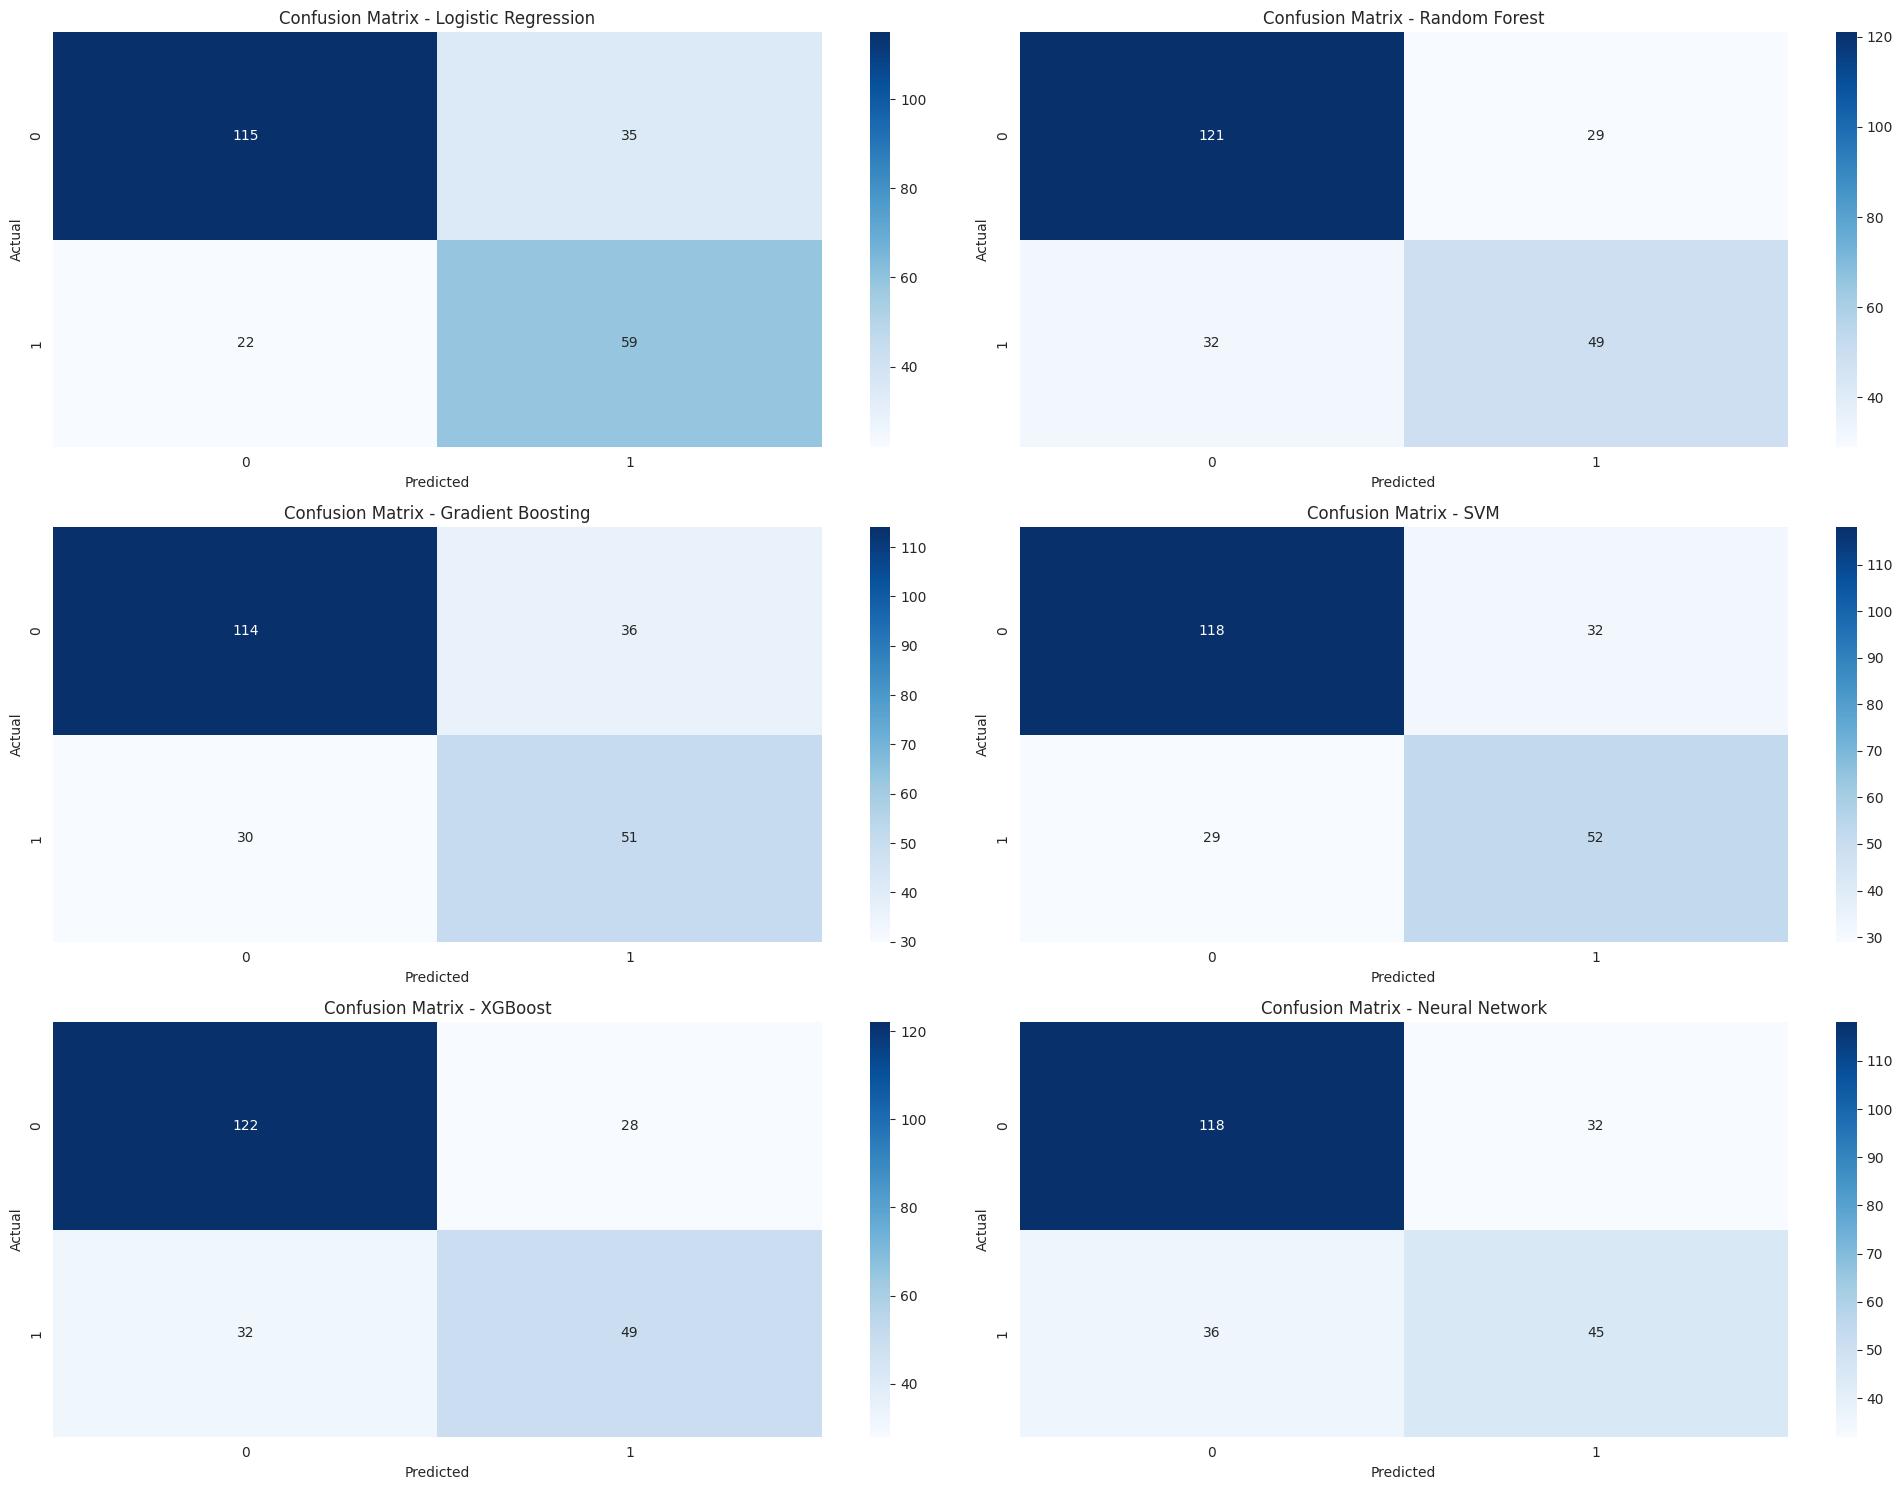

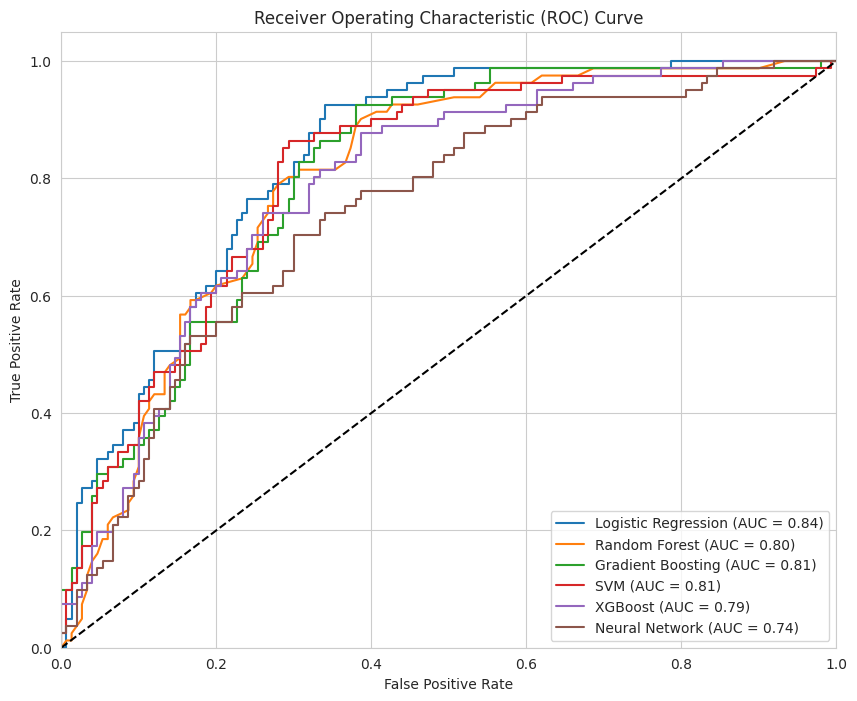

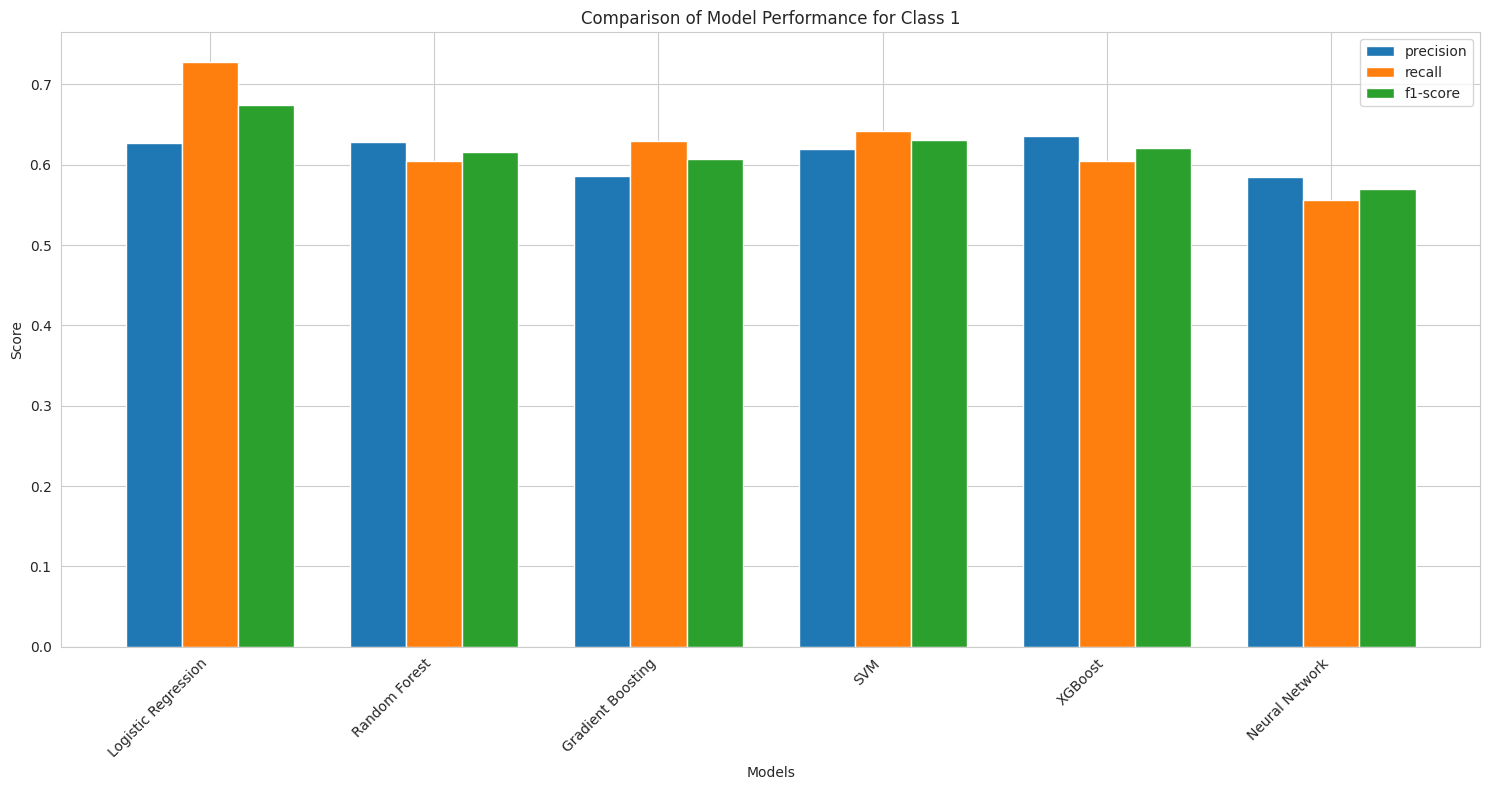

In [ ]:
# 1. Preparar los datos
# Definiendo X e y a partir del DataFrame con menos características
X = df_imputed[selected_features]
y = df_imputed['Outcome']

# 2. Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# 3. Escalar los datos
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 4. Balancear las clases con SMOTE
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train_scaled, y_train)

# 5. Definir los modelos
models = {
    'Logistic Regression': LogisticRegression(random_state=42, max_iter=1000),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(random_state=42),
    'SVM': SVC(kernel='rbf', probability=True, random_state=42),
    'XGBoost': XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42),
    'Neural Network': MLPClassifier(hidden_layer_sizes=(100, 50), max_iter=500, random_state=42)
}

# 6. Entrenar y evaluar cada modelo
results = {}

for name, model in models.items():
    print(f"\nTraining {name}...")

    # Entrenar el modelo con datos balanceados
    model.fit(X_train_smote, y_train_smote)

    # Predecir en el conjunto de prueba original
    y_pred = model.predict(X_test_scaled)
    y_prob = model.predict_proba(X_test_scaled)[:, 1]

    # Calcular métricas
    report = classification_report(y_test, y_pred, output_dict=True)
    conf_matrix = confusion_matrix(y_test, y_pred)
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    roc_auc = auc(fpr, tpr)

    # Guardar resultados
    results[name] = {
        'report': report,
        'conf_matrix': conf_matrix,
        'fpr': fpr,
        'tpr': tpr,
        'roc_auc': roc_auc
    }

    # Imprimir reporte de clasificación
    print(f"Classification Report for {name}:")
    print(classification_report(y_test, y_pred))

# Visualizar resultados
plt.figure(figsize=(20, 15))

# Matrices de confusión
for i, (name, result) in enumerate(results.items()):
    plt.subplot(3, 2, i+1)
    sns.heatmap(result['conf_matrix'], annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix - {name}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')

plt.tight_layout()
plt.show()

# Curvas ROC
plt.figure(figsize=(10, 8))
for name, result in results.items():
    plt.plot(result['fpr'], result['tpr'], label=f'{name} (AUC = {result["roc_auc"]:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

# Comparación de métricas
metrics = ['precision', 'recall', 'f1-score']
model_names = list(results.keys())
metric_values = {metric: [results[model]['report']['1'][metric] for model in model_names] for metric in metrics}

plt.figure(figsize=(15, 8))
x = np.arange(len(model_names))
width = 0.25

for i, metric in enumerate(metrics):
    plt.bar(x + i*width, metric_values[metric], width, label=metric)

plt.xlabel('Models')
plt.ylabel('Score')
plt.title('Comparison of Model Performance for Class 1')
plt.xticks(x + width, model_names, rotation=45, ha='right')
plt.legend()
plt.tight_layout()
plt.show()


**1. Matrices de confusión (Resumen)**
- **Clase 0 (No diabetes):**
  - Los modelos clasifican correctamente la mayoría de los casos en esta clase (precisión cercana al 80%).
- **Clase 1 (Diabetes):**
  - La clase minoritaria tiene un rendimiento más bajo, con recalls que varían entre el 56% y el 73%.
- **Mejor modelo:**  
  - **Logistic Regression**: Clasifica correctamente más casos positivos (59) en comparación con otros modelos.

**2. Curvas ROC**
- **AUC-ROC:**
  - **Logistic Regression** tiene el mejor AUC (0.84), lo que indica una buena capacidad para distinguir entre las clases.
  - **Random Forest, Gradient Boosting y SVM** tienen AUC similares (~0.81), lo que los hace competitivos.
  - **Neural Network** tiene el AUC más bajo (0.74), lo que indica un rendimiento inferior.

**3. Comparación de métricas**
- **Logistic Regression:**
  - Mejor equilibrio entre precisión, recall y F1-score para la clase minoritaria.
- **Random Forest y SVM:**
  - Buen rendimiento general, pero ligeramente inferiores a Logistic Regression en recall.
- **Neural Network:**
  - Peor rendimiento en todas las métricas para la clase minoritaria.

**Conclusión**
1. El mejor modelo es **Logistic Regression**, ya que ofrece un buen equilibrio entre todas las métricas clave.
2. Modelos alternativos como **Random Forest** y **SVM** también son competitivos.
3. Se recomienda optimizar Logistic Regression para mejorar aún más su rendimiento.


### ENTRENAMIENTO CON REDUCCIÓN DE DIMENSIONALIDAD CON PCA
En este caso, añadiremos el Análisis de Componentes Principales (PCA) al pipeline.

Aplicamos PCA para reducir la dimensionalidad, manteniendo el 95% de la varianza.
El PCA lo aplicamos únicamente al conjunto de entrenamiento. Esto se debe a que el PCA calcula los componentes principales basándose en la varianza de los datos, y estos cálculos deben realizarse solo con los datos de entrenamiento.

Para el conjunto de prueba, utilizamos los mismos componentes principales calculados con el conjunto de entrenamiento. Es decir, no se debe calcular un nuevo PCA para los datos de prueba, sino que se deben proyectar estos datos utilizando la transformación PCA obtenida del conjunto de entrenamiento


Training Logistic Regression...
Classification Report for Logistic Regression:
              precision    recall  f1-score   support

           0       0.84      0.77      0.80       150
           1       0.63      0.73      0.67        81

    accuracy                           0.75       231
   macro avg       0.73      0.75      0.74       231
weighted avg       0.77      0.75      0.76       231


Training Random Forest...
Classification Report for Random Forest:
              precision    recall  f1-score   support

           0       0.79      0.77      0.78       150
           1       0.59      0.63      0.61        81

    accuracy                           0.72       231
   macro avg       0.69      0.70      0.70       231
weighted avg       0.72      0.72      0.72       231


Training Gradient Boosting...
Classification Report for Gradient Boosting:
              precision    recall  f1-score   support

           0       0.80      0.77      0.78       150
           1 

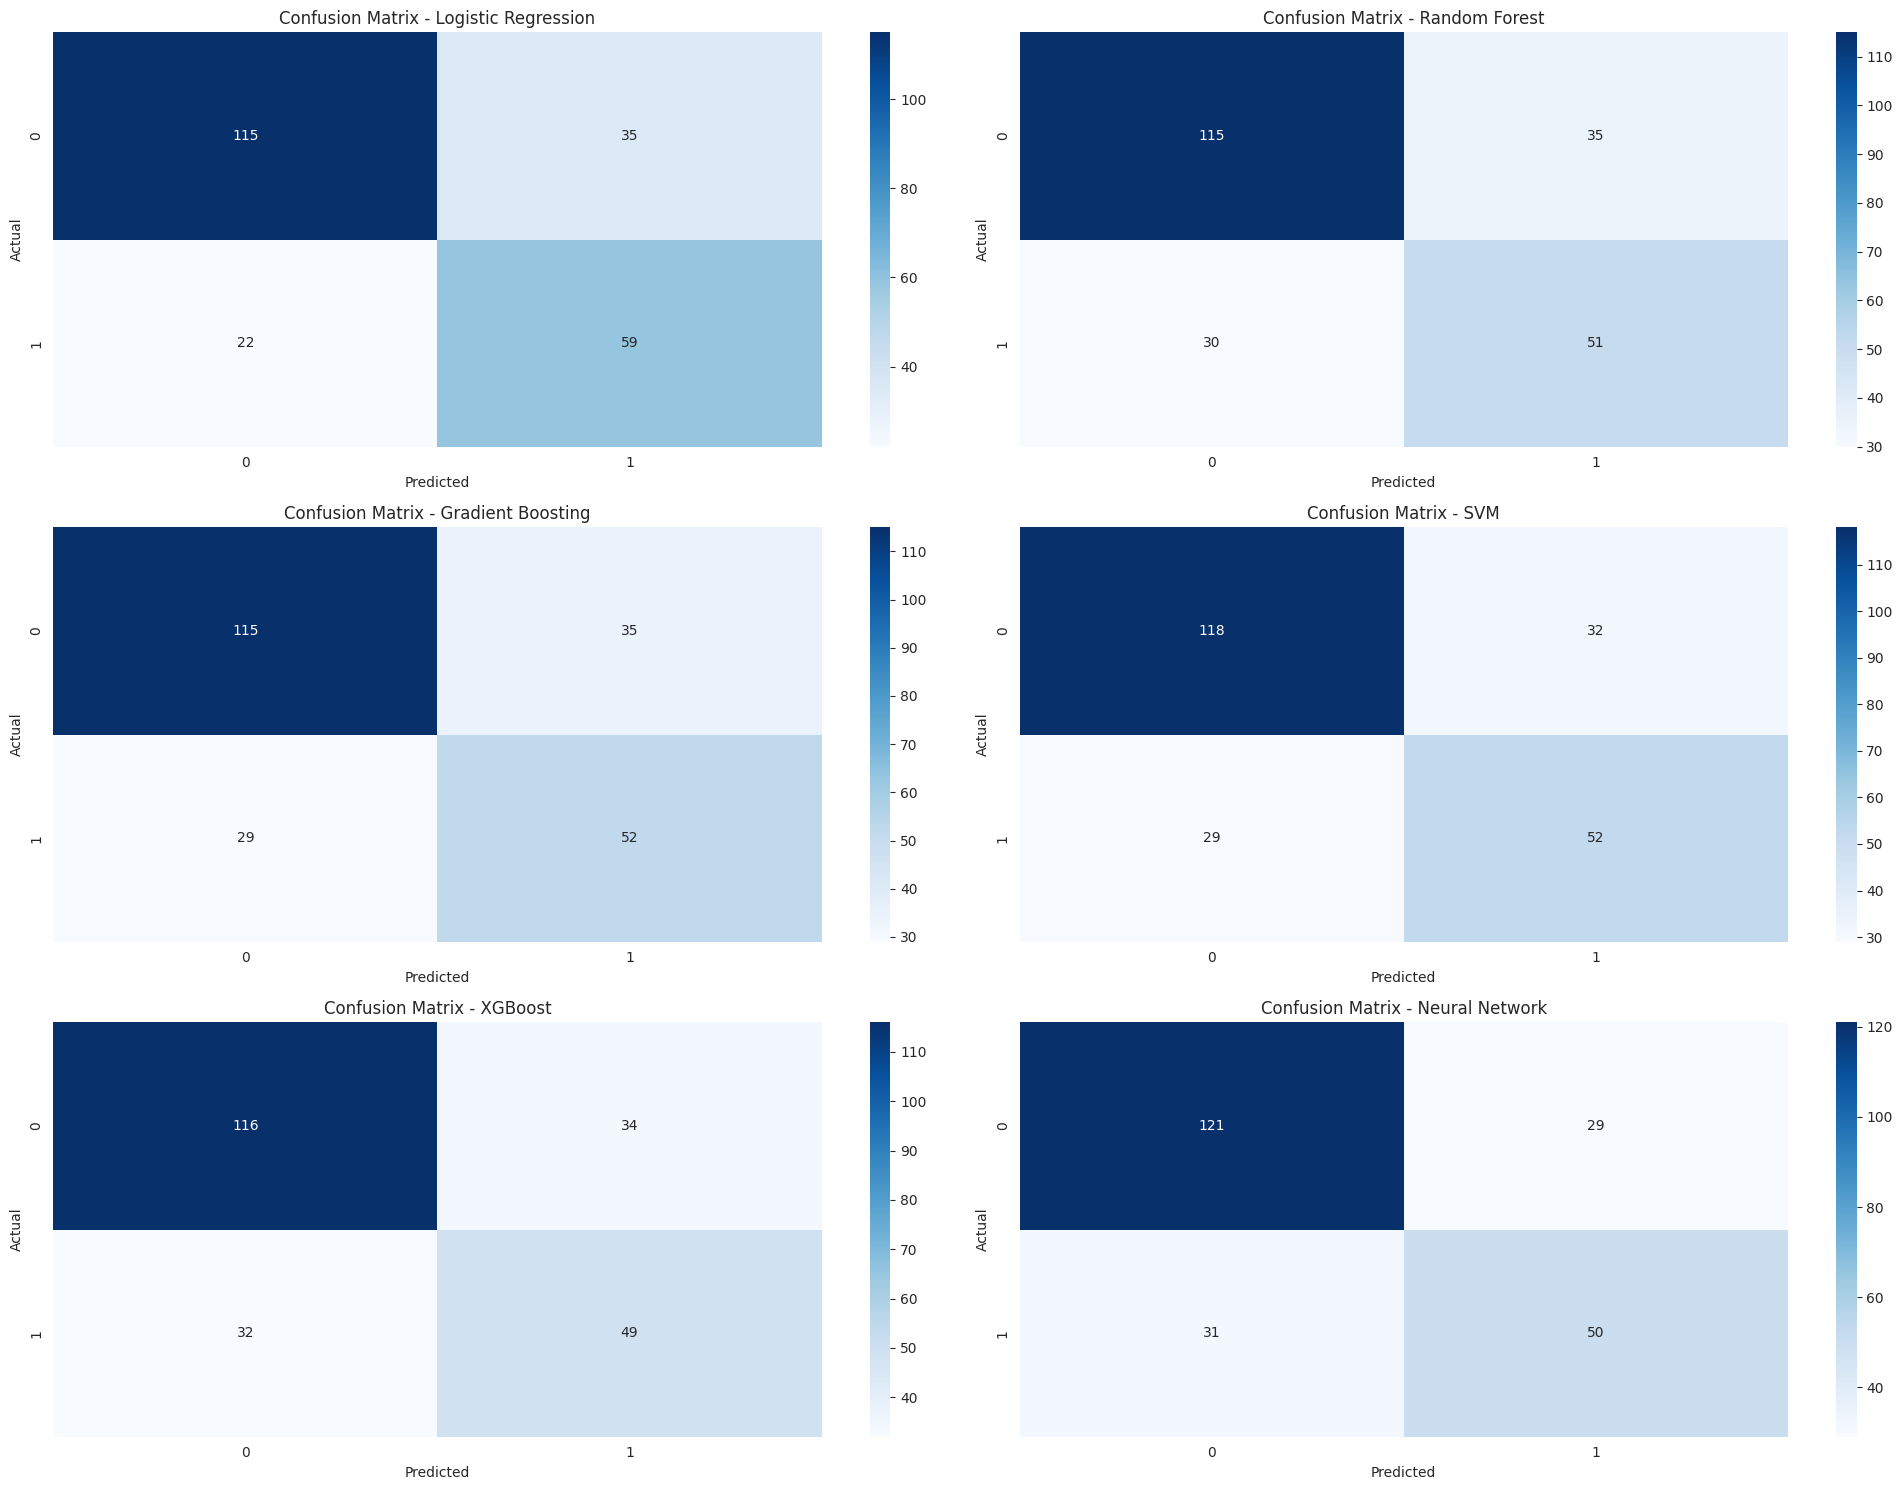

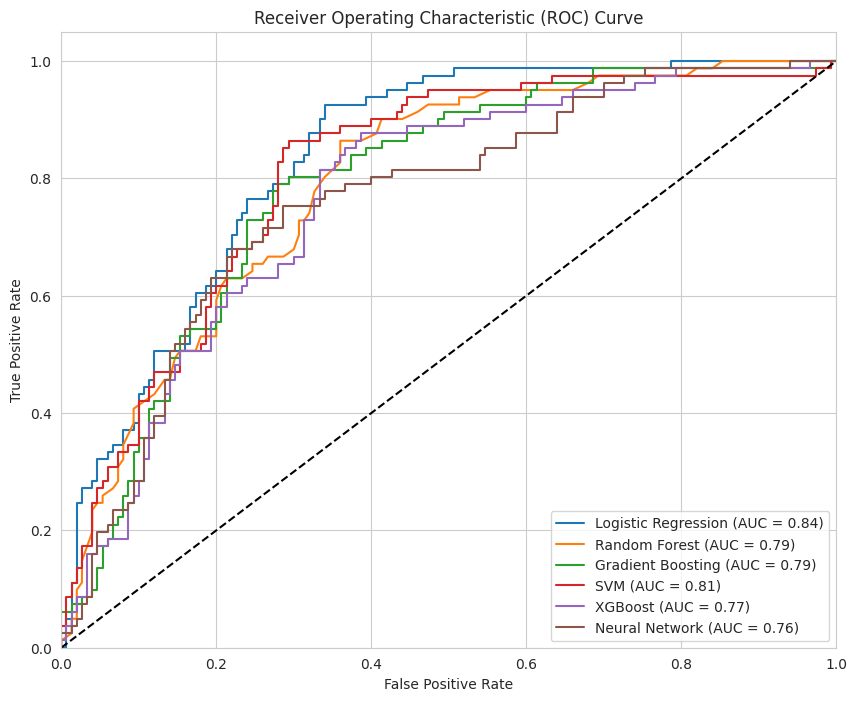

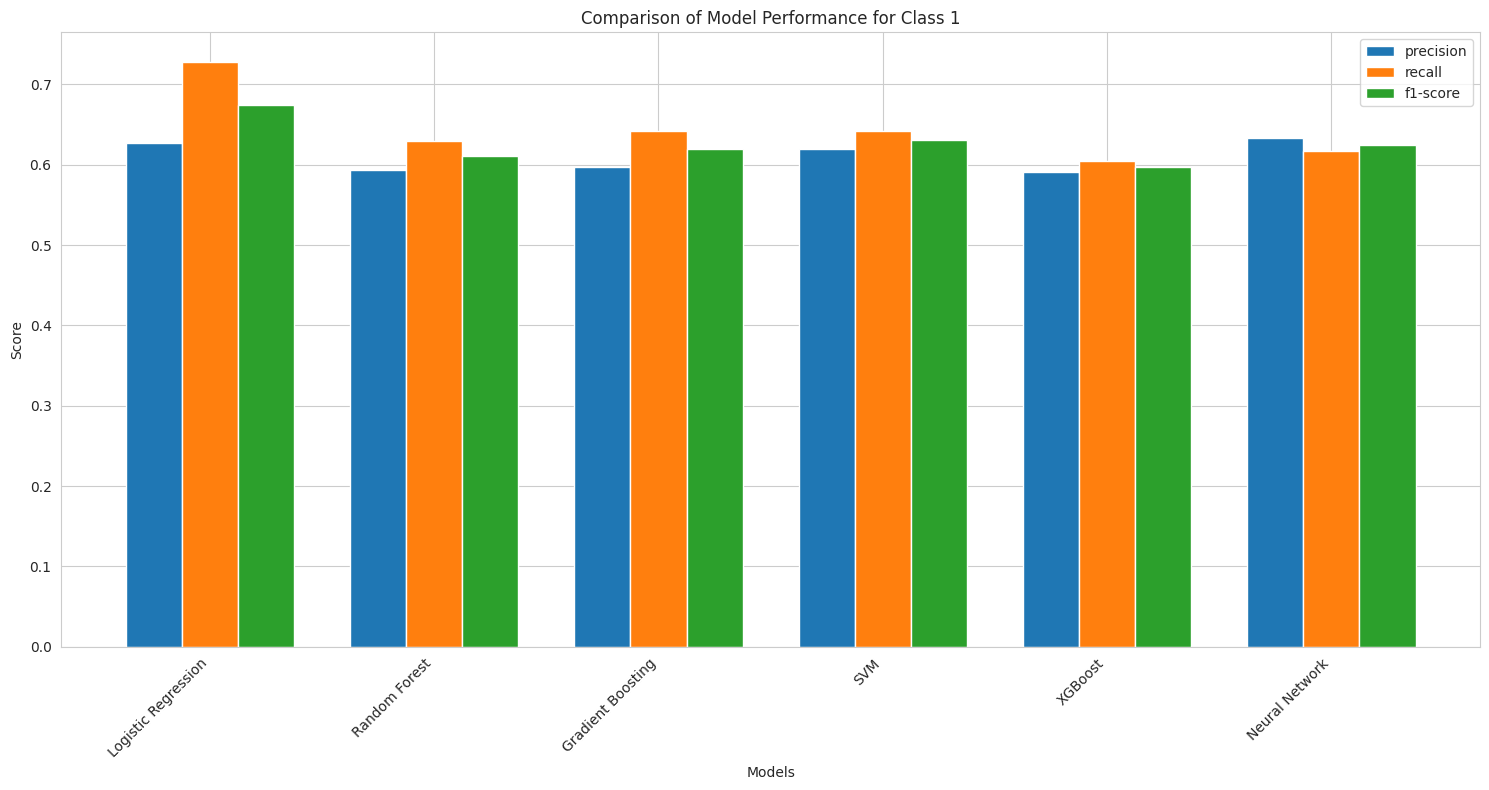

In [ ]:
# 1. Preparar los datos
X = df_imputed[selected_features]
y = df_imputed['Outcome']

# 2. Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# 3. Escalar los datos
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 4. Aplicar PCA para reducir la dimensionalidad
pca = PCA(n_components=0.95, random_state=42)  # Mantenemos el 95% de la varianza
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

# 5. Balancear las clases con SMOTE
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train_pca, y_train)

# 6. Definir los modelos
models = {
    'Logistic Regression': LogisticRegression(random_state=42),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(random_state=42),
    'SVM': SVC(kernel='rbf', probability=True, random_state=42),
    'XGBoost': XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42),
    'Neural Network': MLPClassifier(hidden_layer_sizes=(100, 50), max_iter=500, random_state=42)
}

# 7. Entrenar y evaluar cada modelo
results = {}

for name, model in models.items():
    print(f"\nTraining {name}...")

    # Entrenar el modelo con datos balanceados y PCA
    model.fit(X_train_smote, y_train_smote)

    # Predecir en el conjunto de prueba original con PCA
    y_pred = model.predict(X_test_pca)
    y_prob = model.predict_proba(X_test_pca)[:, 1]

    # Calcular métricas
    report = classification_report(y_test, y_pred, output_dict=True)
    conf_matrix = confusion_matrix(y_test, y_pred)
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    roc_auc = auc(fpr, tpr)

    # Guardar resultados
    results[name] = {
        'report': report,
        'conf_matrix': conf_matrix,
        'fpr': fpr,
        'tpr': tpr,
        'roc_auc': roc_auc
    }

    # Imprimir reporte de clasificación
    print(f"Classification Report for {name}:")
    print(classification_report(y_test, y_pred))

# Visualizar resultados
plt.figure(figsize=(20, 15))

# Matrices de confusión
for i, (name, result) in enumerate(results.items()):
    plt.subplot(3, 2, i+1)
    sns.heatmap(result['conf_matrix'], annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix - {name}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')

plt.tight_layout()
plt.show()

# Curvas ROC
plt.figure(figsize=(10, 8))
for name, result in results.items():
    plt.plot(result['fpr'], result['tpr'], label=f'{name} (AUC = {result["roc_auc"]:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

# Comparación de métricas
metrics = ['precision', 'recall', 'f1-score']
model_names = list(results.keys())
metric_values = {metric: [results[model]['report']['1'][metric] for model in model_names] for metric in metrics}

plt.figure(figsize=(15, 8))
x = np.arange(len(model_names))
width = 0.25

for i, metric in enumerate(metrics):
    plt.bar(x + i*width, metric_values[metric], width, label=metric)

plt.xlabel('Models')
plt.ylabel('Score')
plt.title('Comparison of Model Performance for Class 1')
plt.xticks(x + width, model_names, rotation=45, ha='right')
plt.legend()
plt.tight_layout()
plt.show()


- Logistic Regression:
Este modelo sigue siendo uno de los mejores, con un AUC de 0.84 y un F1-score de 0.67 para la Clase 1. Su precisión (63%) y recall (73%) son equilibrados, lo que lo hace confiable para detectar casos positivos.

- Random Forest:
Tiene un AUC de 0.79 y un F1-score de 0.61 para la Clase 1. Aunque su rendimiento es sólido, pierde ligeramente frente a Logistic Regression debido a un recall más bajo (63%) y una precisión moderada (59%).

- Gradient Boosting:
Con un AUC de 0.79 y un F1-score de 0.62, este modelo muestra un rendimiento similar al de Random Forest. Su precisión (60%) y recall (64%) son aceptables, pero no sobresale frente a otros modelos.

- SVM:
SVM mantiene un AUC alto (0.81) y un F1-score de 0.63 para la Clase 1, con una precisión (62%) y recall (64%) consistentes. Es una alternativa sólida comparable a Logistic Regression.

- XGBoost:
Este modelo tiene un AUC de 0.77 y un F1-score de 0.60, mostrando una ligera caída en su capacidad para distinguir entre clases. Su precisión (59%) y recall (60%) son menores en comparación con otros modelos.

- Neural Network:
La red neuronal tiene un AUC de 0.76, ligeramente inferior al resto, pero logra un F1-score competitivo de 0.62 para la Clase 1, con precisión (63%) y recall (62%). Aunque mejora en términos generales, no supera a Logistic Regression ni SVM.

- Resumen General:
Logistic Regression y SVM destacan como los más equilibrados, con el mejor desempeño global en términos de AUC (0.84 y 0.81, respectivamente) y métricas consistentes para la Clase 1.


### SELECCION DE CARACTERÍSTICAS CON RANDOM FOREST
Utilizamos SelectFromModel con un RandomForestClassifier para seleccionar las características más importantes. Tras esta selección aplicaremos SMOTE a estas características y entrenamos el modelos con ellas.


Training Logistic Regression...
Classification Report for Logistic Regression:
              precision    recall  f1-score   support

           0       0.80      0.73      0.76       150
           1       0.56      0.65      0.61        81

    accuracy                           0.70       231
   macro avg       0.68      0.69      0.68       231
weighted avg       0.71      0.70      0.71       231


Training Random Forest...
Classification Report for Random Forest:
              precision    recall  f1-score   support

           0       0.75      0.81      0.78       150
           1       0.59      0.49      0.54        81

    accuracy                           0.70       231
   macro avg       0.67      0.65      0.66       231
weighted avg       0.69      0.70      0.69       231


Training Gradient Boosting...
Classification Report for Gradient Boosting:
              precision    recall  f1-score   support

           0       0.77      0.75      0.76       150
           1 

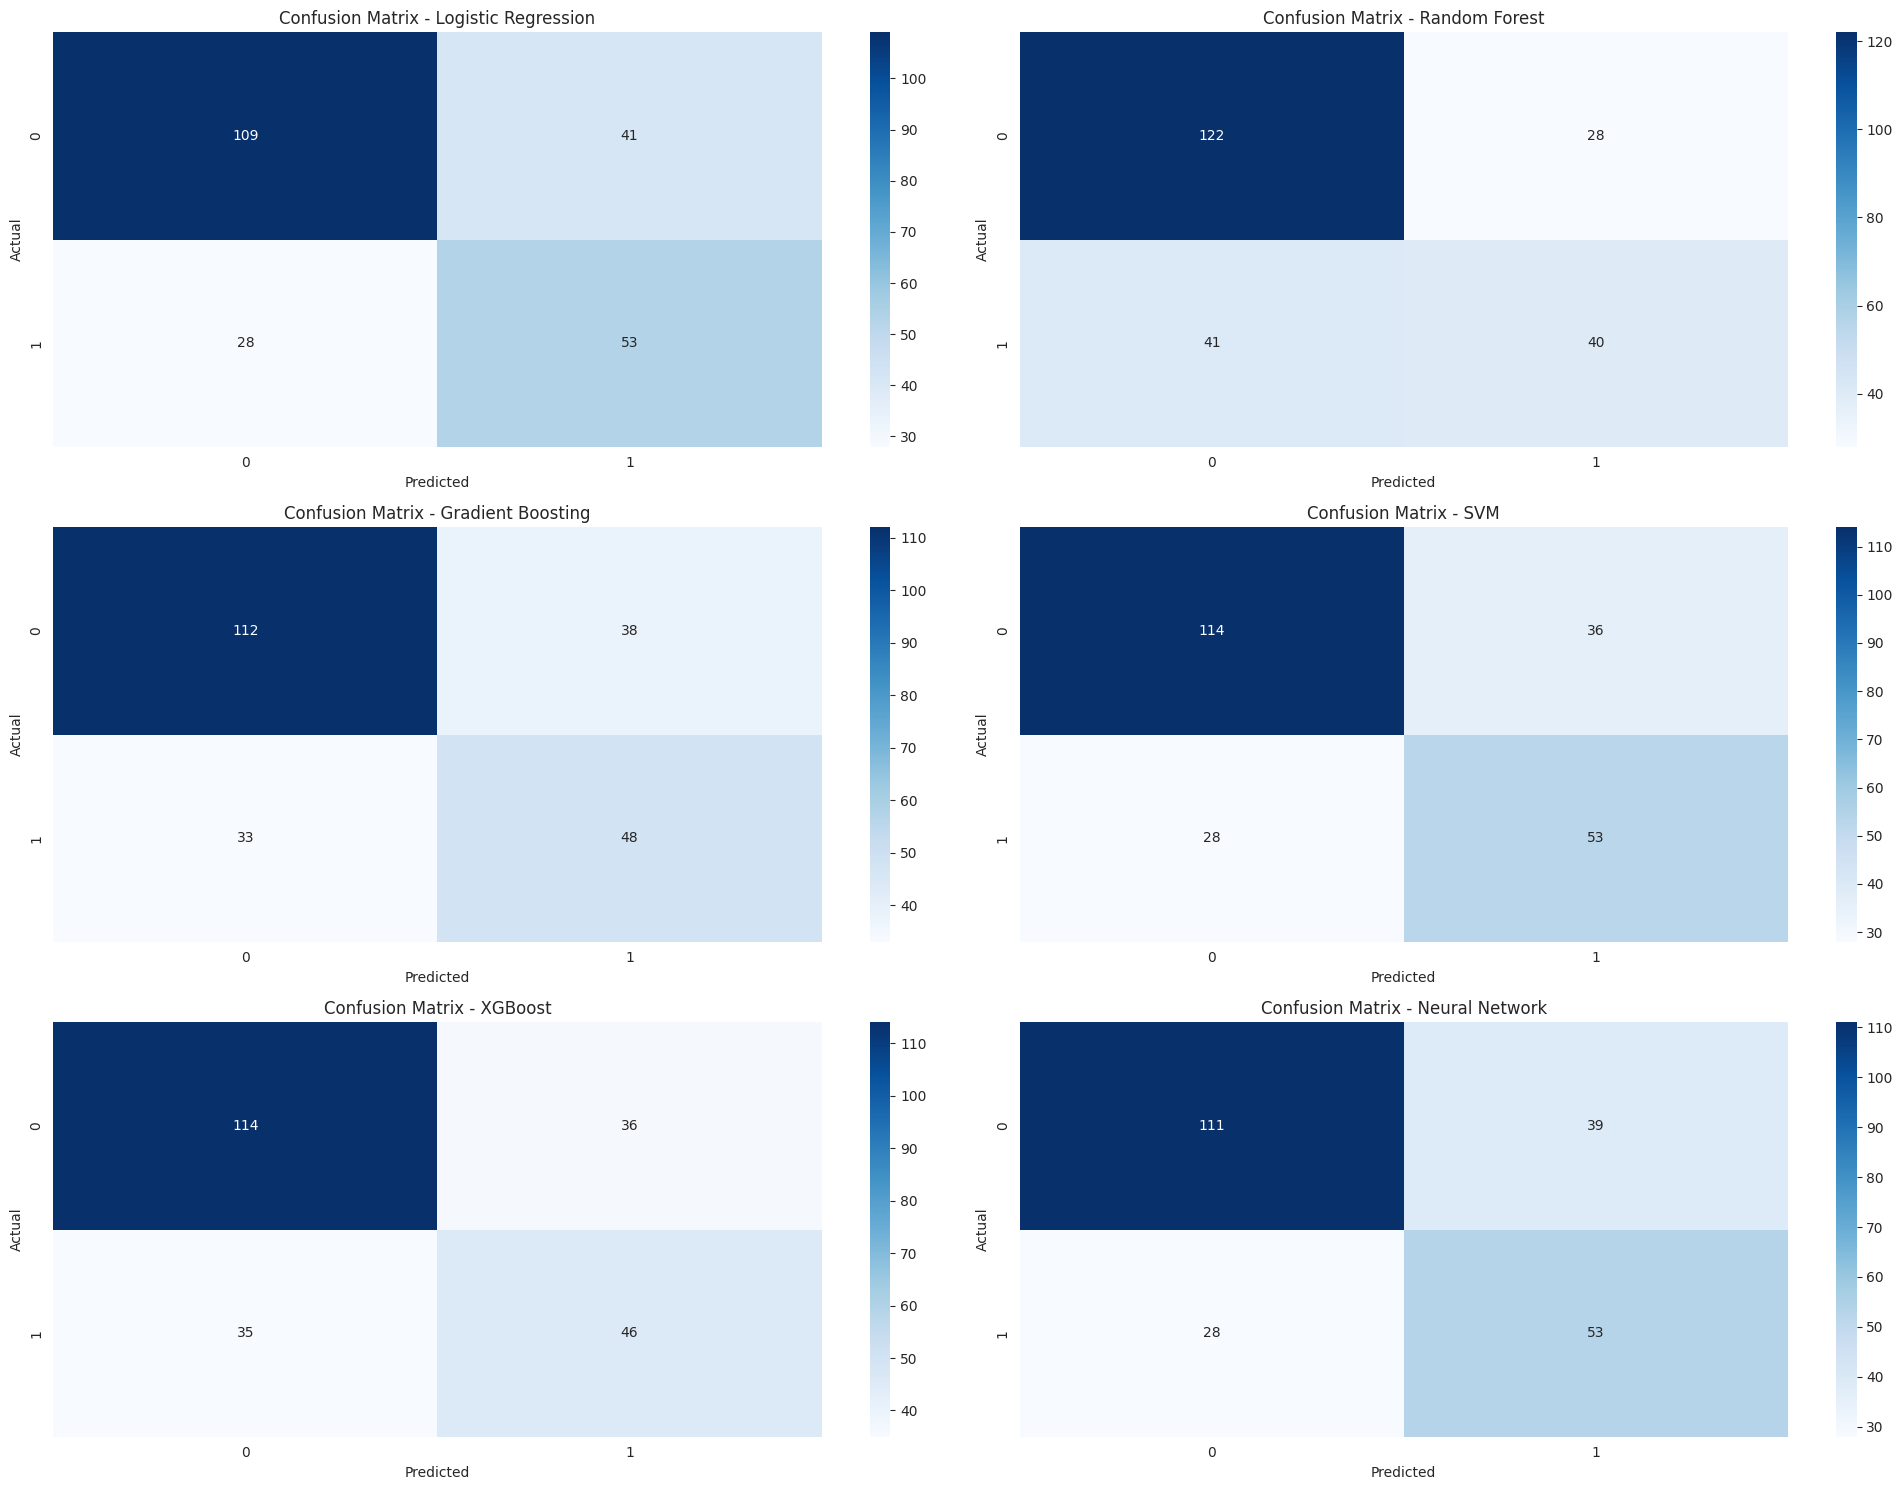

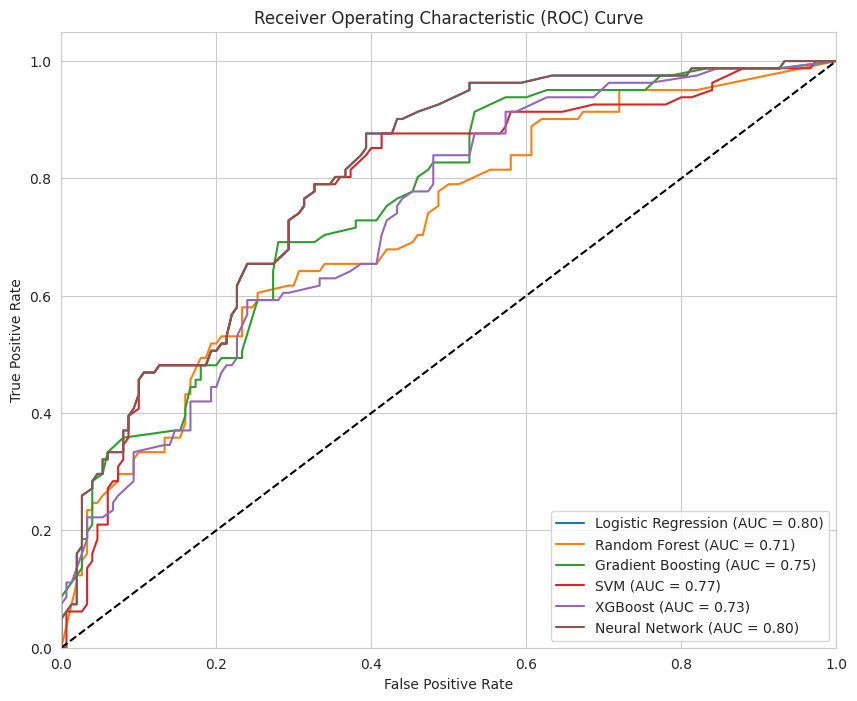

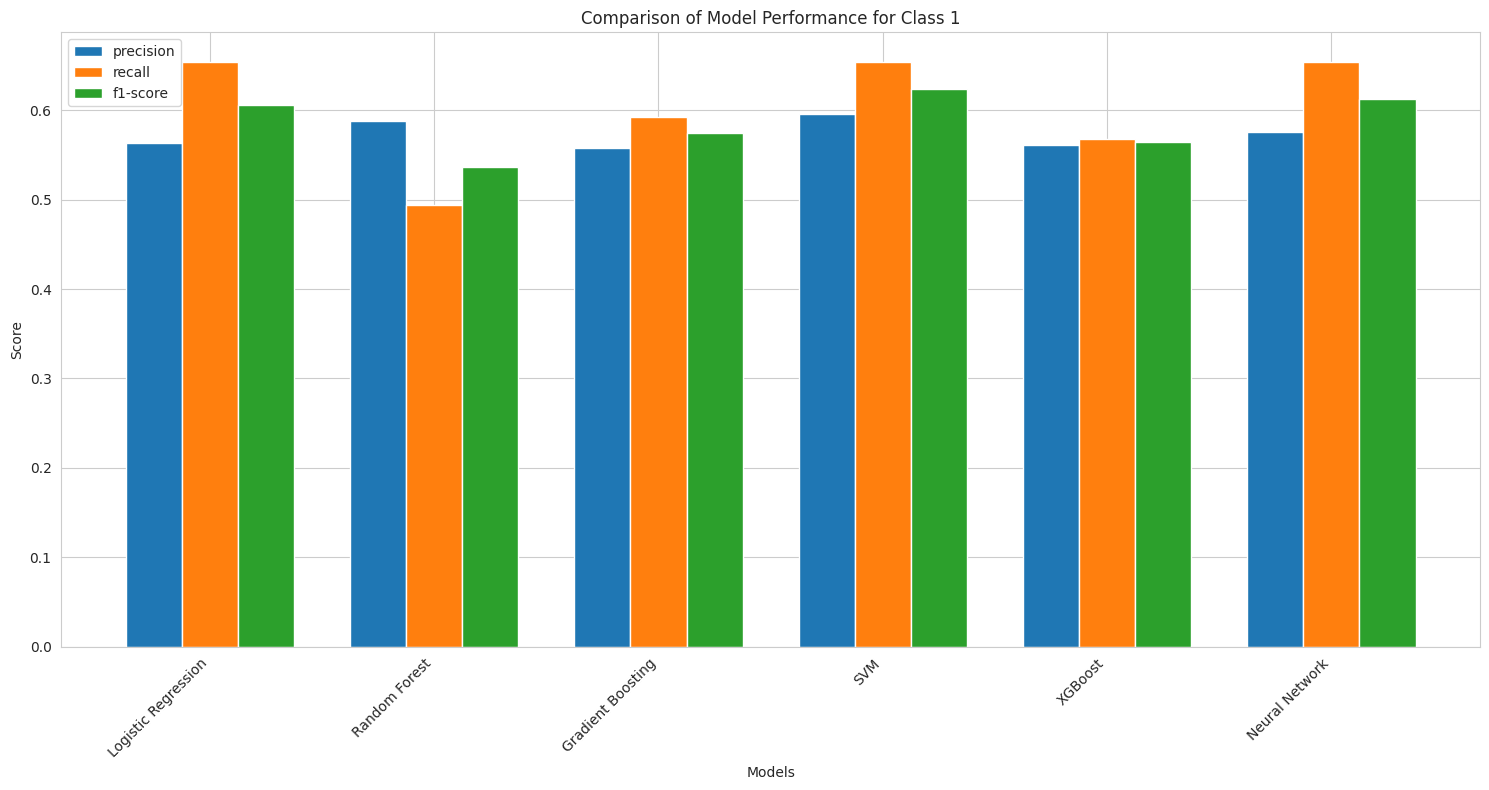

In [ ]:
# 1. Preparar los datos
# Definiendo X e y a partir de los DataFrames finales
X = df_imputed[selected_features]
y = df_imputed['Outcome']

# 2. Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# 3. Escalar los datos
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 4. Selección de características con Random Forest
rf_selector = RandomForestClassifier(random_state=42)
rf_selector.fit(X_train_scaled, y_train)

# Usamos SelectFromModel para seleccionar las características más importantes
sfm = SelectFromModel(rf_selector, threshold='mean') # puedes ajustar el threshold
sfm.fit(X_train_scaled, y_train)

# Transformamos los conjuntos de entrenamiento y prueba para incluir solo las características seleccionadas
X_train_selected = sfm.transform(X_train_scaled)
X_test_selected = sfm.transform(X_test_scaled)

# 5. Balancear las clases con SMOTE
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train_selected, y_train)

# 6. Definir los modelos
models = {
    'Logistic Regression': LogisticRegression(random_state=42),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(random_state=42),
    'SVM': SVC(kernel='rbf', probability=True, random_state=42),
    'XGBoost': XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42),
    'Neural Network': MLPClassifier(hidden_layer_sizes=(100, 50), max_iter=500, random_state=42)
}

# 7. Entrenar y evaluar cada modelo
results = {}

for name, model in models.items():
    print(f"\nTraining {name}...")

    # Entrenar el modelo con datos balanceados
    model.fit(X_train_smote, y_train_smote)

    # Predecir en el conjunto de prueba original
    y_pred = model.predict(X_test_selected)
    y_prob = model.predict_proba(X_test_selected)[:, 1]

    # Calcular métricas
    report = classification_report(y_test, y_pred, output_dict=True)
    conf_matrix = confusion_matrix(y_test, y_pred)
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    roc_auc = auc(fpr, tpr)

    # Guardar resultados
    results[name] = {
        'report': report,
        'conf_matrix': conf_matrix,
        'fpr': fpr,
        'tpr': tpr,
        'roc_auc': roc_auc
    }

    # Imprimir reporte de clasificación
    print(f"Classification Report for {name}:")
    print(classification_report(y_test, y_pred))

# Visualizar resultados
plt.figure(figsize=(20, 15))

# Matrices de confusión
for i, (name, result) in enumerate(results.items()):
    plt.subplot(3, 2, i+1)
    sns.heatmap(result['conf_matrix'], annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix - {name}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')

plt.tight_layout()
plt.show()

# Curvas ROC
plt.figure(figsize=(10, 8))
for name, result in results.items():
    plt.plot(result['fpr'], result['tpr'], label=f'{name} (AUC = {result["roc_auc"]:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

# Comparación de métricas
metrics = ['precision', 'recall', 'f1-score']
model_names = list(results.keys())
metric_values = {metric: [results[model]['report']['1'][metric] for model in model_names] for metric in metrics}

plt.figure(figsize=(15, 8))
x = np.arange(len(model_names))
width = 0.25

for i, metric in enumerate(metrics):
    plt.bar(x + i*width, metric_values[metric], width, label=metric)

plt.xlabel('Models')
plt.ylabel('Score')
plt.title('Comparison of Model Performance for Class 1')
plt.xticks(x + width, model_names, rotation=45, ha='right')
plt.legend()
plt.tight_layout()
plt.show()


1. Logistic Regression y Neural Network muestran el mejor desempeño general en términos de AUC (0.80) en la curva ROC, lo que indica que estos modelos tienen una buena capacidad para separar las clases.
SVM también tiene un desempeño competitivo con un AUC de 0.77.



2. Precisión, Recall y F1-Score
La clase 0 (negativa) tiene consistentemente mejor precisión, recall y F1-score en todos los modelos, lo que indica que los modelos están sesgados hacia la clase mayoritaria.
Para la clase 1 (positiva), Logistic Regression, SVM, y Neural Network logran un mejor balance entre precisión (alrededor de 0.58-0.60), recall (0.65) y F1-score (0.61-0.62).
Modelos como Random Forest, Gradient Boosting, y XGBoost tienen menor recall para la clase positiva (~0.49-0.59), lo que implica que no capturan bien los casos positivos.

3. Confusion Matrices
Los modelos tienden a cometer más errores al predecir la clase positiva (1), con un número considerable de falsos negativos. Los modelos tienen dificultades en manejar el desbalance entre clases.

En Logistic Regression, hay 28 falsos negativos frente a 41 falsos positivos.
En Random Forest, los falsos negativos aumentan a 41, lo que afecta su capacidad para identificar correctamente la clase positiva.


4. Impacto de la Selección de Características
La selección de características con Random Forest parece haber reducido la complejidad del modelo sin afectar significativamente el desempeño general.
Sin embargo, algunos modelos como Gradient Boosting y XGBoost no se benefician tanto como otros, lo que podría indicar que estos algoritmos requieren más información para alcanzar su máximo potencial.



Los dos modelos que destacan en todas las técnicas son:
- Logistic Regression:
Tiene el mejor desempeño global en términos de precisión, recall, F1-score y AUC (hasta 0.84).
Es simple, eficiente y consistente en todas las técnicas.

- SVM:
Mantiene un buen equilibrio entre precisión (62%) y recall (64%), con un alto AUC (hasta 0.81).
Es competitivo frente a Logistic Regression.

- Estrategia Que vamos a seguir:
La técnica "No PCA y No Selección de Características" ofrece los mejores resultados generale.
Los modelos tienen mayor capacidad para discriminar entre clases sin perder información relevante.
Técnicas como PCA o selección basada en Random Forest parecen reducir el rendimiento en algunos casos.

Continuaremos utilizando la técnica "No PCA y No Selección".

Nos enfocaremos en ajustar parámetros e implementar otras estrategias como manejo del desbalance para mejorar aún más los resultados en Logistic Regression y SVM.

PCA Y SELECCION DE CARACTERISTICAS


Training Logistic Regression...
Classification Report for Logistic Regression:
              precision    recall  f1-score   support

           0       0.84      0.76      0.80       150
           1       0.62      0.73      0.67        81

    accuracy                           0.75       231
   macro avg       0.73      0.74      0.73       231
weighted avg       0.76      0.75      0.75       231


Training Random Forest...
Classification Report for Random Forest:
              precision    recall  f1-score   support

           0       0.77      0.68      0.72       150
           1       0.51      0.62      0.56        81

    accuracy                           0.66       231
   macro avg       0.64      0.65      0.64       231
weighted avg       0.68      0.66      0.66       231


Training Gradient Boosting...
Classification Report for Gradient Boosting:
              precision    recall  f1-score   support

           0       0.85      0.69      0.76       150
           1 

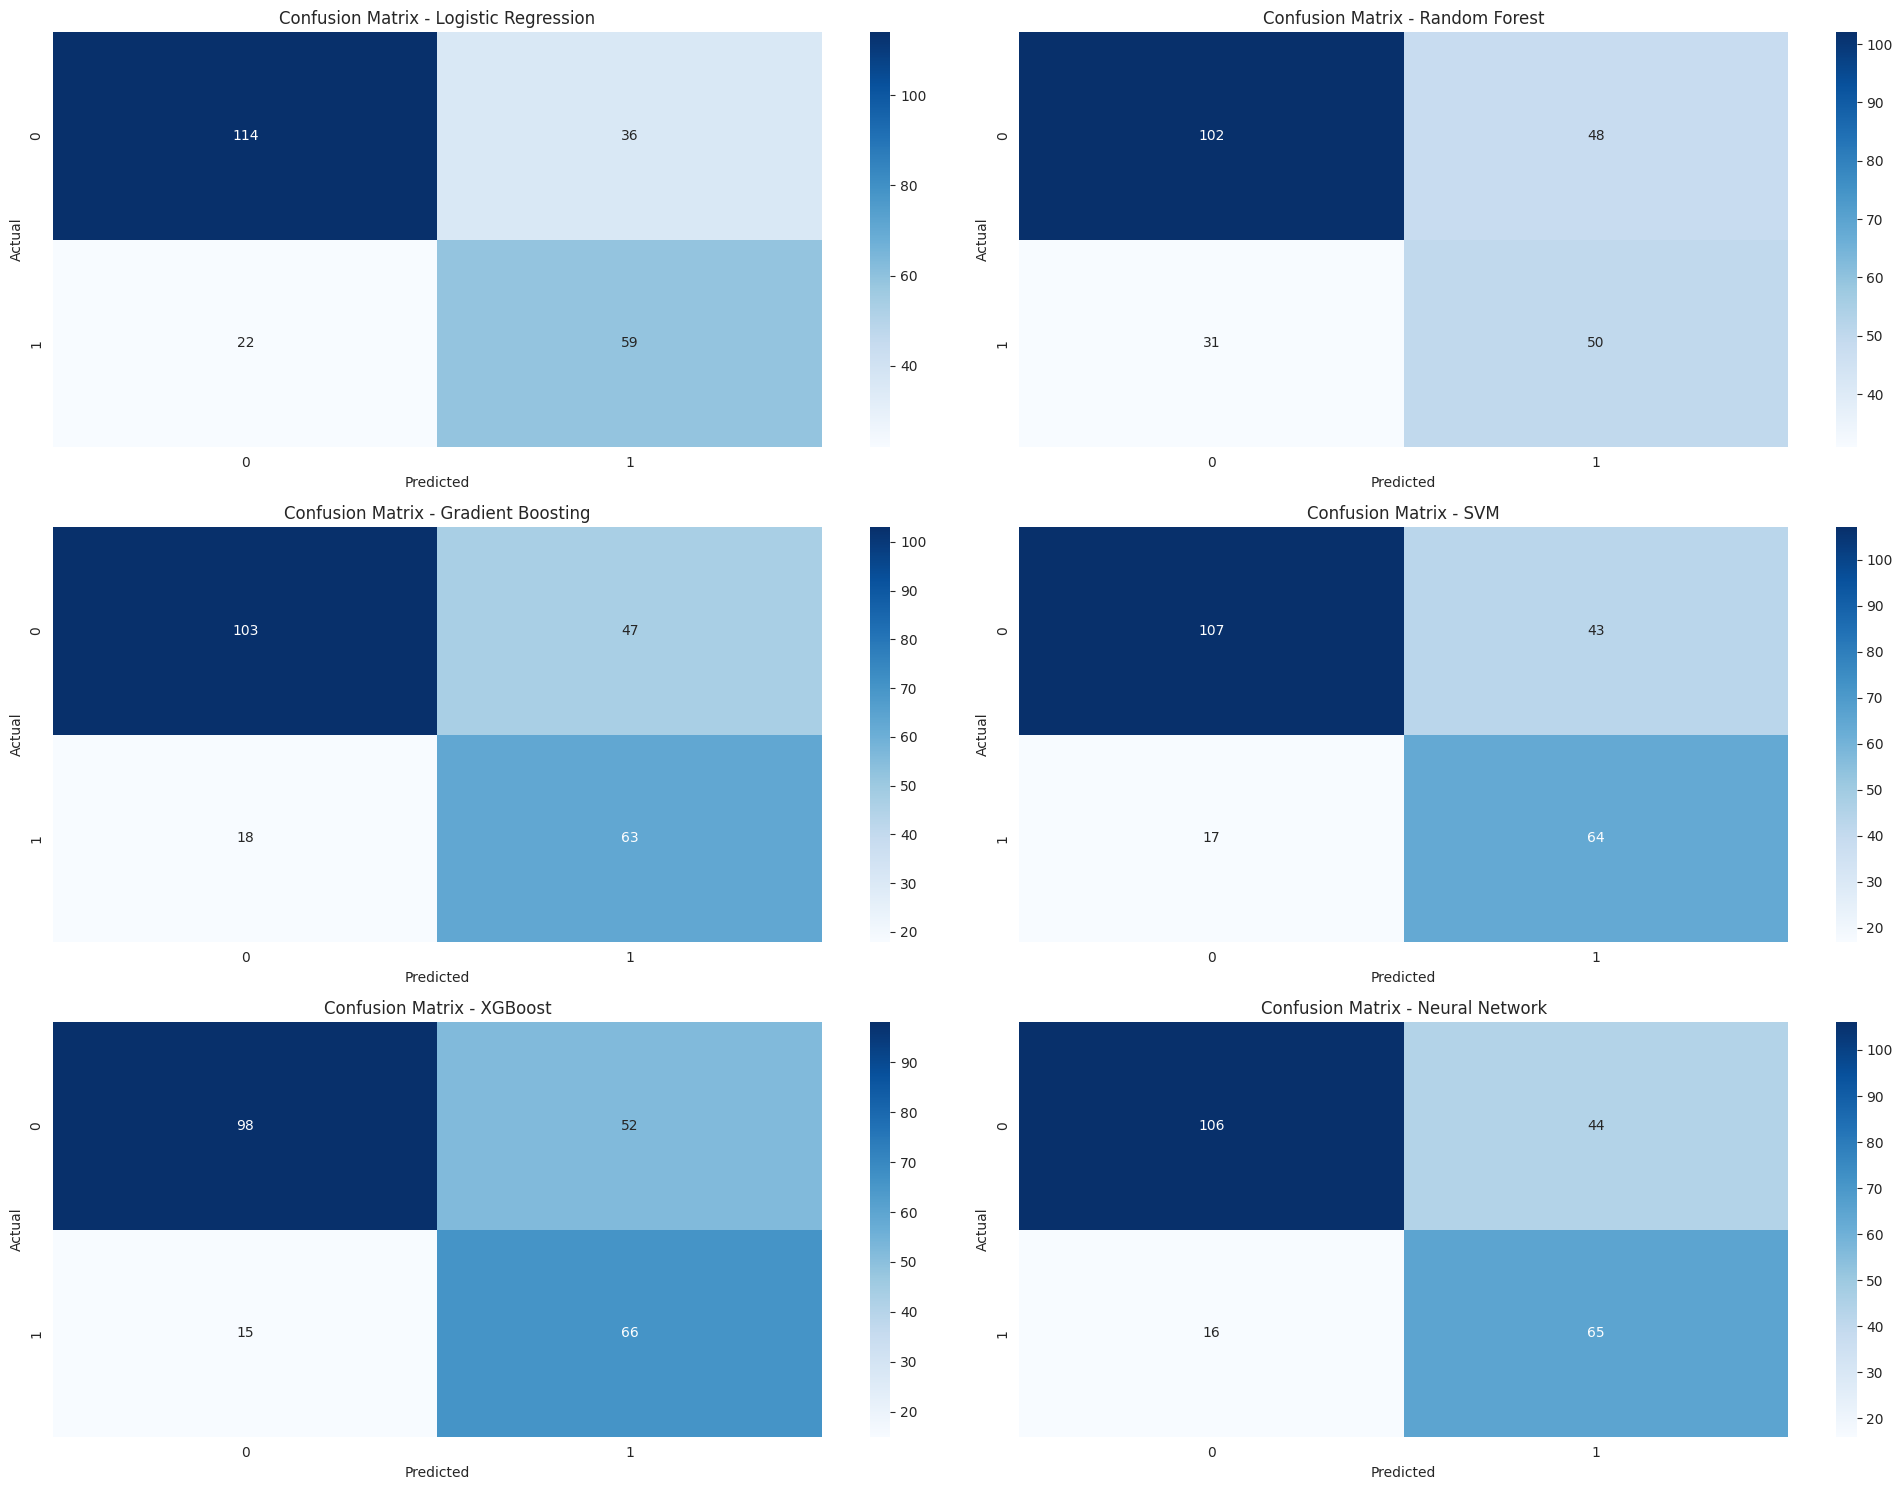

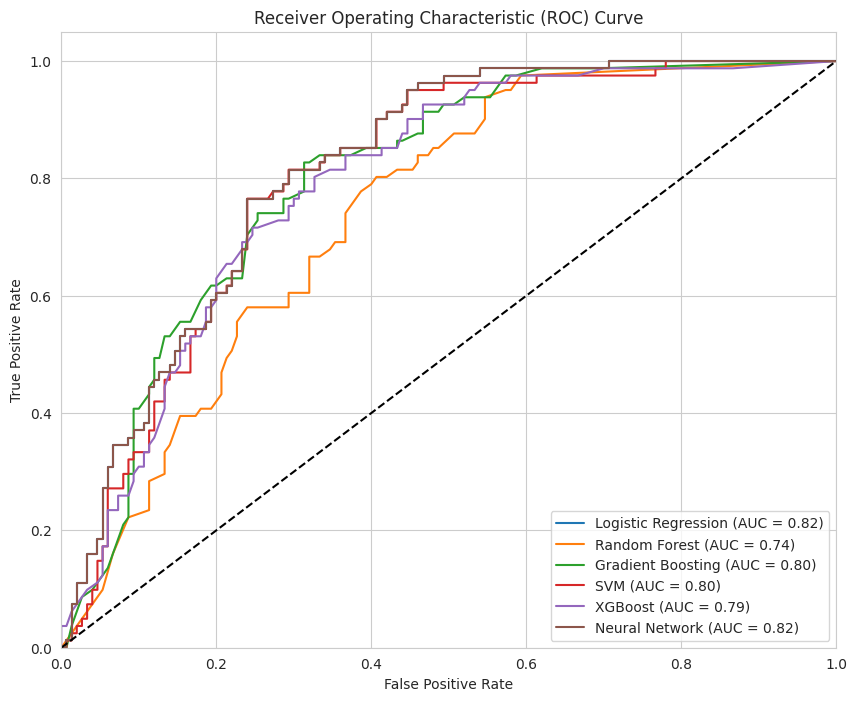

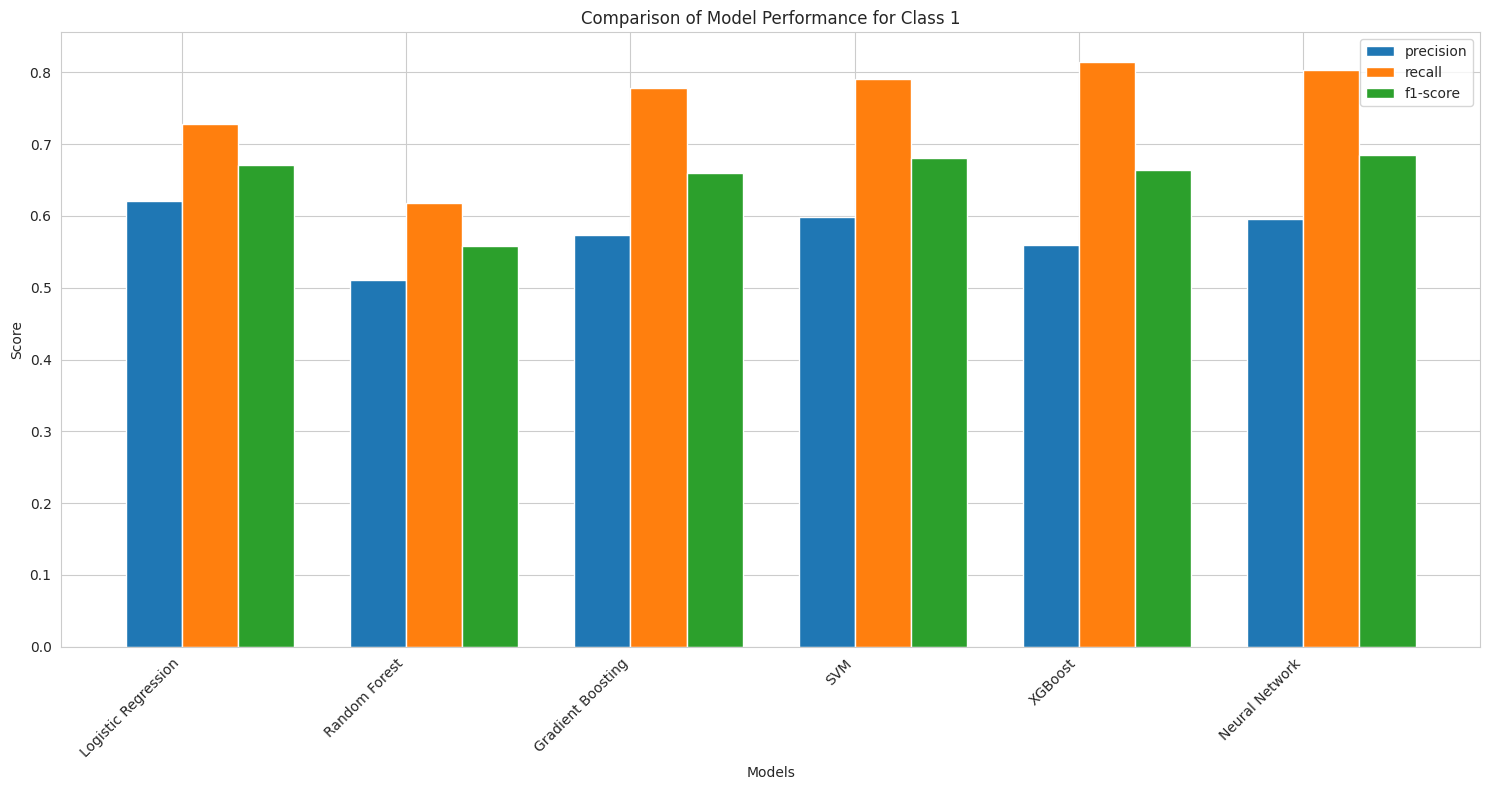

In [ ]:
# 1. Preparar los datos
# Definiendo X e y a partir de los DataFrames finales
X = df_imputed.drop('Outcome', axis=1)
y = df_imputed['Outcome']

# 2. Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# 3. Escalar los datos (antes de aplicar SMOTE)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 4. Balancear las clases con SMOTE (después del escalado)
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train_scaled, y_train)

# 5. Aplicar PCA para reducción de dimensionalidad
pca = PCA(n_components=0.95)  # Retener el 95% de la varianza
X_train_pca = pca.fit_transform(X_train_smote)
X_test_pca = pca.transform(X_test_scaled)

# 6. Selección de características con Random Forest (después de PCA)
rf_selector = RandomForestClassifier(random_state=42)
rf_selector.fit(X_train_pca, y_train_smote)

# Usamos SelectFromModel para seleccionar las características más importantes
sfm = SelectFromModel(rf_selector, threshold='mean')  # Puedes ajustar el threshold
sfm.fit(X_train_pca, y_train_smote)

# Transformamos los conjuntos de entrenamiento y prueba para incluir solo las características seleccionadas
X_train_final = sfm.transform(X_train_pca)
X_test_final = sfm.transform(X_test_pca)

# 7. Definir los modelos
models = {
    'Logistic Regression': LogisticRegression(random_state=42),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(random_state=42),
    'SVM': SVC(kernel='rbf', probability=True, random_state=42),
    'XGBoost': XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42),
    'Neural Network': MLPClassifier(hidden_layer_sizes=(100, 50), max_iter=500, random_state=42)
}

# 8. Entrenar y evaluar cada modelo
results = {}

for name, model in models.items():
    print(f"\nTraining {name}...")

    # Entrenar el modelo con datos balanceados
    model.fit(X_train_final, y_train_smote)

    # Predecir en el conjunto de prueba original
    y_pred = model.predict(X_test_final)
    y_prob = model.predict_proba(X_test_final)[:, 1]

    # Calcular métricas
    report = classification_report(y_test, y_pred, output_dict=True)
    conf_matrix = confusion_matrix(y_test, y_pred)
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    roc_auc = auc(fpr, tpr)

    # Guardar resultados
    results[name] = {
        'report': report,
        'conf_matrix': conf_matrix,
        'fpr': fpr,
        'tpr': tpr,
        'roc_auc': roc_auc
    }

    # Imprimir reporte de clasificación
    print(f"Classification Report for {name}:")
    print(classification_report(y_test, y_pred))

# Visualizar resultados

# Matrices de confusión
plt.figure(figsize=(20, 15))
for i, (name, result) in enumerate(results.items()):
    plt.subplot(3, 2, i+1)
    sns.heatmap(result['conf_matrix'], annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix - {name}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')

plt.tight_layout()
plt.show()

# Curvas ROC
plt.figure(figsize=(10, 8))
for name, result in results.items():
    plt.plot(result['fpr'], result['tpr'], label=f'{name} (AUC = {result["roc_auc"]:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

# Comparación de métricas
metrics = ['precision', 'recall', 'f1-score']
model_names = list(results.keys())
metric_values = {metric: [results[model]['report']['1'][metric] for model in model_names] for metric in metrics}

plt.figure(figsize=(15, 8))
x = np.arange(len(model_names))
width = 0.25

for i, metric in enumerate(metrics):
    plt.bar(x + i*width, metric_values[metric], width, label=metric)

plt.xlabel('Models')
plt.ylabel('Score')
plt.title('Comparison of Model Performance for Class 1')
plt.xticks(x + width / 2, model_names, rotation=45, ha='right')
plt.legend()
plt.tight_layout()
plt.show()


---

### BUSQUEDA DE MEJORES HIPERPARAMETROS PARA LOGISTIC REGRESSION
En este caso especificaremos una cuadrícula de hiperparámetros para LogisticRegression, incluyendo valores para C, penalty, solver y class_weight.

Utilizarmeos GridSearchCV con validación cruzada de 5 pliegues para encontrar los mejores parámetros. Por este motivo creamos un pipeline con las transformaciones de datos (escalado y smote), con el fin de que se apiquen correctamente en cada pliegue.

Por último ajustaremos el mejor estimador encontrado al conjunto de entrenamiento.

Fitting 5 folds for each of 40 candidates, totalling 200 fits
Mejores parámetros encontrados: {'logreg__C': 0.1, 'logreg__class_weight': None, 'logreg__penalty': 'l2', 'logreg__solver': 'saga'}
Mejor F1-score en validación cruzada: 0.6602721440401746

Reporte de clasificación en el conjunto de prueba:
              precision    recall  f1-score   support

           0       0.84      0.77      0.81       150
           1       0.63      0.73      0.68        81

    accuracy                           0.76       231
   macro avg       0.74      0.75      0.74       231
weighted avg       0.77      0.76      0.76       231



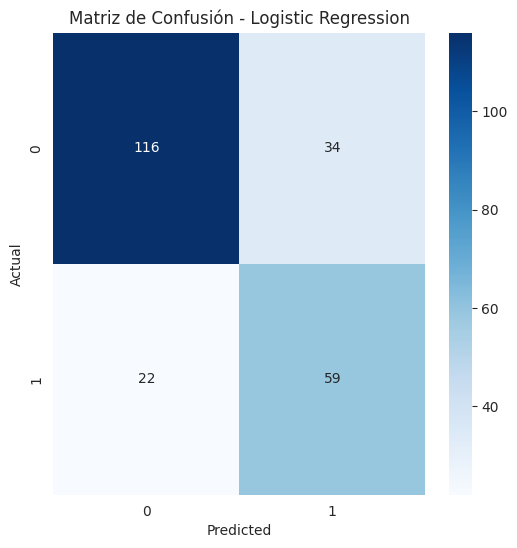

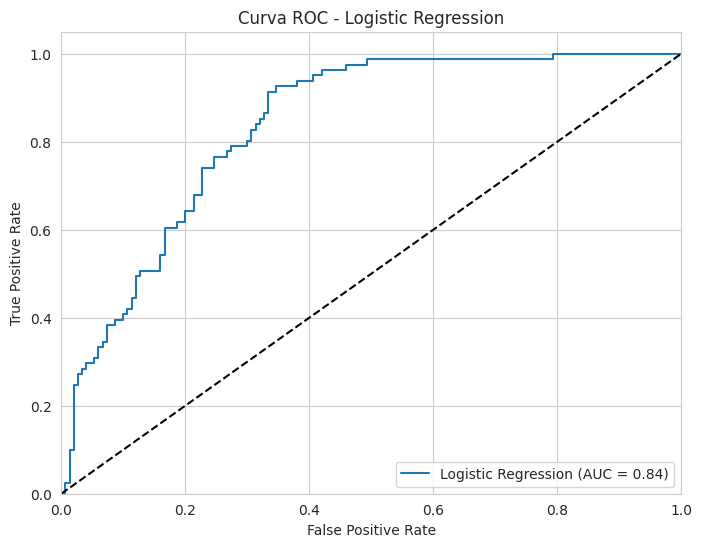

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.metrics import classification_report

# 1. Preparar los datos
X = df_imputed[selected_features]
y = df_imputed['Outcome']

# 2. Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# 3. Definir el pipeline
pipeline = ImbPipeline([
    ('scaler', StandardScaler()),  # Escalado de características
    ('smote', SMOTE(random_state=42)),  # Balanceo de clases con SMOTE
    ('logreg', LogisticRegression(max_iter=1000, random_state=42))  # Modelo de regresión logística
])

# 4. Definir la cuadrícula de hiperparámetros
param_grid = {
    'logreg__C': [0.01, 0.1, 1, 10, 100],  # Regularización (inversa de la fuerza)
    'logreg__penalty': ['l1', 'l2'],  # Tipo de penalización (L1 o L2)
    'logreg__solver': ['liblinear', 'saga'],  # Solvers compatibles con L1 y L2
    'logreg__class_weight': [None, 'balanced']  # Balanceo automático de clases
}

# 5. Configurar GridSearchCV con validación cruzada
grid_search = GridSearchCV(
    pipeline,
    param_grid,
    cv=5,  # Validación cruzada con 5 pliegues
    scoring='f1',  # Optimizar el F1-score para la clase positiva (Clase 1)
    n_jobs=-1,
    verbose=1
)

# 6. Ajustar el modelo al conjunto de entrenamiento
grid_search.fit(X_train, y_train)

# 7. Evaluar el mejor modelo en el conjunto de prueba
print("Mejores parámetros encontrados:", grid_search.best_params_)
print("Mejor F1-score en validación cruzada:", grid_search.best_score_)

# Predicciones en el conjunto de prueba
y_pred = grid_search.best_estimator_.predict(X_test)
y_prob = grid_search.best_estimator_.predict_proba(X_test)[:, 1]

# Reporte de clasificación en el conjunto de prueba
print("\nReporte de clasificación en el conjunto de prueba:")
print(classification_report(y_test, y_pred))


# Visualización: Matriz de Confusión
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Matriz de Confusión - Logistic Regression')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Visualización: Curva ROC
fpr, tpr, _ = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'Logistic Regression (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')  # Línea diagonal para referencia
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Curva ROC - Logistic Regression')
plt.legend(loc="lower right")
plt.show()


### OPTIMIZAMOS HIPERPARAMETROS PARA SVM

Fitting 5 folds for each of 32 candidates, totalling 160 fits
Mejores parámetros encontrados: {'svm__C': 1, 'svm__class_weight': None, 'svm__gamma': 'scale', 'svm__kernel': 'linear'}
Mejor F1-score en validación cruzada: 0.6511779955941679

Reporte de clasificación en el conjunto de prueba:
              precision    recall  f1-score   support

           0       0.82      0.77      0.80       150
           1       0.62      0.69      0.65        81

    accuracy                           0.74       231
   macro avg       0.72      0.73      0.73       231
weighted avg       0.75      0.74      0.75       231



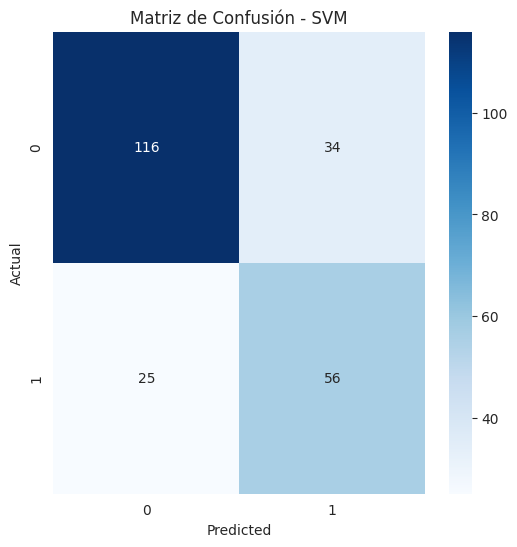

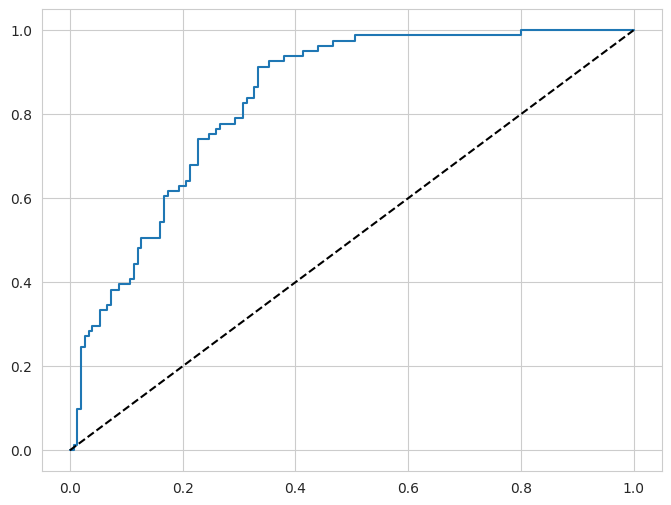

In [ ]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Preparar los datos
X = df_imputed[selected_features]
y = df_imputed['Outcome']

# 2. Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# 3. Definir el pipeline
pipeline = ImbPipeline([
    ('scaler', StandardScaler()),  # Escalado de características
    ('smote', SMOTE(random_state=42)),  # Balanceo de clases con SMOTE
    ('svm', SVC(probability=True, random_state=42))  # Modelo SVM con probabilidad habilitada
])

# 4. Definir la cuadrícula de hiperparámetros
param_grid = {
    'svm__C': [0.1, 1, 10, 100],  # Regularización (valores más altos reducen el margen)
    'svm__kernel': ['linear', 'rbf'],  # Tipos de kernel (lineal o radial)
    'svm__gamma': ['scale', 'auto'],  # Coeficiente del kernel (relevante para rbf)
    'svm__class_weight': [None, 'balanced']  # Balanceo automático de clases
}

# 5. Configurar GridSearchCV con validación cruzada
grid_search = GridSearchCV(
    pipeline,
    param_grid,
    cv=5,  # Validación cruzada con 5 pliegues
    scoring='f1',  # Optimizar el F1-score para la clase positiva (Clase 1)
    n_jobs=-1,
    verbose=1
)

# 6. Ajustar el modelo al conjunto de entrenamiento
grid_search.fit(X_train, y_train)

# 7. Evaluar el mejor modelo en el conjunto de prueba
print("Mejores parámetros encontrados:", grid_search.best_params_)
print("Mejor F1-score en validación cruzada:", grid_search.best_score_)

# Predicciones en el conjunto de prueba
y_pred = grid_search.best_estimator_.predict(X_test)
y_prob = grid_search.best_estimator_.predict_proba(X_test)[:, 1]

# Reporte de clasificación en el conjunto de prueba
print("\nReporte de clasificación en el conjunto de prueba:")
print(classification_report(y_test, y_pred))

# Visualización: Matriz de Confusión
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Matriz de Confusión - SVM')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Visualización: Curva ROC
fpr, tpr, _ = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'SVM (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')  # Línea diagonal para


- Logistic Regression optimizada tiene un F1-score para la Clase 1 de 68%, mientras que SVM optimizado alcanza un F1-score de 65%.

- Logistic Regression tiene una mejor precisión para la Clase 1 (63% vs. 62%) y un mejor recall (73% vs. 69%).

- En términos de AUC, Logistic Regression sigue siendo superior (0.84 vs. 0.81).

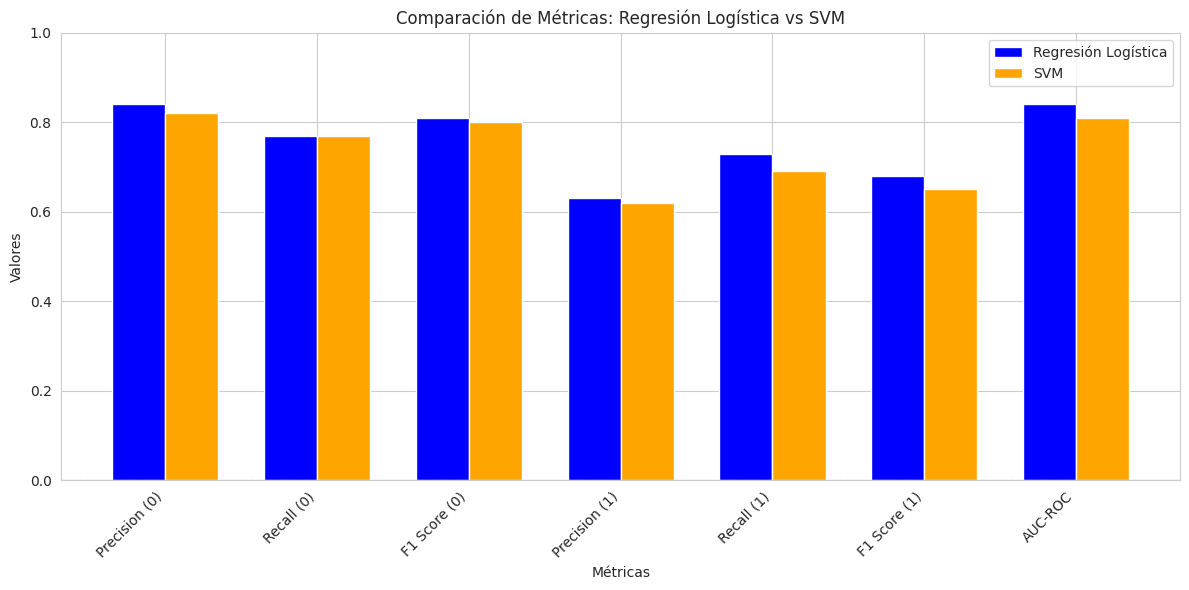

In [ ]:
# Comparamos metricas

# Definimos las métricas para ambos modelos
metrics = {
    'Metric': ['Precision (0)', 'Recall (0)', 'F1 Score (0)', 'Precision (1)', 'Recall (1)', 'F1 Score (1)', 'AUC-ROC'],
    'Regresión Logística': [0.84, 0.77, 0.81, 0.63, 0.73, 0.68, 0.84],  # Resultados de Logistic Regression
    'SVM': [0.82, 0.77, 0.80, 0.62, 0.69, 0.65, 0.81]  # Resultados de SVM
}

# Convertimos el diccionario a un DataFrame
metrics_df = pd.DataFrame(metrics)

# Configuramos el gráfico
plt.figure(figsize=(12, 6))

# Creamos gráficos de barras para cada métrica
bar_width = 0.35
x = np.arange(len(metrics_df))

# Barras para Regresión Logística
plt.bar(x - bar_width/2, metrics_df['Regresión Logística'], width=bar_width, label='Regresión Logística', color='blue')

# Barras para SVM
plt.bar(x + bar_width/2, metrics_df['SVM'], width=bar_width, label='SVM', color='orange')

# Establece etiquetas y títulos
plt.xlabel('Métricas')
plt.ylabel('Valores')
plt.title('Comparación de Métricas: Regresión Logística vs SVM')
plt.xticks(x, metrics_df['Metric'], rotation=45, ha='right')
plt.ylim(0, 1)
plt.axhline(0, color='grey', linewidth=0.8, ls='--')
plt.legend()

# Ajustamos el diseño y mostramos el gráfico
plt.tight_layout()
plt.show()


- Regresión Logística es el modelo más equilibrado y robusto, especialmente para la Clase 1 (positiva), que suele ser más difícil de predecir debido al desbalance de clases.

- Aunque SVM es competitivo, su desempeño es ligeramente inferior en las métricas clave.



### PROBAMOS TECNICAS DE BALANCEO DE CLASES:
REEMPLAZAMOS SMOTE POR:

- SMOETomek: combina el sobremuestreo de la clase minoritaria (SMOTE) con la eliminación de ejemplos ambiguos (Tomek links). Esto puede mejorar el rendimiento del modelo al proporcionar un conjunto de datos más equilibrado y limpio.
- ADASYN: genera más ejemplos sintéticos para las instancias de la clase minoritaria que son más difíciles de aprender, mejorando potencialmente el rendimiento del modelo en estas áreas.
- Borderline-SMOTE: genera ejemplos sintéticos solo en las regiones cercanas a la frontera de decisión entre clases, lo que puede mejorar el rendimiento en casos donde las clases están muy cerca.

Fitting 5 folds for each of 6 candidates, totalling 30 fits
Mejores parámetros encontrados: {'model__C': 1, 'model__penalty': 'l2', 'model__solver': 'saga'}

Reporte de clasificación:
              precision    recall  f1-score   support

           0       0.84      0.77      0.80       150
           1       0.63      0.73      0.67        81

    accuracy                           0.75       231
   macro avg       0.73      0.75      0.74       231
weighted avg       0.77      0.75      0.76       231

AUC-ROC: 0.8355


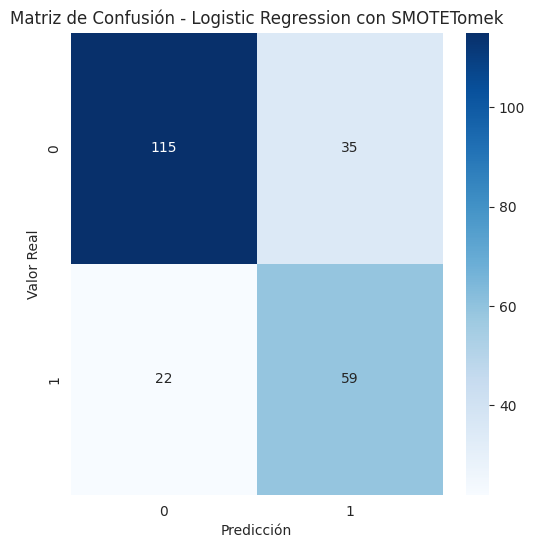

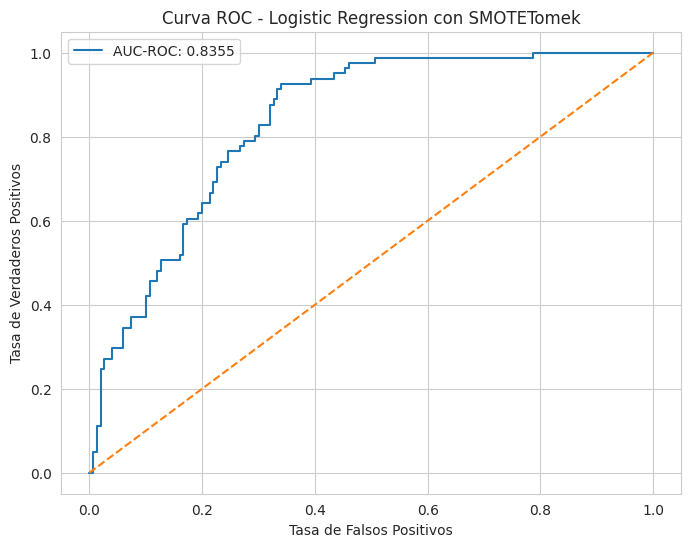

In [ ]:
from imblearn.combine import SMOTETomek
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix, roc_curve
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Preparar los datos
X = df_imputed[selected_features]
y = df_imputed['Outcome']

# 2. Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# 3. Definir la técnica de balanceo (SMOTETomek)
smotetomek = SMOTETomek(random_state=42)

# 4. Seleccionar el modelo (Logistic Regression o SVM)
model_name = 'Logistic Regression'  # Cambiar a 'SVM' si quieres probar con SVM
if model_name == 'Logistic Regression':
    model = LogisticRegression(max_iter=1000, random_state=42)
    param_grid = {
        'model__C': [0.01, 0.1, 1],
        'model__penalty': ['l2'],  # Solo L2 para evitar incompatibilidades con SMOTETomek
        'model__solver': ['liblinear', 'saga']
    }
elif model_name == 'SVM':
    model = SVC(probability=True, random_state=42)
    param_grid = {
        'model__C': [0.1, 1, 10],
        'model__kernel': ['linear', 'rbf'],
        'model__gamma': ['scale', 'auto']
    }

# 5. Crear el pipeline con SMOTETomek y el modelo seleccionado
pipeline = ImbPipeline([
    ('scaler', StandardScaler()),  # Escalado de características
    ('smotetomek', smotetomek),   # Técnica de balanceo SMOTETomek
    ('model', model)              # Modelo seleccionado (Logistic Regression o SVM)
])

# 6. Configurar GridSearchCV para la búsqueda de hiperparámetros
grid_search = GridSearchCV(
    pipeline,
    param_grid,
    cv=5,
    scoring='f1',
    n_jobs=-1,
    verbose=1
)

# 7. Ajustar el modelo al conjunto de entrenamiento
grid_search.fit(X_train, y_train)

# Evaluar el mejor modelo en el conjunto de prueba
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)
y_prob = best_model.predict_proba(X_test)[:, 1]

print(f"Mejores parámetros encontrados: {grid_search.best_params_}")

# Reporte de clasificación en el conjunto de prueba
print("\nReporte de clasificación:")
print(classification_report(y_test, y_pred))

# AUC-ROC
auc_roc = roc_auc_score(y_test, y_prob)
print(f"AUC-ROC: {auc_roc:.4f}")

# Matriz de Confusión
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title(f'Matriz de Confusión - {model_name} con SMOTETomek')
plt.xlabel('Predicción')
plt.ylabel('Valor Real')
plt.show()

# Curva ROC
fpr, tpr, _ = roc_curve(y_test, y_prob)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'AUC-ROC: {auc_roc:.4f}')
plt.plot([0, 1], linestyle='--')
plt.xlabel('Tasa de Falsos Positivos')
plt.ylabel('Tasa de Verdaderos Positivos')
plt.title(f'Curva ROC - {model_name} con SMOTETomek')
plt.legend()
plt.show()


Fitting 5 folds for each of 12 candidates, totalling 60 fits
Mejores parámetros encontrados: {'classifier__C': 1, 'classifier__gamma': 'scale', 'classifier__kernel': 'linear'}

Reporte de clasificación para SVM con SMOTETomek:
              precision    recall  f1-score   support

           0       0.84      0.77      0.81       150
           1       0.63      0.73      0.68        81

    accuracy                           0.76       231
   macro avg       0.74      0.75      0.74       231
weighted avg       0.77      0.76      0.76       231

AUC-ROC: 0.8358


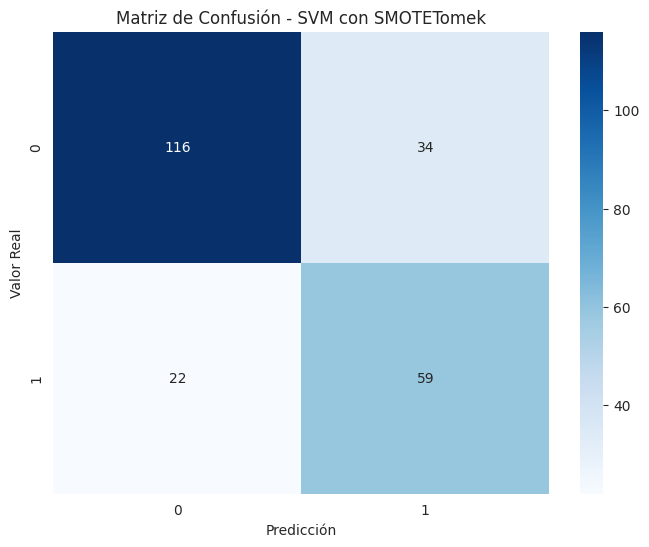

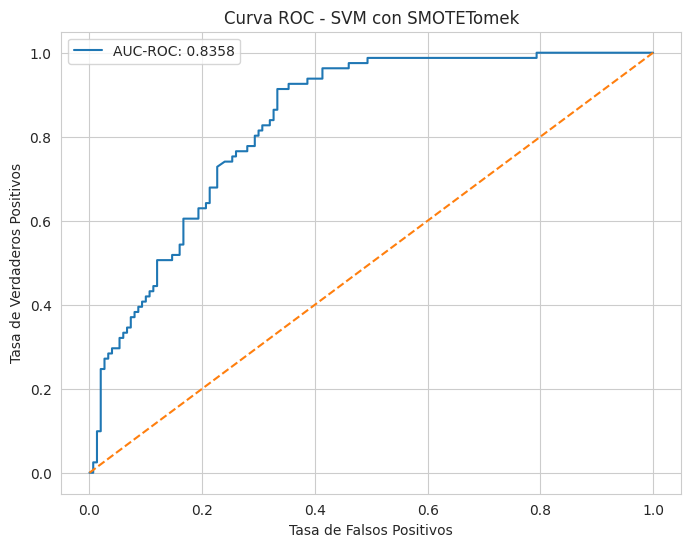

In [ ]:
from imblearn.combine import SMOTETomek
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix, roc_curve
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Preparar los datos
X = df_imputed[selected_features]
y = df_imputed['Outcome']

# 2. Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# 3. Definir la técnica de balanceo (SMOTETomek)
smotetomek = SMOTETomek(random_state=42)

# 4. Crear el pipeline con SMOTETomek y SVM
pipeline_svm_smotetomek = ImbPipeline([
    ('scaler', StandardScaler()),  # Escalado de características
    ('smotetomek', smotetomek),   # Técnica de balanceo SMOTETomek
    ('classifier', SVC(probability=True, random_state=42))  # Modelo SVM con probabilidad habilitada
])

# 5. Definir los parámetros para la búsqueda de hiperparámetros
param_grid_svm = {
    'classifier__C': [0.1, 1, 10],
    'classifier__kernel': ['linear', 'rbf'],
    'classifier__gamma': ['scale', 'auto']
}

# 6. Realizar la búsqueda de hiperparámetros con GridSearchCV
grid_search_svm_smotetomek = GridSearchCV(
    pipeline_svm_smotetomek,
    param_grid_svm,
    cv=5,
    scoring='f1',
    n_jobs=-1,
    verbose=1
)
grid_search_svm_smotetomek.fit(X_train, y_train)

# Evaluar el mejor modelo en el conjunto de prueba
best_svm_smotetomek = grid_search_svm_smotetomek.best_estimator_
y_pred_svm_smotetomek = best_svm_smotetomek.predict(X_test)
y_prob_svm_smotetomek = best_svm_smotetomek.predict_proba(X_test)[:, 1]

print(f"Mejores parámetros encontrados: {grid_search_svm_smotetomek.best_params_}")

# Reporte de clasificación en el conjunto de prueba
print("\nReporte de clasificación para SVM con SMOTETomek:")
print(classification_report(y_test, y_pred_svm_smotetomek))

# AUC-ROC
roc_auc_smotetomek = roc_auc_score(y_test, y_prob_svm_smotetomek)
print(f"AUC-ROC: {roc_auc_smotetomek:.4f}")

# Matriz de Confusión
cm = confusion_matrix(y_test, y_pred_svm_smotetomek)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Matriz de Confusión - SVM con SMOTETomek')
plt.xlabel('Predicción')
plt.ylabel('Valor Real')
plt.show()

# Curva ROC
fpr, tpr, _ = roc_curve(y_test, y_prob_svm_smotetomek)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'AUC-ROC: {roc_auc_smotetomek:.4f}')
plt.plot([0, 1], linestyle='--')
plt.xlabel('Tasa de Falsos Positivos')
plt.ylabel('Tasa de Verdaderos Positivos')
plt.title('Curva ROC - SVM con SMOTETomek')
plt.legend()
plt.show()


### APLICAMOS ADASYN

Fitting 5 folds for each of 6 candidates, totalling 30 fits
Mejores parámetros encontrados: {'classifier__C': 0.01, 'classifier__penalty': 'l2', 'classifier__solver': 'liblinear'}

Reporte de clasificación para Logistic Regression con ADASYN:
              precision    recall  f1-score   support

           0       0.85      0.71      0.77       150
           1       0.59      0.78      0.67        81

    accuracy                           0.73       231
   macro avg       0.72      0.74      0.72       231
weighted avg       0.76      0.73      0.74       231

AUC-ROC: 0.8314


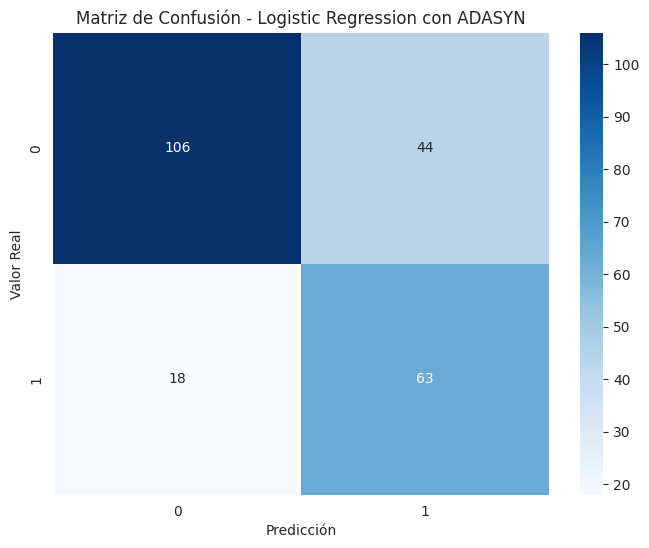

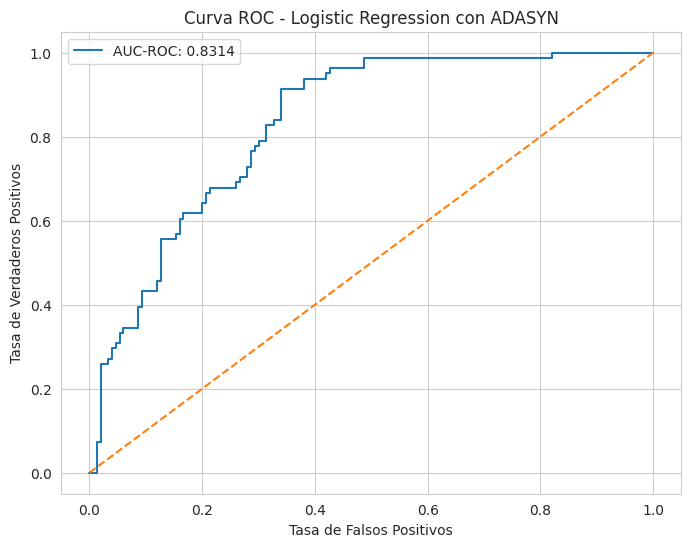

In [ ]:
from imblearn.over_sampling import ADASYN
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix, roc_curve
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Preparar los datos
X = df_imputed[selected_features]
y = df_imputed['Outcome']

# 2. Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# 3. Definir la técnica de balanceo (ADASYN)
adasyn = ADASYN(random_state=42)

# 4. Crear el pipeline con ADASYN y Logistic Regression
pipeline_lr_adasyn = ImbPipeline([
    ('scaler', StandardScaler()),  # Escalado de características
    ('adasyn', adasyn),           # Técnica de balanceo ADASYN
    ('classifier', LogisticRegression(max_iter=1000, random_state=42))  # Modelo Logistic Regression
])

# 5. Definir los parámetros para la búsqueda de hiperparámetros
param_grid_lr = {
    'classifier__C': [0.01, 0.1, 1],
    'classifier__penalty': ['l2'],  # Solo L2 para evitar incompatibilidades con ADASYN
    'classifier__solver': ['liblinear', 'saga']
}

# 6. Realizar la búsqueda de hiperparámetros con GridSearchCV
grid_search_lr_adasyn = GridSearchCV(
    pipeline_lr_adasyn,
    param_grid_lr,
    cv=5,
    scoring='f1',
    n_jobs=-1,
    verbose=1
)
grid_search_lr_adasyn.fit(X_train, y_train)

# Evaluar el mejor modelo en el conjunto de prueba
best_lr_adasyn = grid_search_lr_adasyn.best_estimator_
y_pred_lr_adasyn = best_lr_adasyn.predict(X_test)
y_prob_lr_adasyn = best_lr_adasyn.predict_proba(X_test)[:, 1]

print(f"Mejores parámetros encontrados: {grid_search_lr_adasyn.best_params_}")

# Reporte de clasificación en el conjunto de prueba
print("\nReporte de clasificación para Logistic Regression con ADASYN:")
print(classification_report(y_test, y_pred_lr_adasyn))

# AUC-ROC
roc_auc_adasyn = roc_auc_score(y_test, y_prob_lr_adasyn)
print(f"AUC-ROC: {roc_auc_adasyn:.4f}")

# Matriz de Confusión
cm = confusion_matrix(y_test, y_pred_lr_adasyn)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Matriz de Confusión - Logistic Regression con ADASYN')
plt.xlabel('Predicción')
plt.ylabel('Valor Real')
plt.show()

# Curva ROC
fpr, tpr, _ = roc_curve(y_test, y_prob_lr_adasyn)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'AUC-ROC: {roc_auc_adasyn:.4f}')
plt.plot([0, 1], linestyle='--')
plt.xlabel('Tasa de Falsos Positivos')
plt.ylabel('Tasa de Verdaderos Positivos')
plt.title('Curva ROC - Logistic Regression con ADASYN')
plt.legend()
plt.show()


Fitting 5 folds for each of 12 candidates, totalling 60 fits
Mejores parámetros encontrados: {'classifier__C': 0.1, 'classifier__gamma': 'auto', 'classifier__kernel': 'rbf'}

Reporte de clasificación para SVM con ADASYN:
              precision    recall  f1-score   support

           0       0.88      0.68      0.77       150
           1       0.58      0.83      0.68        81

    accuracy                           0.73       231
   macro avg       0.73      0.75      0.73       231
weighted avg       0.78      0.73      0.74       231

AUC-ROC: 0.8238


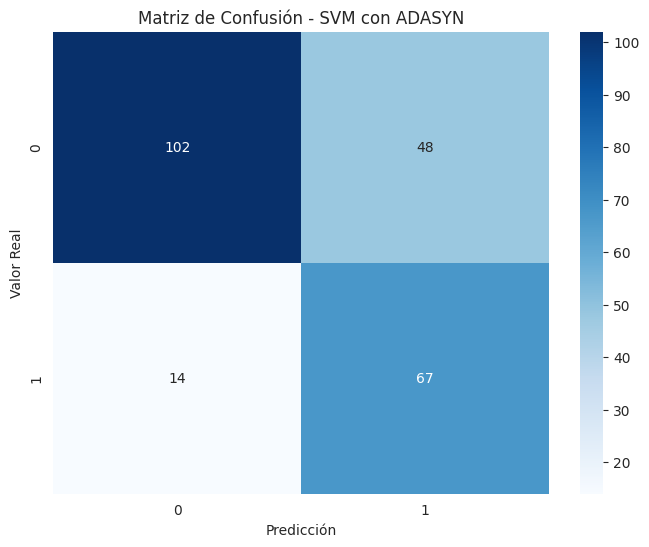

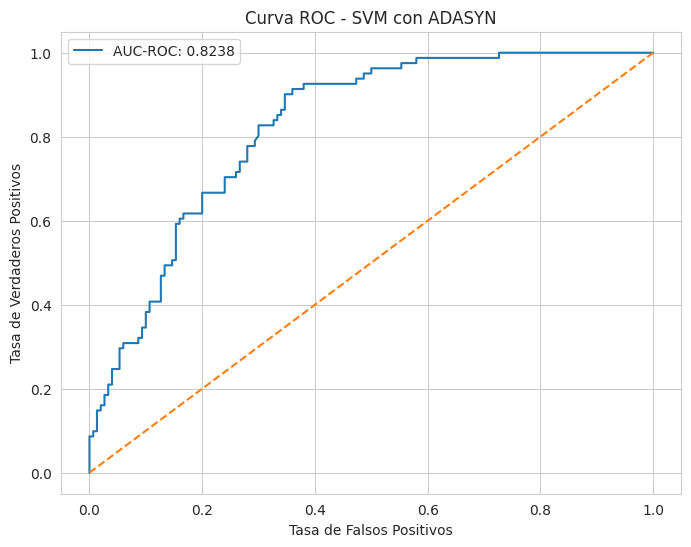

In [ ]:
from imblearn.over_sampling import ADASYN
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix, roc_curve
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Preparar los datos
X = df_imputed[selected_features]
y = df_imputed['Outcome']

# 2. Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# 3. Definir la técnica de balanceo (ADASYN)
adasyn = ADASYN(random_state=42)

# 4. Crear el pipeline con ADASYN y SVM
pipeline_svm_adasyn = ImbPipeline([
    ('scaler', StandardScaler()),  # Escalado de características
    ('adasyn', adasyn),           # Técnica de balanceo ADASYN
    ('classifier', SVC(probability=True, random_state=42))  # Modelo SVM con probabilidad habilitada
])

# 5. Definir los parámetros para la búsqueda de hiperparámetros
param_grid_svm = {
    'classifier__C': [0.1, 1, 10],
    'classifier__kernel': ['linear', 'rbf'],
    'classifier__gamma': ['scale', 'auto']
}

# 6. Realizar la búsqueda de hiperparámetros con GridSearchCV
grid_search_svm_adasyn = GridSearchCV(
    pipeline_svm_adasyn,
    param_grid_svm,
    cv=5,
    scoring='f1',
    n_jobs=-1,
    verbose=1
)
grid_search_svm_adasyn.fit(X_train, y_train)

# Evaluar el mejor modelo en el conjunto de prueba
best_svm_adasyn = grid_search_svm_adasyn.best_estimator_
y_pred_svm_adasyn = best_svm_adasyn.predict(X_test)
y_prob_svm_adasyn = best_svm_adasyn.predict_proba(X_test)[:, 1]

print(f"Mejores parámetros encontrados: {grid_search_svm_adasyn.best_params_}")

# Reporte de clasificación en el conjunto de prueba
print("\nReporte de clasificación para SVM con ADASYN:")
print(classification_report(y_test, y_pred_svm_adasyn))

# AUC-ROC
roc_auc_adasyn = roc_auc_score(y_test, y_prob_svm_adasyn)
print(f"AUC-ROC: {roc_auc_adasyn:.4f}")

# Matriz de Confusión
cm = confusion_matrix(y_test, y_pred_svm_adasyn)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Matriz de Confusión - SVM con ADASYN')
plt.xlabel('Predicción')
plt.ylabel('Valor Real')
plt.show()

# Curva ROC
fpr, tpr, _ = roc_curve(y_test, y_prob_svm_adasyn)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'AUC-ROC: {roc_auc_adasyn:.4f}')
plt.plot([0, 1], linestyle='--')
plt.xlabel('Tasa de Falsos Positivos')
plt.ylabel('Tasa de Verdaderos Positivos')
plt.title('Curva ROC - SVM con ADASYN')
plt.legend()
plt.show()


### APLICAMOS BORDERLINE-SMOTE

Fitting 5 folds for each of 6 candidates, totalling 30 fits
Mejores parámetros encontrados: {'classifier__C': 0.01, 'classifier__penalty': 'l2', 'classifier__solver': 'liblinear'}

Reporte de clasificación para Logistic Regression con Borderline-SMOTE:
              precision    recall  f1-score   support

           0       0.83      0.72      0.77       150
           1       0.58      0.73      0.65        81

    accuracy                           0.72       231
   macro avg       0.71      0.72      0.71       231
weighted avg       0.74      0.72      0.73       231

AUC-ROC: 0.8324


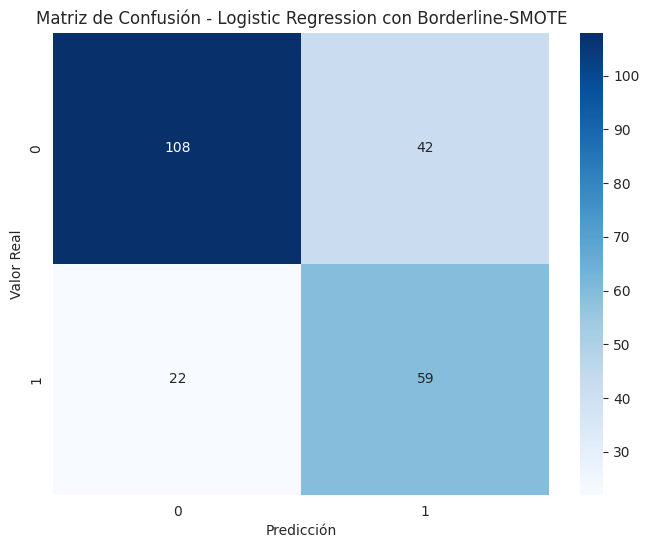

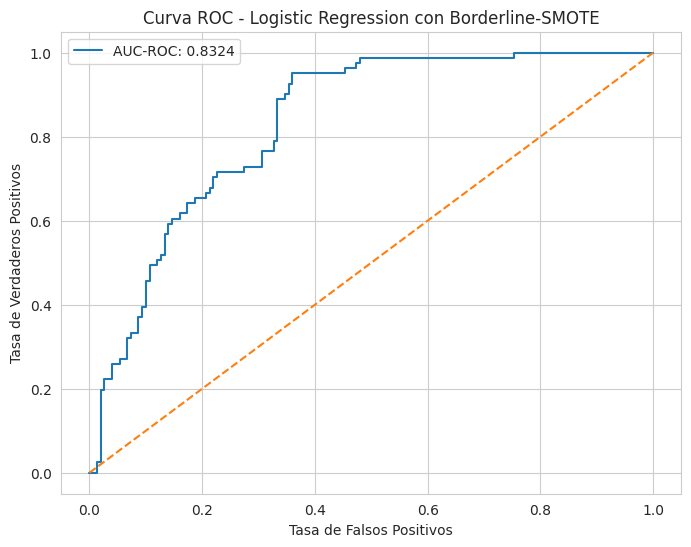

In [ ]:
from imblearn.over_sampling import BorderlineSMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix, roc_curve
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Preparar los datos
X = df_imputed[selected_features]
y = df_imputed['Outcome']

# 2. Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# 3. Definir la técnica de balanceo (Borderline-SMOTE)
borderline_smote = BorderlineSMOTE(random_state=42)

# 4. Crear el pipeline con Borderline-SMOTE y Logistic Regression
pipeline_lr_borderline = ImbPipeline([
    ('scaler', StandardScaler()),  # Escalado de características
    ('borderline_smote', borderline_smote),  # Técnica de balanceo Borderline-SMOTE
    ('classifier', LogisticRegression(max_iter=1000, random_state=42))  # Modelo Logistic Regression
])

# 5. Definir los parámetros para la búsqueda de hiperparámetros
param_grid_lr = {
    'classifier__C': [0.01, 0.1, 1],
    'classifier__penalty': ['l2'],  # Solo L2 para evitar incompatibilidades con Borderline-SMOTE
    'classifier__solver': ['liblinear', 'saga']
}

# 6. Realizar la búsqueda de hiperparámetros con GridSearchCV
grid_search_lr_borderline = GridSearchCV(
    pipeline_lr_borderline,
    param_grid_lr,
    cv=5,
    scoring='f1',
    n_jobs=-1,
    verbose=1
)
grid_search_lr_borderline.fit(X_train, y_train)

# Evaluar el mejor modelo en el conjunto de prueba
best_lr_borderline = grid_search_lr_borderline.best_estimator_
y_pred_lr_borderline = best_lr_borderline.predict(X_test)
y_prob_lr_borderline = best_lr_borderline.predict_proba(X_test)[:, 1]

print(f"Mejores parámetros encontrados: {grid_search_lr_borderline.best_params_}")

# Reporte de clasificación en el conjunto de prueba
print("\nReporte de clasificación para Logistic Regression con Borderline-SMOTE:")
print(classification_report(y_test, y_pred_lr_borderline))

# AUC-ROC
roc_auc_borderline = roc_auc_score(y_test, y_prob_lr_borderline)
print(f"AUC-ROC: {roc_auc_borderline:.4f}")

# Matriz de Confusión
cm = confusion_matrix(y_test, y_pred_lr_borderline)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Matriz de Confusión - Logistic Regression con Borderline-SMOTE')
plt.xlabel('Predicción')
plt.ylabel('Valor Real')
plt.show()

# Curva ROC
fpr, tpr, _ = roc_curve(y_test, y_prob_lr_borderline)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'AUC-ROC: {roc_auc_borderline:.4f}')
plt.plot([0, 1], linestyle='--')
plt.xlabel('Tasa de Falsos Positivos')
plt.ylabel('Tasa de Verdaderos Positivos')
plt.title('Curva ROC - Logistic Regression con Borderline-SMOTE')
plt.legend()
plt.show()


Fitting 5 folds for each of 12 candidates, totalling 60 fits
Mejores parámetros encontrados: {'classifier__C': 0.1, 'classifier__gamma': 'scale', 'classifier__kernel': 'rbf'}

Reporte de clasificación para SVM con Borderline-SMOTE:
              precision    recall  f1-score   support

           0       0.89      0.62      0.73       150
           1       0.55      0.85      0.67        81

    accuracy                           0.70       231
   macro avg       0.72      0.74      0.70       231
weighted avg       0.77      0.70      0.71       231

AUC-ROC: 0.8184


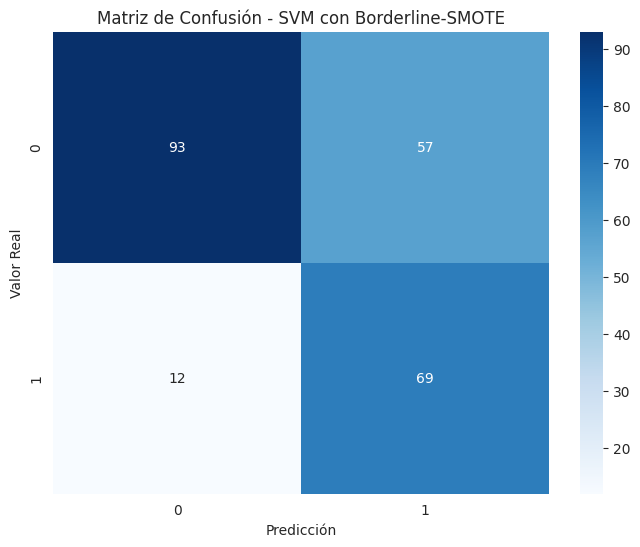

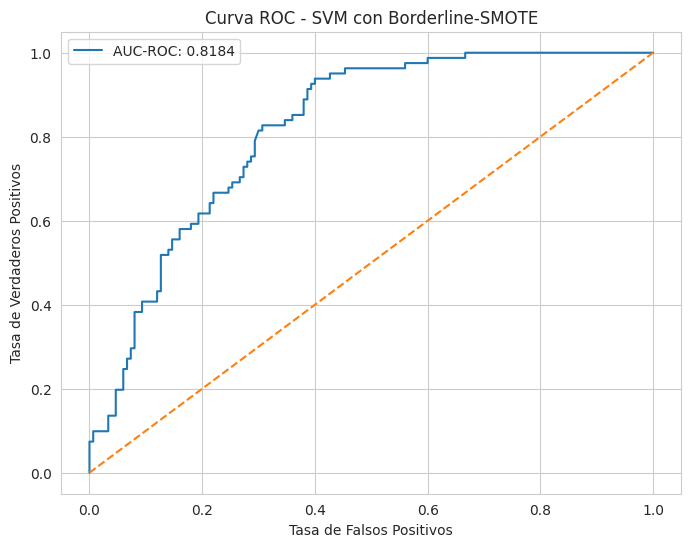

In [ ]:
from imblearn.over_sampling import BorderlineSMOTE
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix, roc_curve
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Preparar los datos
X = df_imputed[selected_features]
y = df_imputed['Outcome']

# 2. Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# 3. Definir la técnica de balanceo (Borderline-SMOTE)
borderline_smote = BorderlineSMOTE(random_state=42)

# 4. Crear el pipeline con Borderline-SMOTE y SVM
pipeline_svm_borderline = ImbPipeline([
    ('scaler', StandardScaler()),  # Escalado de características
    ('borderline_smote', borderline_smote),  # Técnica de balanceo Borderline-SMOTE
    ('classifier', SVC(probability=True, random_state=42))  # Modelo SVM con probabilidad habilitada
])

# 5. Definir los parámetros para la búsqueda de hiperparámetros
param_grid_svm = {
    'classifier__C': [0.1, 1, 10],
    'classifier__kernel': ['linear', 'rbf'],
    'classifier__gamma': ['scale', 'auto']
}

# 6. Realizar la búsqueda de hiperparámetros con GridSearchCV
grid_search_svm_borderline = GridSearchCV(
    pipeline_svm_borderline,
    param_grid_svm,
    cv=5,
    scoring='f1',
    n_jobs=-1,
    verbose=1
)
grid_search_svm_borderline.fit(X_train, y_train)

# Evaluar el mejor modelo en el conjunto de prueba
best_svm_borderline = grid_search_svm_borderline.best_estimator_
y_pred_svm_borderline = best_svm_borderline.predict(X_test)
y_prob_svm_borderline = best_svm_borderline.predict_proba(X_test)[:, 1]

print(f"Mejores parámetros encontrados: {grid_search_svm_borderline.best_params_}")

# Reporte de clasificación en el conjunto de prueba
print("\nReporte de clasificación para SVM con Borderline-SMOTE:")
print(classification_report(y_test, y_pred_svm_borderline))

# AUC-ROC
roc_auc_borderline = roc_auc_score(y_test, y_prob_svm_borderline)
print(f"AUC-ROC: {roc_auc_borderline:.4f}")

# Matriz de Confusión
cm = confusion_matrix(y_test, y_pred_svm_borderline)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Matriz de Confusión - SVM con Borderline-SMOTE')
plt.xlabel('Predicción')
plt.ylabel('Valor Real')
plt.show()

# Curva ROC
fpr, tpr, _ = roc_curve(y_test, y_prob_svm_borderline)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'AUC-ROC: {roc_auc_borderline:.4f}')
plt.plot([0, 1], linestyle='--')
plt.xlabel('Tasa de Falsos Positivos')
plt.ylabel('Tasa de Verdaderos Positivos')
plt.title('Curva ROC - SVM con Borderline-SMOTE')
plt.legend()
plt.show()


CONCLUSIONES PARA REGRESION LOGISTICA
- Si el objetivo principal es maximizar el recall para identificar correctamente la mayor cantidad de pacientes con diabetes:
Utilizaremos ADASYN, ya que logra el mayor recall para la Clase Positiva (78%) y reduce los falsos negativos (FN =18).

- Si buscamos un equilibrio entre precisión, recall y AUC alto:
Utilizaremos SMOTETomek, que ofrece el mejor AUC (0.8355) y un buen balance entre las métricas clave.

- Decisión Final:
Dado que identificar pacientes con diabetes es crítico en este proyecto, priorizaremos un modelo con alto recall. Por lo tanto continuaremos trabajando con ADASYN como técnica principal.

CONCLUSIONES PARA SVM
- Si buscamos un modelo equilibrado con buen desempeño general y alta capacidad discriminativa (AUC más alto):
Utilizaríamos SMOTETomek, ya que tiene el mejor AUC (0.8358) y un buen balance entre precisión y recall.

- Si priorizamos maximizar el recall para identificar correctamente la mayor cantidad de pacientes con diabetes (minimizar falsos negativos):
Borderline-SMOTE sería la mejor opción, ya que logra el mayor recall para la Clase Positiva (85%) y reduce los falsos negativos a solo 12.

- Si queremos un compromiso entre recall alto y precisión aceptable para la Clase Positiva:
ADASYN es una alternativa sólida, con un recall competitivo (83%) y un AUC razonable (0.8238).

- Decisión Final
Dado que en este proyecto es crucial identificar correctamente a los pacientes con diabetes, priorizaremos el recall para minimizar falsos negativos. Por lo tanto, continuaremos trabajando con Borderline-SMOTE como técnica principal.


---

## Balanceo de los pesos de clase:
Ajustaremos los pesos de clase. Esto puede ayudar a mejorar el rendimiento del modelo en la clase minoritaria. Esto es especialmente útil si el desequilibrio sigue siendo un problema después de aplicar Adasyn para regresión logística o de palicar Borderline-SMOTE para SVM. Lo hacemos estableciendo el parámetro class_weight='balanced'.

Fitting 5 folds for each of 6 candidates, totalling 30 fits
Mejores parámetros encontrados: {'classifier__C': 0.01, 'classifier__penalty': 'l2', 'classifier__solver': 'liblinear'}

Reporte de clasificación para Logistic Regression con ADASYN y class_weight='balanced':
              precision    recall  f1-score   support

           0       0.87      0.69      0.77       150
           1       0.58      0.80      0.67        81

    accuracy                           0.73       231
   macro avg       0.72      0.74      0.72       231
weighted avg       0.77      0.73      0.73       231

AUC-ROC: 0.8314


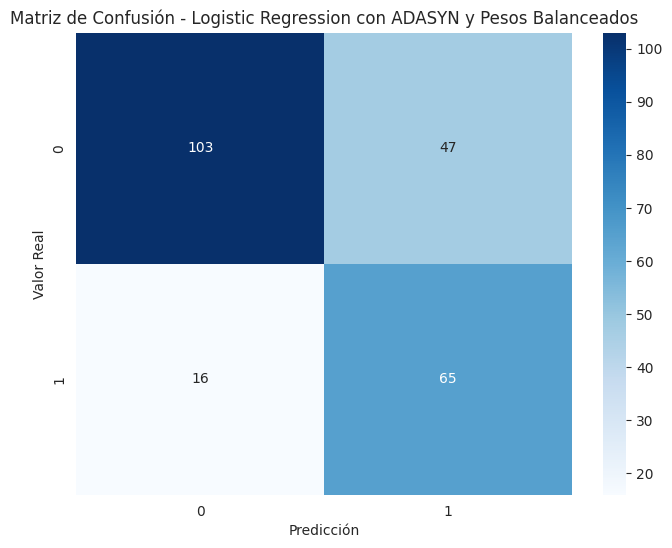

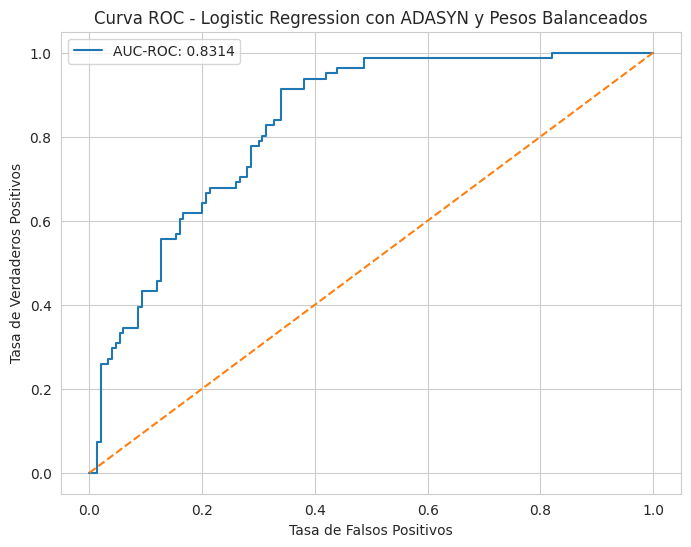

In [ ]:
from imblearn.over_sampling import ADASYN
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix, roc_curve
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Preparar los datos
X = df_imputed[selected_features]
y = df_imputed['Outcome']

# 2. Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# 3. Definir la técnica de balanceo (ADASYN)
adasyn = ADASYN(random_state=42)

# 4. Crear el pipeline con escalado, ADASYN y Logistic Regression con class_weight='balanced'
pipeline_lr_adasyn_balanced = ImbPipeline([
    ('scaler', StandardScaler()),  # Escalado de características
    ('adasyn', adasyn),            # Técnica de balanceo ADASYN
    ('classifier', LogisticRegression(max_iter=1000, class_weight='balanced', random_state=42))  # Modelo Logistic Regression
])

# 5. Definir los parámetros para la búsqueda de hiperparámetros
param_grid_lr = {
    'classifier__C': [0.01, 0.1, 1],
    'classifier__penalty': ['l2'],
    'classifier__solver': ['liblinear', 'saga']
}

# 6. Realizar la búsqueda de hiperparámetros con GridSearchCV
grid_search_lr_adasyn_balanced = GridSearchCV(
    pipeline_lr_adasyn_balanced,
    param_grid_lr,
    cv=5,
    scoring='f1',
    n_jobs=-1,
    verbose=1
)
grid_search_lr_adasyn_balanced.fit(X_train, y_train)

# Evaluar el mejor modelo en el conjunto de prueba
best_lr_adasyn_balanced = grid_search_lr_adasyn_balanced.best_estimator_
y_pred_lr_adasyn_balanced = best_lr_adasyn_balanced.predict(X_test)
y_prob_lr_adasyn_balanced = best_lr_adasyn_balanced.predict_proba(X_test)[:, 1]

print(f"Mejores parámetros encontrados: {grid_search_lr_adasyn_balanced.best_params_}")

# Reporte de clasificación en el conjunto de prueba
print("\nReporte de clasificación para Logistic Regression con ADASYN y class_weight='balanced':")
print(classification_report(y_test, y_pred_lr_adasyn_balanced))

# AUC-ROC
roc_auc_adasyn_balanced = roc_auc_score(y_test, y_prob_lr_adasyn_balanced)
print(f"AUC-ROC: {roc_auc_adasyn_balanced:.4f}")

# Matriz de Confusión
cm = confusion_matrix(y_test, y_pred_lr_adasyn_balanced)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Matriz de Confusión - Logistic Regression con ADASYN y Pesos Balanceados')
plt.xlabel('Predicción')
plt.ylabel('Valor Real')
plt.show()

# Curva ROC
fpr, tpr, _ = roc_curve(y_test, y_prob_lr_adasyn_balanced)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'AUC-ROC: {roc_auc_adasyn_balanced:.4f}')
plt.plot([0, 1], linestyle='--')
plt.xlabel('Tasa de Falsos Positivos')
plt.ylabel('Tasa de Verdaderos Positivos')
plt.title('Curva ROC - Logistic Regression con ADASYN y Pesos Balanceados')
plt.legend()
plt.show()


REGRESIÓN LOGÍSTICA SIN BALANCEO

Fitting 5 folds for each of 6 candidates, totalling 30 fits
Mejores parámetros encontrados: {'classifier__C': 0.01, 'classifier__penalty': 'l2', 'classifier__solver': 'liblinear'}

Reporte de clasificación para Logistic Regression con ADASYN sin balanceo de pesos:
              precision    recall  f1-score   support

           0       0.85      0.71      0.77       150
           1       0.59      0.78      0.67        81

    accuracy                           0.73       231
   macro avg       0.72      0.74      0.72       231
weighted avg       0.76      0.73      0.74       231

AUC-ROC: 0.8314


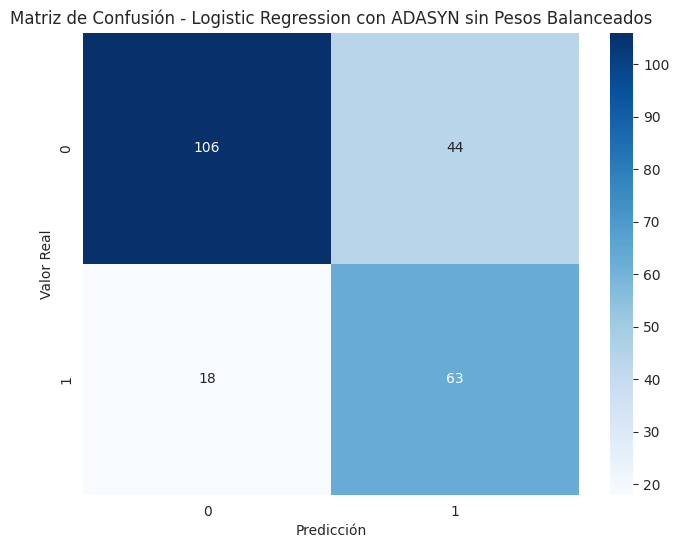

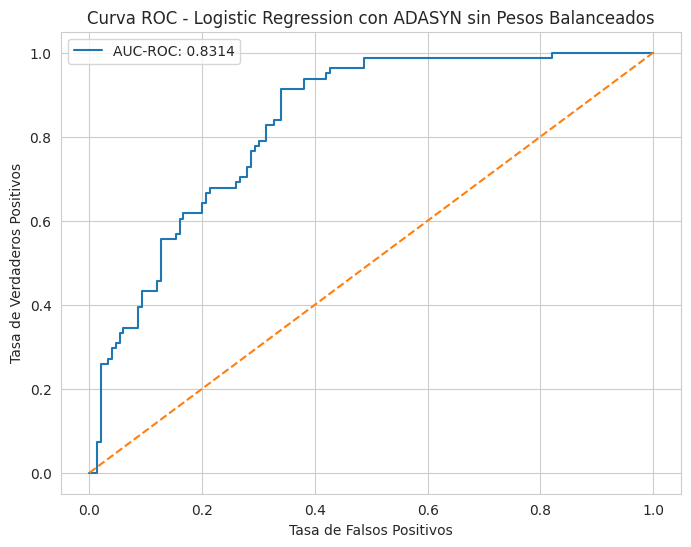

In [ ]:
from imblearn.over_sampling import ADASYN
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix, roc_curve
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Preparar los datos
X = df_imputed[selected_features]
y = df_imputed['Outcome']

# 2. Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# 3. Definir la técnica de balanceo (ADASYN)
adasyn = ADASYN(random_state=42)

# 4. Crear el pipeline con escalado, ADASYN y Logistic Regression sin balanceo de pesos
pipeline_lr_adasyn_no_balance = ImbPipeline([
    ('scaler', StandardScaler()),  # Escalado de características
    ('adasyn', adasyn),            # Técnica de balanceo ADASYN
    ('classifier', LogisticRegression(max_iter=1000, random_state=42))  # Modelo Logistic Regression sin class_weight='balanced'
])

# 5. Definir los parámetros para la búsqueda de hiperparámetros
param_grid_lr_no_balance = {
    'classifier__C': [0.01, 0.1, 1],
    'classifier__penalty': ['l2'],
    'classifier__solver': ['liblinear', 'saga']
}

# 6. Realizar la búsqueda de hiperparámetros con GridSearchCV
grid_search_lr_adasyn_no_balance = GridSearchCV(
    pipeline_lr_adasyn_no_balance,
    param_grid_lr_no_balance,
    cv=5,
    scoring='f1',
    n_jobs=-1,
    verbose=1
)
grid_search_lr_adasyn_no_balance.fit(X_train, y_train)

# Evaluar el mejor modelo en el conjunto de prueba
best_lr_adasyn_no_balance = grid_search_lr_adasyn_no_balance.best_estimator_
y_pred_lr_adasyn_no_balance = best_lr_adasyn_no_balance.predict(X_test)
y_prob_lr_adasyn_no_balance = best_lr_adasyn_no_balance.predict_proba(X_test)[:, 1]

print(f"Mejores parámetros encontrados: {grid_search_lr_adasyn_no_balance.best_params_}")

# Reporte de clasificación en el conjunto de prueba
print("\nReporte de clasificación para Logistic Regression con ADASYN sin balanceo de pesos:")
print(classification_report(y_test, y_pred_lr_adasyn_no_balance))

# AUC-ROC
roc_auc_adasyn_no_balance = roc_auc_score(y_test, y_prob_lr_adasyn_no_balance)
print(f"AUC-ROC: {roc_auc_adasyn_no_balance:.4f}")

# Matriz de Confusión
cm = confusion_matrix(y_test, y_pred_lr_adasyn_no_balance)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Matriz de Confusión - Logistic Regression con ADASYN sin Pesos Balanceados')
plt.xlabel('Predicción')
plt.ylabel('Valor Real')
plt.show()

# Curva ROC
fpr, tpr, _ = roc_curve(y_test, y_prob_lr_adasyn_no_balance)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'AUC-ROC: {roc_auc_adasyn_no_balance:.4f}')
plt.plot([0, 1], linestyle='--')
plt.xlabel('Tasa de Falsos Positivos')
plt.ylabel('Tasa de Verdaderos Positivos')
plt.title('Curva ROC - Logistic Regression con ADASYN sin Pesos Balanceados')
plt.legend()
plt.show()


HACENMOS LO MISMO PARA SVM, CON BALANCEO DE PESOS DE CLASE Y SIN EL

Fitting 5 folds for each of 12 candidates, totalling 60 fits
Mejores parámetros encontrados: {'classifier__C': 0.01, 'classifier__gamma': 'scale', 'classifier__kernel': 'linear'}

Reporte de clasificación para SVM con Borderline-SMOTE y class_weight='balanced':
              precision    recall  f1-score   support

           0       0.83      0.72      0.77       150
           1       0.58      0.73      0.65        81

    accuracy                           0.72       231
   macro avg       0.71      0.72      0.71       231
weighted avg       0.74      0.72      0.73       231

AUC-ROC: 0.8351


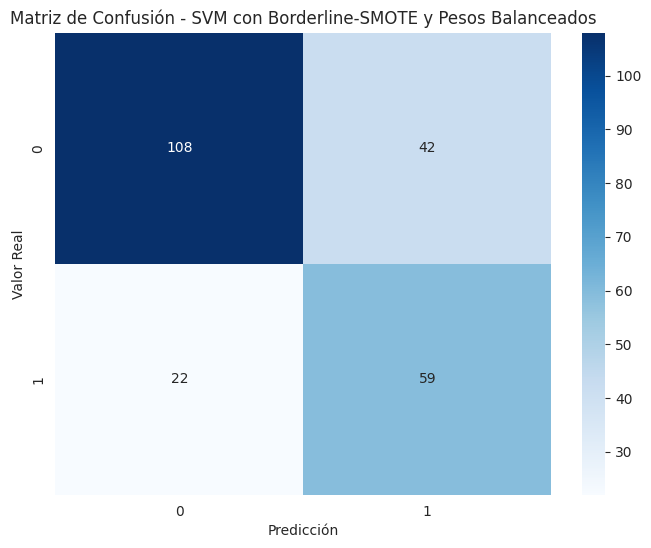

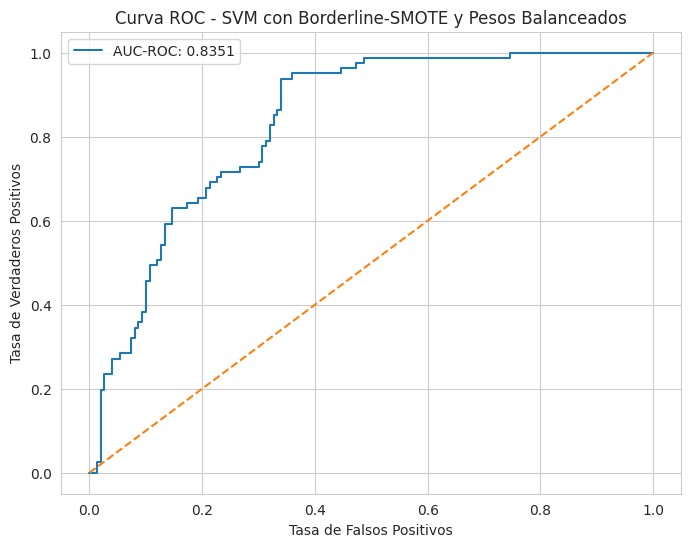

In [ ]:
from imblearn.over_sampling import BorderlineSMOTE
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, GridSearchCV
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix, roc_curve
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Preparar los datos
X = df_imputed[selected_features]
y = df_imputed['Outcome']

# 2. Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# 3. Definir la técnica de balanceo (Borderline-SMOTE)
borderline_smote = BorderlineSMOTE(random_state=42)

# 4. Crear el pipeline con escalado, Borderline-SMOTE y SVM con class_weight='balanced'
pipeline_svm_borderline_balanced = ImbPipeline([
    ('scaler', StandardScaler()),  # Escalado de características
    ('borderline_smote', borderline_smote),  # Técnica de balanceo Borderline-SMOTE
    ('classifier', SVC(probability=True, class_weight='balanced', random_state=42))  # Modelo SVM con probabilidad habilitada y pesos balanceados
])

# 5. Definir los parámetros para la búsqueda de hiperparámetros
param_grid_svm = {
    'classifier__C': [0.01, 0.1, 1],
    'classifier__kernel': ['linear', 'rbf'],
    'classifier__gamma': ['scale', 'auto']
}

# 6. Realizar la búsqueda de hiperparámetros con GridSearchCV
grid_search_svm_borderline_balanced = GridSearchCV(
    pipeline_svm_borderline_balanced,
    param_grid_svm,
    cv=5,
    scoring='f1',
    n_jobs=-1,
    verbose=1
)
grid_search_svm_borderline_balanced.fit(X_train, y_train)

# Evaluar el mejor modelo en el conjunto de prueba
best_svm_borderline_balanced = grid_search_svm_borderline_balanced.best_estimator_
y_pred_svm_borderline_balanced = best_svm_borderline_balanced.predict(X_test)
y_prob_svm_borderline_balanced = best_svm_borderline_balanced.predict_proba(X_test)[:, 1]

print(f"Mejores parámetros encontrados: {grid_search_svm_borderline_balanced.best_params_}")

# Reporte de clasificación en el conjunto de prueba
print("\nReporte de clasificación para SVM con Borderline-SMOTE y class_weight='balanced':")
print(classification_report(y_test, y_pred_svm_borderline_balanced))

# AUC-ROC
roc_auc_borderline_balanced = roc_auc_score(y_test, y_prob_svm_borderline_balanced)
print(f"AUC-ROC: {roc_auc_borderline_balanced:.4f}")

# Matriz de Confusión
cm = confusion_matrix(y_test, y_pred_svm_borderline_balanced)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Matriz de Confusión - SVM con Borderline-SMOTE y Pesos Balanceados')
plt.xlabel('Predicción')
plt.ylabel('Valor Real')
plt.show()

# Curva ROC
fpr, tpr, _ = roc_curve(y_test, y_prob_svm_borderline_balanced)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'AUC-ROC: {roc_auc_borderline_balanced:.4f}')
plt.plot([0, 1], linestyle='--')
plt.xlabel('Tasa de Falsos Positivos')
plt.ylabel('Tasa de Verdaderos Positivos')
plt.title('Curva ROC - SVM con Borderline-SMOTE y Pesos Balanceados')
plt.legend()
plt.show()


Fitting 5 folds for each of 12 candidates, totalling 60 fits
Mejores parámetros encontrados: {'classifier__C': 0.01, 'classifier__gamma': 'scale', 'classifier__kernel': 'linear'}

Reporte de clasificación para SVM con Borderline-SMOTE sin balanceo de pesos:
              precision    recall  f1-score   support

           0       0.83      0.72      0.77       150
           1       0.58      0.73      0.65        81

    accuracy                           0.72       231
   macro avg       0.71      0.72      0.71       231
weighted avg       0.74      0.72      0.73       231

AUC-ROC: 0.8351


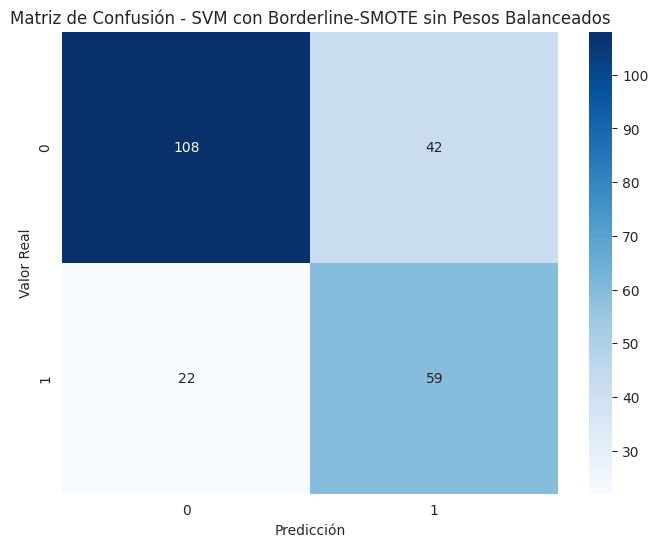

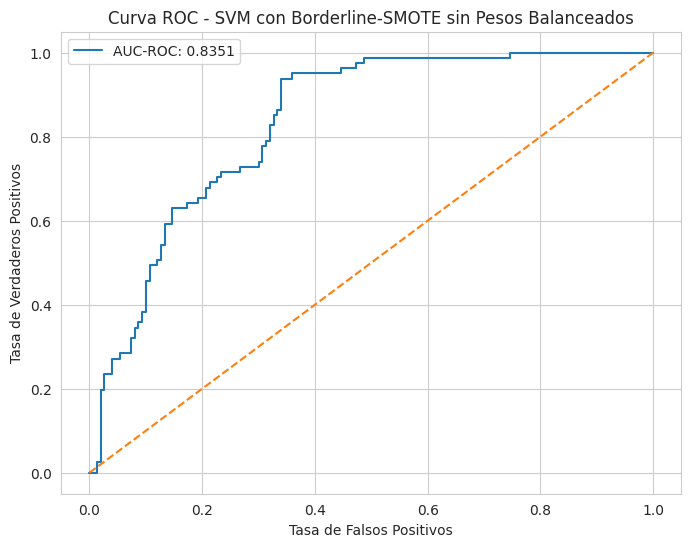

In [ ]:
# 1. Preparar los datos
X = df_imputed[selected_features]
y = df_imputed['Outcome']

# 2. Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# 3. Definir la técnica de balanceo (Borderline-SMOTE)
borderline_smote = BorderlineSMOTE(random_state=42)

# 4. Crear el pipeline con escalado, Borderline-SMOTE y SVM sin balanceo de pesos
pipeline_svm_borderline_no_balance = ImbPipeline([
    ('scaler', StandardScaler()),  # Escalado de características
    ('borderline_smote', borderline_smote),  # Técnica de balanceo Borderline-SMOTE
    ('classifier', SVC(probability=True, random_state=42))  # Modelo SVM sin class_weight='balanced'
])

# 5. Definir los parámetros para la búsqueda de hiperparámetros
param_grid_svm_no_balance = {
    'classifier__C': [0.01, 0.1, 1],
    'classifier__kernel': ['linear', 'rbf'],
    'classifier__gamma': ['scale', 'auto']
}

# 6. Realizar la búsqueda de hiperparámetros con GridSearchCV
grid_search_svm_borderline_no_balance = GridSearchCV(
    pipeline_svm_borderline_no_balance,
    param_grid_svm_no_balance,
    cv=5,
    scoring='f1',
    n_jobs=-1,
    verbose=1
)
grid_search_svm_borderline_no_balance.fit(X_train, y_train)

# Evaluar el mejor modelo en el conjunto de prueba
best_svm_borderline_no_balance = grid_search_svm_borderline_no_balance.best_estimator_
y_pred_svm_borderline_no_balance = best_svm_borderline_no_balance.predict(X_test)
y_prob_svm_borderline_no_balance = best_svm_borderline_no_balance.predict_proba(X_test)[:, 1]

print(f"Mejores parámetros encontrados: {grid_search_svm_borderline_no_balance.best_params_}")

# Reporte de clasificación en el conjunto de prueba
print("\nReporte de clasificación para SVM con Borderline-SMOTE sin balanceo de pesos:")
print(classification_report(y_test, y_pred_svm_borderline_no_balance))

# AUC-ROC
roc_auc_borderline_no_balance = roc_auc_score(y_test, y_prob_svm_borderline_no_balance)
print(f"AUC-ROC: {roc_auc_borderline_no_balance:.4f}")

# Matriz de Confusión
cm = confusion_matrix(y_test, y_pred_svm_borderline_no_balance)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Matriz de Confusión - SVM con Borderline-SMOTE sin Pesos Balanceados')
plt.xlabel('Predicción')
plt.ylabel('Valor Real')
plt.show()

# Curva ROC
fpr, tpr, _ = roc_curve(y_test, y_prob_svm_borderline_no_balance)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'AUC-ROC: {roc_auc_borderline_no_balance:.4f}')
plt.plot([0, 1], linestyle='--')
plt.xlabel('Tasa de Falsos Positivos')
plt.ylabel('Tasa de Verdaderos Positivos')
plt.title('Curva ROC - SVM con Borderline-SMOTE sin Pesos Balanceados')
plt.legend()
plt.show()


CONCLUSIONES:

PARA REGRESIÓN LOGÍSTICA:
- Ventajas del Balanceo de Pesos (class_weight='balanced'):
Mejora el recall para la clase positiva (80% vs. 78%), lo que es crucial para identificar correctamente pacientes con diabetes.

- Reduce los falsos negativos en la clase positiva (FN =16 vs. FN =18).

- Ventajas sin Balanceo de Pesos:
Tiene una mejor precisión para la clase positiva (59% vs. 58%) debido a un menor número de falsos positivos en la clase negativa.
Mantiene un mejor equilibrio entre precisión y recall para ambas clases.

- Decisión Final:
Dado que nuestro objetivo es identificar correctamente la mayor cantidad de pacientes con diabetes, priorizaremos el modelo con mayor recall para la clase positiva. Por lo tanto, continuaremos trabajando con Regresión Logística utilizando ADASYN y balanceo de pesos (class_weight='balanced').



PARA SVM:
- En este caso, no se observan diferencias en las métricas clave ni en el AUC-ROC al aplicar balanceo de pesos.
Esto sugiere que el uso de Borderline-SMOTE ya compensa suficientemente el desbalance de clases, haciendo que el ajuste adicional de pesos no tenga un impacto significativo.
- Continuaremos trabajando con SVM utilizando Borderline-SMOTE sin balanceo de pesos, ya que ofrece el mismo desempeño sin la complejidad adicional del ajuste automático de pesos.

---

## BUSCAMOS EL MEJOR CUT OFF PARA NUESRO MODELO
Evaluación de diferentes umbrales de clasificación:
Definiremos un rango de umbrales (cutoffs) de 0.1 a 0.9 con incrementos de 0.1.

- Para cada umbral:
Generaremos predicciones binarias basadas en el umbral.
Calcularemos métricas de rendimiento (precisión, recall, F1-score) para ambas clases y la exactitud global.
- Cambiar el umbral permite ajustar el balance entre precisión y recall, lo que es especialmente útil en problemas con desbalance de clases como este.

Fitting 5 folds for each of 6 candidates, totalling 30 fits
   cutoff  precision_0  recall_0  f1_score_0  precision_1  recall_1  \
0     0.1     0.000000  0.000000    0.000000     0.350649  1.000000   
1     0.2     1.000000  0.046667    0.089172     0.361607  1.000000   
2     0.3     0.975610  0.266667    0.418848     0.421053  0.987654   
3     0.4     0.964286  0.540000    0.692308     0.530612  0.962963   
4     0.5     0.865546  0.686667    0.765799     0.580357  0.802469   
5     0.6     0.782609  0.840000    0.810289     0.657143  0.567901   
6     0.7     0.724490  0.946667    0.820809     0.771429  0.333333   
7     0.8     0.660714  0.986667    0.791444     0.714286  0.061728   
8     0.9     0.649351  1.000000    0.787402     0.000000  0.000000   

   f1_score_1  accuracy  
0    0.519231  0.350649  
1    0.531148  0.380952  
2    0.590406  0.519481  
3    0.684211  0.688312  
4    0.673575  0.727273  
5    0.609272  0.744589  
6    0.465517  0.731602  
7    0.113636  0.6623

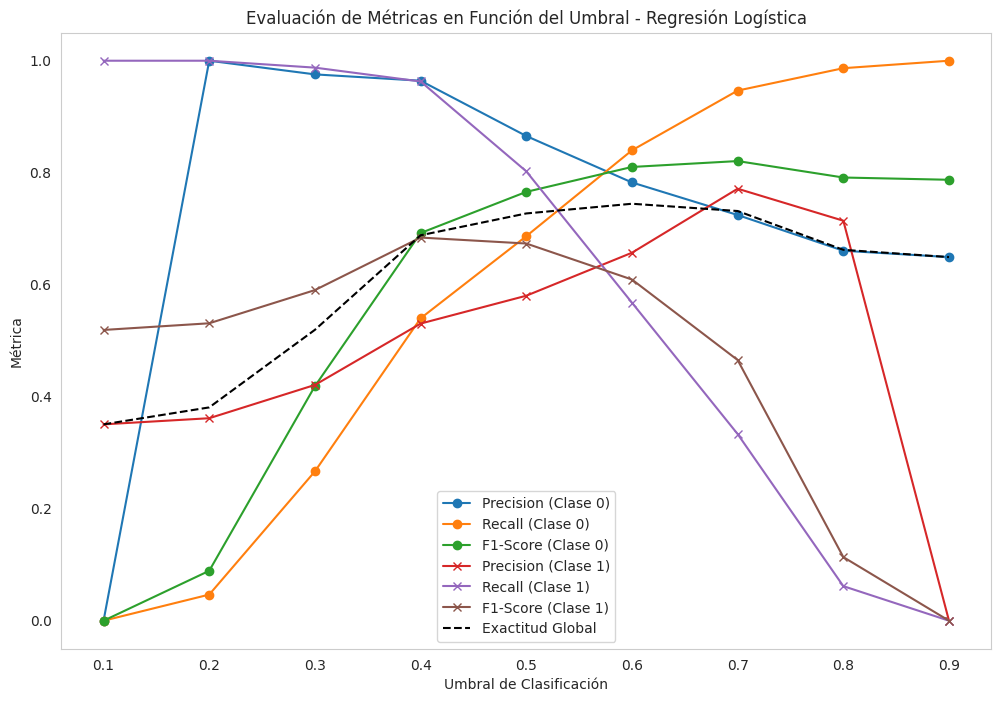

In [ ]:
from sklearn.metrics import classification_report, accuracy_score
# 1. Preparar los datos
X = df_imputed[selected_features]
y = df_imputed['Outcome']

# 2. Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# 3. Definir la técnica de balanceo (ADASYN)
adasyn = ADASYN(random_state=42)

# 4. Crear el pipeline con escalado, ADASYN y Logistic Regression con class_weight='balanced'
pipeline_lr_adasyn_balanced = ImbPipeline([
    ('scaler', StandardScaler()),  # Escalado de características
    ('adasyn', adasyn),            # Técnica de balanceo ADASYN
    ('classifier', LogisticRegression(max_iter=1000, class_weight='balanced', random_state=42))  # Modelo Logistic Regression
])

# 5. Definir los parámetros para la búsqueda de hiperparámetros
param_grid_lr = {
    'classifier__C': [0.01, 0.1, 1],
    'classifier__penalty': ['l2'],
    'classifier__solver': ['liblinear', 'saga']
}

# 6. Realizar la búsqueda de hiperparámetros con GridSearchCV
grid_search_lr_adasyn_balanced = GridSearchCV(
    pipeline_lr_adasyn_balanced,
    param_grid_lr,
    cv=5,
    scoring='f1',
    n_jobs=-1,
    verbose=1
)
grid_search_lr_adasyn_balanced.fit(X_train, y_train)

# Obtener las probabilidades del mejor modelo
best_lr_adasyn_balanced = grid_search_lr_adasyn_balanced.best_estimator_
y_prob_lr_adasyn_balanced = best_lr_adasyn_balanced.predict_proba(X_test)[:, 1]

# Evaluar métricas para un rango específico de cutoffs
cutoffs = np.arange(0.1, 1.0, 0.1)
results = []

for cutoff in cutoffs:
    # Generar predicciones binarias basadas en el umbral (cutoff)
    y_pred_cutoff = (y_prob_lr_adasyn_balanced >= cutoff).astype(int)

    # Calcular métricas utilizando classification_report
    report = classification_report(y_test, y_pred_cutoff, output_dict=True)

    # Almacenar métricas clave en un diccionario por cada cutoff
    results.append({
        'cutoff': cutoff,
        'precision_0': report['0']['precision'],
        'recall_0': report['0']['recall'],
        'f1_score_0': report['0']['f1-score'],
        'precision_1': report['1']['precision'],
        'recall_1': report['1']['recall'],
        'f1_score_1': report['1']['f1-score'],
        'accuracy': accuracy_score(y_test, y_pred_cutoff)
    })

# Convertir resultados a DataFrame para facilitar la visualización
df_results = pd.DataFrame(results)

# Mostrar los resultados para cada cutoff posible
print(df_results)

# Visualizar las métricas en función del cutoff
plt.figure(figsize=(12, 8))

plt.plot(df_results['cutoff'], df_results['precision_0'], label='Precision (Clase 0)', marker='o')
plt.plot(df_results['cutoff'], df_results['recall_0'], label='Recall (Clase 0)', marker='o')
plt.plot(df_results['cutoff'], df_results['f1_score_0'], label='F1-Score (Clase 0)', marker='o')

plt.plot(df_results['cutoff'], df_results['precision_1'], label='Precision (Clase 1)', marker='x')
plt.plot(df_results['cutoff'], df_results['recall_1'], label='Recall (Clase 1)', marker='x')
plt.plot(df_results['cutoff'], df_results['f1_score_1'], label='F1-Score (Clase 1)', marker='x')

plt.plot(df_results['cutoff'], df_results['accuracy'], label='Exactitud Global', linestyle='--', color='black')

plt.xlabel('Umbral de Clasificación')
plt.ylabel('Métrica')
plt.title('Evaluación de Métricas en Función del Umbral - Regresión Logística')
plt.legend()
plt.grid()
plt.show()


Fitting 5 folds for each of 12 candidates, totalling 60 fits
   cutoff  precision_0  recall_0  f1_score_0  precision_1  recall_1  \
0     0.1     1.000000  0.033333    0.064516     0.358407  1.000000   
1     0.2     0.977778  0.293333    0.451282     0.430108  0.987654   
2     0.3     0.986486  0.486667    0.651786     0.509554  0.987654   
3     0.4     0.951923  0.660000    0.779528     0.598425  0.938272   
4     0.5     0.832061  0.726667    0.775801     0.590000  0.728395   
5     0.6     0.810811  0.800000    0.805369     0.638554  0.654321   
6     0.7     0.750000  0.900000    0.818182     0.705882  0.444444   
7     0.8     0.710000  0.946667    0.811429     0.741935  0.283951   
8     0.9     0.659193  0.980000    0.788204     0.625000  0.061728   

   f1_score_1  accuracy  
0    0.527687  0.372294  
1    0.599251  0.536797  
2    0.672269  0.662338  
3    0.730769  0.757576  
4    0.651934  0.727273  
5    0.646341  0.748918  
6    0.545455  0.740260  
7    0.410714  0.714

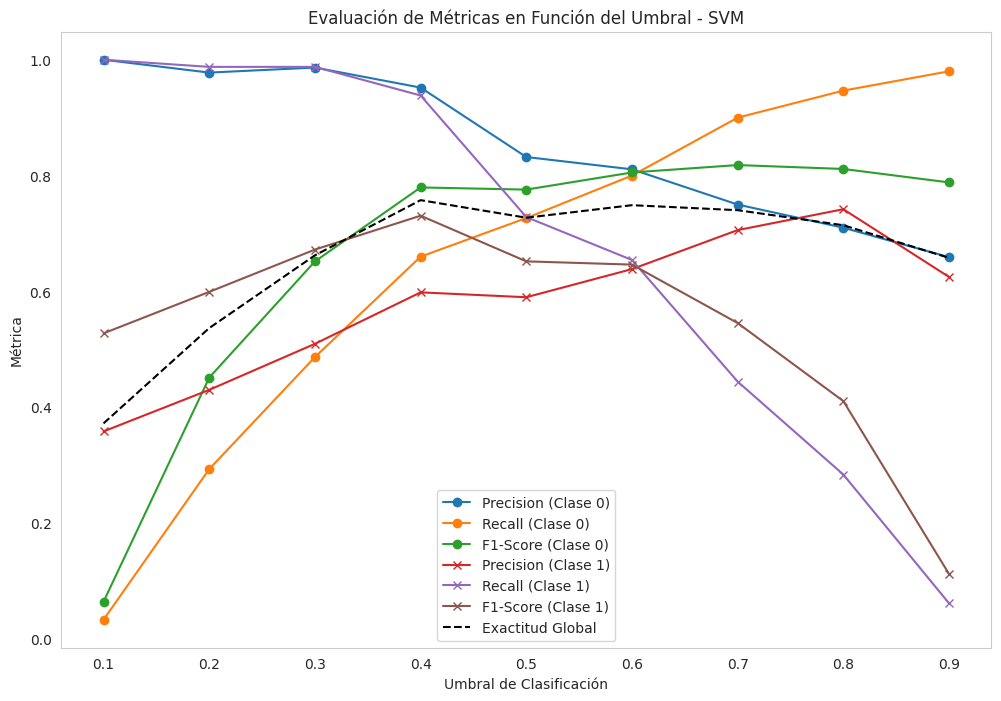

In [ ]:
# 1. Preparar los datos
X = df_imputed[selected_features]
y = df_imputed['Outcome']

# 2. Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# 3. Definir la técnica de balanceo (Borderline-SMOTE)
borderline_smote = BorderlineSMOTE(random_state=42)

# 4. Crear el pipeline con escalado, Borderline-SMOTE y SVM sin balanceo de pesos
pipeline_svm_borderline_no_balance = ImbPipeline([
    ('scaler', StandardScaler()),  # Escalado de características
    ('borderline_smote', borderline_smote),  # Técnica de balanceo Borderline-SMOTE
    ('classifier', SVC(probability=True, random_state=42))  # Modelo SVM sin class_weight='balanced'
])

# 5. Definir los parámetros para la búsqueda de hiperparámetros
param_grid_svm_no_balance = {
    'classifier__C': [0.01, 0.1, 1],
    'classifier__kernel': ['linear', 'rbf'],
    'classifier__gamma': ['scale', 'auto']
}

# 6. Realizar la búsqueda de hiperparámetros con GridSearchCV
grid_search_svm_borderline_no_balance = GridSearchCV(
    pipeline_svm_borderline_no_balance,
    param_grid_svm_no_balance,
    cv=5,
    scoring='f1',
    n_jobs=-1,
    verbose=1
)
grid_search_svm_borderline_no_balance.fit(X_train, y_train)

# Obtener las probabilidades del mejor modelo
best_svm_borderline_no_balance = grid_search_svm_borderline_no_balance.best_estimator_
y_prob_svm_borderline_no_balance = best_svm_borderline_no_balance.predict_proba(X_test)[:, 1]

# Evaluar métricas para un rango específico de cutoffs
cutoffs = np.arange(0.1, 1.0, 0.1)
results = []

for cutoff in cutoffs:
    # Generar predicciones binarias basadas en el umbral (cutoff)
    y_pred_cutoff = (y_prob_svm_borderline_no_balance >= cutoff).astype(int)

    # Calcular métricas utilizando classification_report
    report = classification_report(y_test, y_pred_cutoff, output_dict=True)

    # Almacenar métricas clave en un diccionario por cada cutoff
    results.append({
        'cutoff': cutoff,
        'precision_0': report['0']['precision'],
        'recall_0': report['0']['recall'],
        'f1_score_0': report['0']['f1-score'],
        'precision_1': report['1']['precision'],
        'recall_1': report['1']['recall'],
        'f1_score_1': report['1']['f1-score'],
        'accuracy': accuracy_score(y_test, y_pred_cutoff)
    })

# Convertir resultados a DataFrame para facilitar la visualización
df_results = pd.DataFrame(results)

# Mostrar los resultados para cada cutoff posible
print(df_results)

# Visualizar las métricas en función del cutoff
plt.figure(figsize=(12, 8))

plt.plot(df_results['cutoff'], df_results['precision_0'], label='Precision (Clase 0)', marker='o')
plt.plot(df_results['cutoff'], df_results['recall_0'], label='Recall (Clase 0)', marker='o')
plt.plot(df_results['cutoff'], df_results['f1_score_0'], label='F1-Score (Clase 0)', marker='o')

plt.plot(df_results['cutoff'], df_results['precision_1'], label='Precision (Clase 1)', marker='x')
plt.plot(df_results['cutoff'], df_results['recall_1'], label='Recall (Clase 1)', marker='x')
plt.plot(df_results['cutoff'], df_results['f1_score_1'], label='F1-Score (Clase 1)', marker='x')

plt.plot(df_results['cutoff'], df_results['accuracy'], label='Exactitud Global', linestyle='--', color='black')

plt.xlabel('Umbral de Clasificación')
plt.ylabel('Métrica')
plt.title('Evaluación de Métricas en Función del Umbral - SVM')
plt.legend()
plt.grid()
plt.show()


CONCLUSIONES:

- REGRESIÓN LOGÍSTICA: El gráfico muestra que el F1-score para la Clase Positiva (Clase 1) alcanza su máximo en cutoff = 0.5 (68%), lo que indica un buen equilibrio entre precisión y recall.
La exactitud global también es alta en este punto (73%), mientras que el recall para la Clase Positiva es razonablemente alto (~80%).

- SVM: El gráfico muestra que el F1-score para la Clase Positiva (Clase 1) alcanza su máximo en cutoff = 0.4 (73%), lo que indica un excelente equilibrio entre precisión (60%) y recall (94%).
La exactitud global también es alta en este punto (76%), lo que refuerza la elección de este cutoff.



---

VAMOS A INTENTAR MEJORAR EL RENDIMINETO DE LSO MODELOS, PARA ELLO VAMOS A:

REGRESIN LOGISTICA:

- Búsqueda Exhaustiva de Hiperparámetros:
Ajustaremos el parámetro de regularización C en un rango más amplio ([0.001, 0.01, 0.1, 1, 10, 100]) para encontrar el valor óptimo que equilibre precisión y recall.
- Probaremos diferentes solvers (liblinear, saga, newton-cg) para evaluar su impacto en la convergencia y estabilidad del modelo.
- Exploraremos la penalización l1 si es compatible con el solver seleccionado, ya que puede mejorar la selección de características relevantes.
- Ajuste Manual de Pesos de Clase:
Evaluaremos valores específicos para class_weight (por ejemplo, {0: x, 1: y}) para priorizar aún más la clase positiva (diabetes) y reducir falsos negativos.
- Validación Cruzada:
Implementaremos validación cruzada más exhaustiva para garantizar que los resultados sean representativos y robustos.


SVM:

- Búsqueda Exhaustiva de Hiperparámetros:
Ajustaremos el parámetro de regularización C en un rango más amplio ([0.001, 0.01, 0.1, 1, 10]) para controlar mejor el equilibrio entre margen amplio y ajuste preciso.
- Probaremos diferentes kernels (linear, rbf, poly, sigmoid) para evaluar cuál se adapta mejor a los datos.
- Ajustaremos el parámetro gamma en caso de utilizar kernels no lineales (rbf, poly) con valores como 'scale', 'auto', o específicos ([0.001, 0.01, 0.1]).
- Validación Cruzada:
Implementaremos validación cruzada más exhaustiva para garantizar que los resultados sean representativos y robustos.
- Sin Ajuste Manual de Pesos:
Mantendremos la configuración sin balanceo de pesos (class_weight=None), ya que los resultados actuales muestran que Borderline-SMOTE compensa suficientemente el desbalance.



Fitting 5 folds for each of 18 candidates, totalling 90 fits
Mejores parámetros encontrados: {'classifier__C': 0.01, 'classifier__penalty': 'l2', 'classifier__solver': 'liblinear'}

Reporte de clasificación para Logistic Regression con ADASYN y class_weight='balanced':
              precision    recall  f1-score   support

           0       0.87      0.69      0.77       150
           1       0.58      0.80      0.67        81

    accuracy                           0.73       231
   macro avg       0.72      0.74      0.72       231
weighted avg       0.77      0.73      0.73       231

AUC-ROC: 0.8314


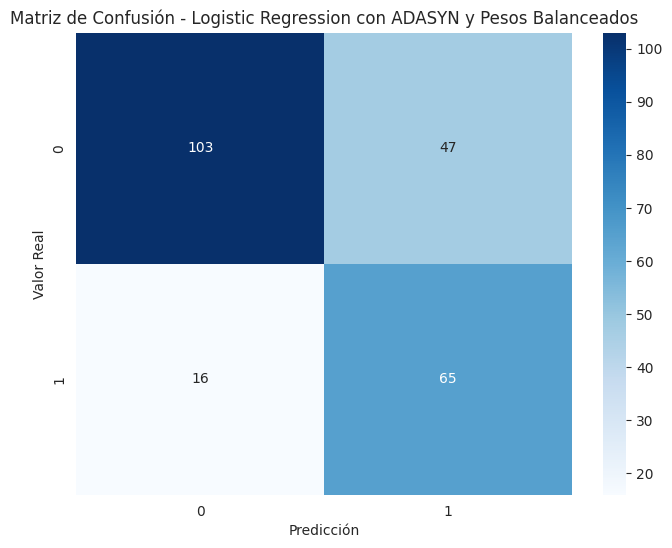

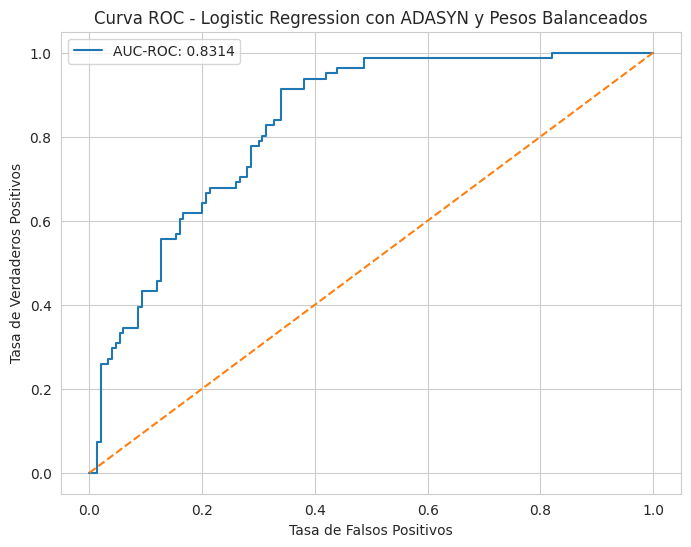

In [ ]:
# 1. Preparar los datos
X = df_imputed[selected_features]
y = df_imputed['Outcome']

# 2. Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# 3. Definir la técnica de balanceo (ADASYN)
adasyn = ADASYN(random_state=42)

# 4. Crear el pipeline con escalado, ADASYN y Logistic Regression con class_weight='balanced'
pipeline_lr_adasyn_balanced = ImbPipeline([
    ('scaler', StandardScaler()),  # Escalado de características
    ('adasyn', adasyn),            # Técnica de balanceo ADASYN
    ('classifier', LogisticRegression(max_iter=1000, class_weight='balanced', random_state=42))  # Modelo Logistic Regression
])

# 5. Definir los parámetros para la búsqueda de hiperparámetros
param_grid_lr = {
    'classifier__C': [0.001, 0.01, 0.1, 1, 10, 100],  # Regularización
    'classifier__penalty': ['l2'],                   # Penalización L2 (ridge)
    'classifier__solver': ['liblinear', 'saga', 'newton-cg']  # Solvers compatibles con L2
}

# 6. Realizar la búsqueda de hiperparámetros con GridSearchCV
grid_search_lr_adasyn_balanced = GridSearchCV(
    pipeline_lr_adasyn_balanced,
    param_grid_lr,
    cv=5,
    scoring='f1',
    n_jobs=-1,
    verbose=1
)
grid_search_lr_adasyn_balanced.fit(X_train, y_train)

# Evaluar el mejor modelo en el conjunto de prueba
best_lr_adasyn_balanced = grid_search_lr_adasyn_balanced.best_estimator_
y_prob_lr_adasyn_balanced = best_lr_adasyn_balanced.predict_proba(X_test)[:, 1]
y_pred_lr_adasyn_balanced = (y_prob_lr_adasyn_balanced >= 0.5).astype(int)  # Aplicar cutoff = 0.5

print(f"Mejores parámetros encontrados: {grid_search_lr_adasyn_balanced.best_params_}")

# Reporte de clasificación en el conjunto de prueba
print("\nReporte de clasificación para Logistic Regression con ADASYN y class_weight='balanced':")
print(classification_report(y_test, y_pred_lr_adasyn_balanced))

# AUC-ROC
roc_auc_adasyn_balanced = roc_auc_score(y_test, y_prob_lr_adasyn_balanced)
print(f"AUC-ROC: {roc_auc_adasyn_balanced:.4f}")

# Matriz de Confusión
cm = confusion_matrix(y_test, y_pred_lr_adasyn_balanced)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Matriz de Confusión - Logistic Regression con ADASYN y Pesos Balanceados')
plt.xlabel('Predicción')
plt.ylabel('Valor Real')
plt.show()

# Curva ROC
fpr, tpr, _ = roc_curve(y_test, y_prob_lr_adasyn_balanced)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'AUC-ROC: {roc_auc_adasyn_balanced:.4f}')
plt.plot([0, 1], linestyle='--')
plt.xlabel('Tasa de Falsos Positivos')
plt.ylabel('Tasa de Verdaderos Positivos')
plt.title('Curva ROC - Logistic Regression con ADASYN y Pesos Balanceados')
plt.legend()
plt.show()


Los resultados actuales muestran un rendimiento sólido, pero no se observa una mejora significativa tras la búsqueda exhaustiva de hiperparámetros. Esto sugiere que el modelo ya está cerca de su desempeño óptimo.

Fitting 5 folds for each of 20 candidates, totalling 100 fits
Mejores parámetros encontrados: {'classifier__C': 0.01, 'classifier__gamma': 'scale', 'classifier__kernel': 'linear'}

Reporte de clasificación para SVM con Borderline-SMOTE sin balanceo de pesos:
              precision    recall  f1-score   support

           0       0.95      0.66      0.78       150
           1       0.60      0.94      0.73        81

    accuracy                           0.76       231
   macro avg       0.78      0.80      0.76       231
weighted avg       0.83      0.76      0.76       231

AUC-ROC: 0.8351


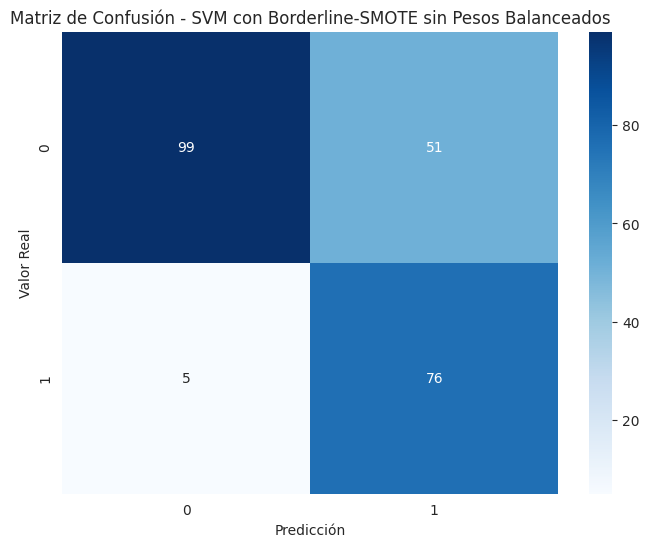

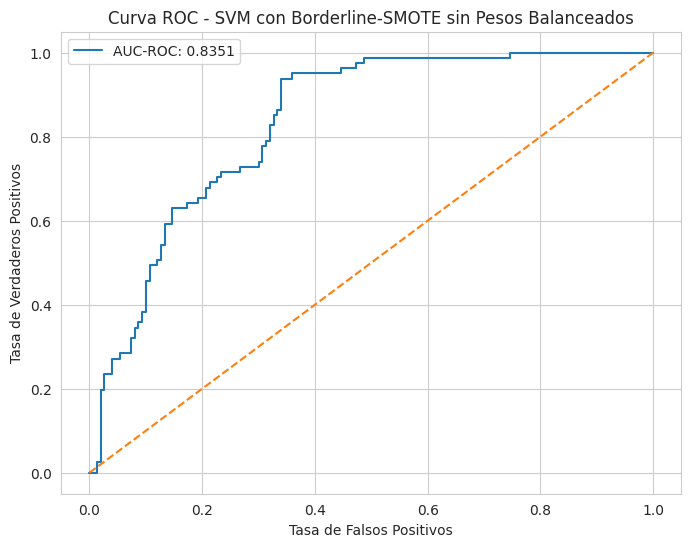

In [ ]:
# 1. Preparar los datos
X = df_imputed[selected_features]
y = df_imputed['Outcome']

# 2. Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# 3. Definir la técnica de balanceo (Borderline-SMOTE)
borderline_smote = BorderlineSMOTE(random_state=42)

# 4. Crear el pipeline con escalado, Borderline-SMOTE y SVM sin balanceo de pesos
pipeline_svm_borderline_no_balance = ImbPipeline([
    ('scaler', StandardScaler()),  # Escalado de características
    ('borderline_smote', borderline_smote),  # Técnica de balanceo Borderline-SMOTE
    ('classifier', SVC(probability=True, random_state=42))  # Modelo SVM sin class_weight='balanced'
])

# 5. Definir los parámetros para la búsqueda de hiperparámetros
param_grid_svm_no_balance = {
    'classifier__C': [0.001, 0.01, 0.1, 1, 10],       # Regularización
    'classifier__kernel': ['linear', 'rbf'],          # Tipos de kernel
    'classifier__gamma': ['scale', 'auto']            # Coeficiente del kernel
}

# 6. Realizar la búsqueda de hiperparámetros con GridSearchCV
grid_search_svm_borderline_no_balance = GridSearchCV(
    pipeline_svm_borderline_no_balance,
    param_grid_svm_no_balance,
    cv=5,
    scoring='f1',
    n_jobs=-1,
    verbose=1
)
grid_search_svm_borderline_no_balance.fit(X_train, y_train)

# Obtener las probabilidades del mejor modelo
best_svm_borderline_no_balance = grid_search_svm_borderline_no_balance.best_estimator_
y_prob_svm_borderline_no_balance = best_svm_borderline_no_balance.predict_proba(X_test)[:, 1]
y_pred_svm_borderline_no_balance = (y_prob_svm_borderline_no_balance >= 0.4).astype(int)  # Aplicar cutoff = 0.4

print(f"Mejores parámetros encontrados: {grid_search_svm_borderline_no_balance.best_params_}")

# Reporte de clasificación en el conjunto de prueba
print("\nReporte de clasificación para SVM con Borderline-SMOTE sin balanceo de pesos:")
print(classification_report(y_test, y_pred_svm_borderline_no_balance))

# AUC-ROC
roc_auc_borderline_no_balance = roc_auc_score(y_test, y_prob_svm_borderline_no_balance)
print(f"AUC-ROC: {roc_auc_borderline_no_balance:.4f}")

# Matriz de Confusión
cm = confusion_matrix(y_test, y_pred_svm_borderline_no_balance)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Matriz de Confusión - SVM con Borderline-SMOTE sin Pesos Balanceados')
plt.xlabel('Predicción')
plt.ylabel('Valor Real')
plt.show()

# Curva ROC
fpr, tpr, _ = roc_curve(y_test, y_prob_svm_borderline_no_balance)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'AUC-ROC: {roc_auc_borderline_no_balance:.4f}')
plt.plot([0, 1], linestyle='--')
plt.xlabel('Tasa de Falsos Positivos')
plt.ylabel('Tasa de Verdaderos Positivos')
plt.title('Curva ROC - SVM con Borderline-SMOTE sin Pesos Balanceados')
plt.legend()
plt.show()


El recall para la Clase Positiva ha mejorado significativamente (94% vs. valores anteriores menores a ~80%) tras la búsqueda exhaustiva.

La precisión para la Clase Positiva se mantiene moderada (60%) debido al enfoque en maximizar el recall.

El AUC sigue siendo consistente (0.8351) y refleja una buena capacidad discriminativa del modelo.

Los resultados actuales muestran un rendimiento sólido y una mejora significativa en el recall para la Clase Positiva tras la búsqueda exhaustiva de hiperparámetros. Esto sugiere que el modelo está optimizado para su objetivo principal: identificar correctamente pacientes con diabetes.

---

## ENSAMBLAJE DE MODELOS PARA VER SI MEJORAMOS NUESTROS RESULTAODS
- Ensamblaje por Votación (Voting Classifier): que combine las predicciones de Regresión Logística y SVM para obtener la predicción final. Es simple de implementar.
Útil si ambos modelos tienen un desempeño similar pero capturan patrones diferentes.
  - Votación dura: Predicción final basada en la mayoría de votos (clasificación binaria).
  - Votación blanda: Promedia las probabilidades predichas de los modelos y utiliza el promedio para tomar la decisión final.

- Ensamblaje por Apilamiento (Stacking Classifier): Utilizamos ambos modelos base (Regresión Logística y SVM) y un modelo final para combinar sus predicciones. Cada modelo puede capturar diferentes patrones en los datos. Utilizamos StratifiedKFold para asegurar un muestreo balanceado en cada pliegue durante el entrenamiento del modelo final. Utiliza ambos modelos base (Regresión Logística y SVM) para generar predicciones.
Un modelo final (por ejemplo, Random Forest o Gradient Boosting) combina estas predicciones para generar la clasificación final.
Utiliza StratifiedKFold para asegurar un muestreo balanceado durante el entrenamiento del modelo final.


VOTING CLASSIFIER - VOTACION BLANDA


Reporte de clasificación para Voting Classifier:
              precision    recall  f1-score   support

           0       0.83      0.73      0.78       150
           1       0.60      0.73      0.66        81

    accuracy                           0.73       231
   macro avg       0.71      0.73      0.72       231
weighted avg       0.75      0.73      0.74       231

AUC-ROC: 0.8336


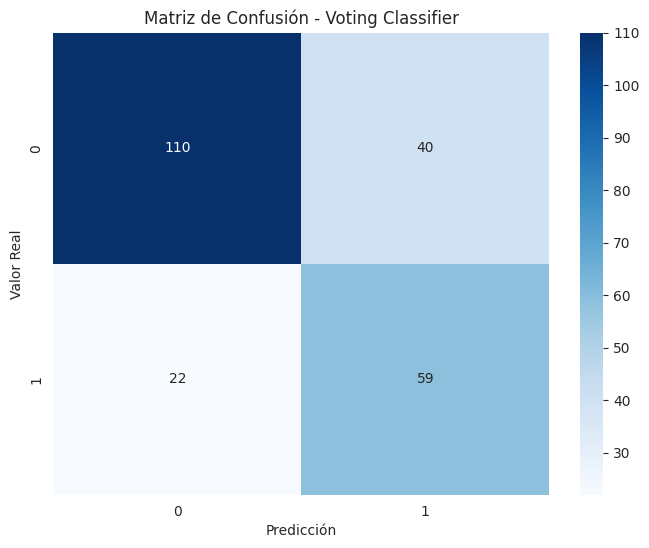

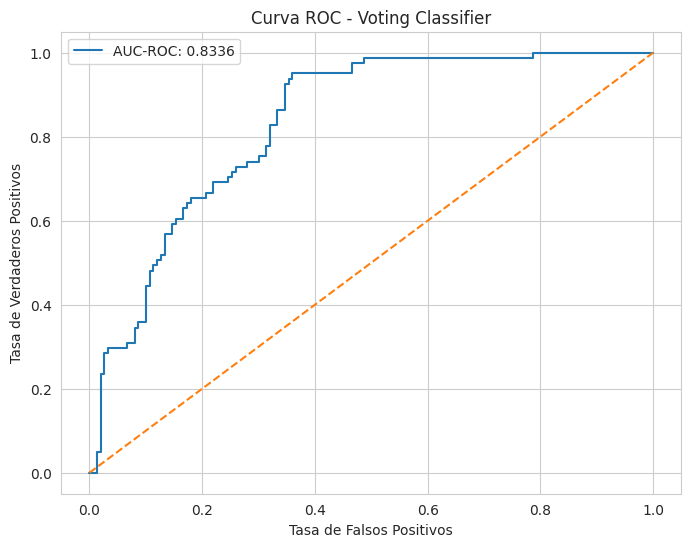

In [ ]:
from sklearn.ensemble import VotingClassifier
from sklearn.pipeline import Pipeline
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix, roc_curve
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Crear los pipelines para Regresión Logística y SVM
pipeline_lr = ImbPipeline([
    ('scaler', StandardScaler()),
    ('adasyn', ADASYN(random_state=42)),
    ('classifier', LogisticRegression(C=0.01, penalty='l2', solver='liblinear', class_weight='balanced', random_state=42))
])

pipeline_svm = ImbPipeline([
    ('scaler', StandardScaler()),
    ('borderline_smote', BorderlineSMOTE(random_state=42)),
    ('classifier', SVC(C=0.01, kernel='linear', gamma='scale', probability=True, random_state=42))
])

# 2. Crear el Voting Classifier
voting_clf = VotingClassifier(
    estimators=[('logreg', pipeline_lr), ('svm', pipeline_svm)],
    voting='soft'  # Votación blanda basada en probabilidades
)

# 3. Ajustar el modelo al conjunto de entrenamiento
voting_clf.fit(X_train, y_train)

# 4. Obtener las probabilidades del conjunto de prueba
y_prob_voting = voting_clf.predict_proba(X_test)[:, 1]
y_pred_voting = (y_prob_voting >= 0.5).astype(int)  # Aplicar cutoff = 0.5

# Reporte de clasificación
print("\nReporte de clasificación para Voting Classifier:")
print(classification_report(y_test, y_pred_voting))

# AUC-ROC
roc_auc_voting = roc_auc_score(y_test, y_prob_voting)
print(f"AUC-ROC: {roc_auc_voting:.4f}")

# Matriz de Confusión
cm = confusion_matrix(y_test, y_pred_voting)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Matriz de Confusión - Voting Classifier')
plt.xlabel('Predicción')
plt.ylabel('Valor Real')
plt.show()

# Curva ROC
fpr, tpr, _ = roc_curve(y_test, y_prob_voting)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'AUC-ROC: {roc_auc_voting:.4f}')
plt.plot([0, 1], linestyle='--')
plt.xlabel('Tasa de Falsos Positivos')
plt.ylabel('Tasa de Verdaderos Positivos')
plt.title('Curva ROC - Voting Classifier')
plt.legend()
plt.show()


VOTACION DURA


Reporte de clasificación para Voting Classifier con votación dura:
              precision    recall  f1-score   support

           0       0.83      0.74      0.78       150
           1       0.60      0.73      0.66        81

    accuracy                           0.74       231
   macro avg       0.72      0.73      0.72       231
weighted avg       0.75      0.74      0.74       231



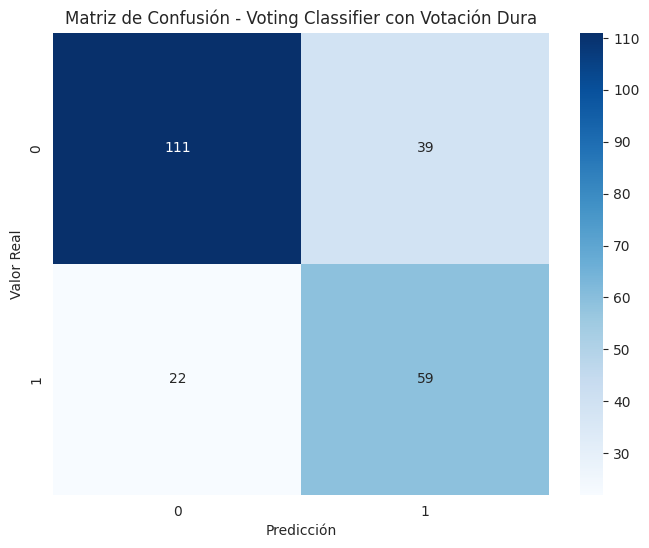

In [ ]:
from sklearn.ensemble import VotingClassifier
from sklearn.pipeline import Pipeline
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Crear los pipelines para Regresión Logística y SVM
pipeline_lr = ImbPipeline([
    ('scaler', StandardScaler()),
    ('adasyn', ADASYN(random_state=42)),
    ('classifier', LogisticRegression(C=0.01, penalty='l2', solver='liblinear', class_weight='balanced', random_state=42))
])

pipeline_svm = ImbPipeline([
    ('scaler', StandardScaler()),
    ('borderline_smote', BorderlineSMOTE(random_state=42)),
    ('classifier', SVC(C=0.01, kernel='linear', gamma='scale', probability=True, random_state=42))
])

# 2. Crear el Voting Classifier con votación dura
voting_clf_hard = VotingClassifier(
    estimators=[('logreg', pipeline_lr), ('svm', pipeline_svm)],
    voting='hard'  # Votación dura basada en la mayoría de votos
)

# 3. Ajustar el modelo al conjunto de entrenamiento
voting_clf_hard.fit(X_train, y_train)

# 4. Obtener las predicciones del conjunto de prueba
y_pred_voting_hard = voting_clf_hard.predict(X_test)

# Reporte de clasificación
print("\nReporte de clasificación para Voting Classifier con votación dura:")
print(classification_report(y_test, y_pred_voting_hard))

# Matriz de Confusión
cm = confusion_matrix(y_test, y_pred_voting_hard)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Matriz de Confusión - Voting Classifier con Votación Dura')
plt.xlabel('Predicción')
plt.ylabel('Valor Real')
plt.show()


Dado que el objetivo principal del proyecto es identificar correctamente pacientes con diabetes mientras mantenemos un buen equilibrio entre precisión y recall, optaremos por la estrategia de votación dura, ya que ofrece una ligera mejora en la exactitud global sin comprometer el desempeño en la Clase Positiva.

- Si priorizamos maximizar el recall para identificar correctamente pacientes con diabetes:
El modelo individual de SVM es la mejor opción, ya que logra un recall significativamente más alto (94%) mientras mantiene un F1-score competitivo (73%) y una excelente capacidad discriminativa (AUC = 0.8351).

- Si buscamos un equilibrio entre precisión y recall:
Regresión Logística es una alternativa sólida con un buen balance entre precisión (58%) y recall (80%) y un AUC competitivo (0.8314).

- Los ensamblajes de modelos (Voting Classifier) no ofrecen mejoras significativas frente a los modelos individuales, por lo que no son necesarios en este caso.

- Decisión Final:
Dado que identificar correctamente pacientes con diabetes es crítico en este proyecto, continuaremos trabajando con el modelo individual de SVM, ya que ofrece el mejor desempeño en términos de recall y capacidad discriminativa.

### Ensamblaje por Apilamiento (Stacking Classifier)


Reporte de clasificación para Stacking Classifier:
              precision    recall  f1-score   support

           0       0.80      0.79      0.80       150
           1       0.62      0.63      0.63        81

    accuracy                           0.74       231
   macro avg       0.71      0.71      0.71       231
weighted avg       0.74      0.74      0.74       231

AUC-ROC: 0.8074


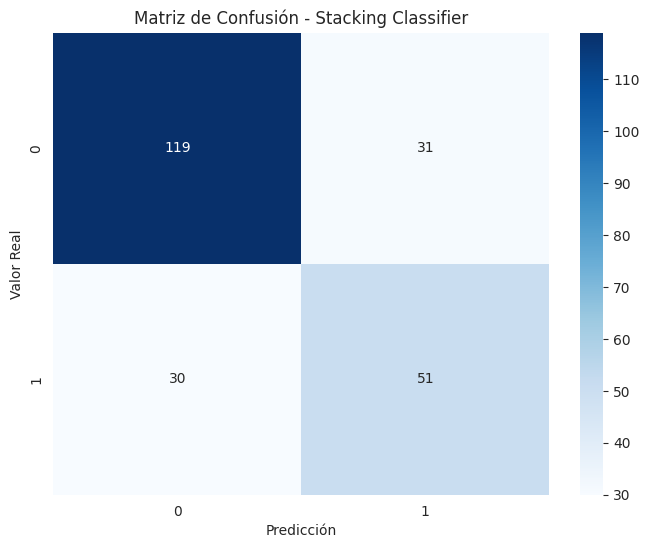

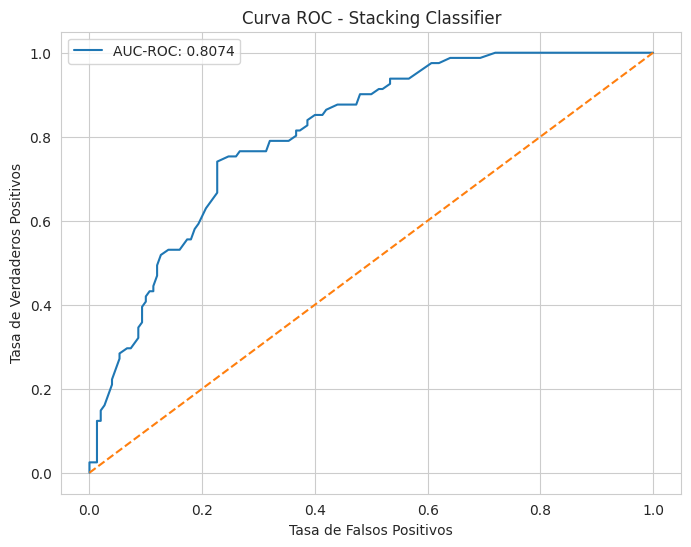

In [ ]:
 #1. Crear los pipelines para Regresión Logística y SVM
pipeline_lr = ImbPipeline([
    ('scaler', StandardScaler()),
    ('adasyn', ADASYN(random_state=42)),
    ('classifier', LogisticRegression(C=0.01, penalty='l2', solver='liblinear', class_weight='balanced', random_state=42))
])

pipeline_svm = ImbPipeline([
    ('scaler', StandardScaler()),
    ('borderline_smote', BorderlineSMOTE(random_state=42)),
    ('classifier', SVC(C=0.01, kernel='linear', gamma='scale', probability=True, random_state=42))
])

# 2. Definir el modelo final (meta-modelo)
meta_model = RandomForestClassifier(n_estimators=100, random_state=42)

# 3. Crear el Stacking Classifier
stacking_clf = StackingClassifier(
    estimators=[('logreg', pipeline_lr), ('svm', pipeline_svm)],
    final_estimator=meta_model,
    cv=StratifiedKFold(n_splits=5),  # Validación cruzada estratificada
    stack_method='predict_proba'  # Usar probabilidades de los modelos base como entrada del meta-modelo
)

# 4. Ajustar el modelo al conjunto de entrenamiento
stacking_clf.fit(X_train, y_train)

# 5. Obtener las probabilidades del conjunto de prueba
y_prob_stacking = stacking_clf.predict_proba(X_test)[:, 1]
y_pred_stacking = (y_prob_stacking >= 0.5).astype(int)  # Aplicar cutoff = 0.5

# Reporte de clasificación
print("\nReporte de clasificación para Stacking Classifier:")
print(classification_report(y_test, y_pred_stacking))

# AUC-ROC
roc_auc_stacking = roc_auc_score(y_test, y_prob_stacking)
print(f"AUC-ROC: {roc_auc_stacking:.4f}")

# Matriz de Confusión
cm = confusion_matrix(y_test, y_pred_stacking)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Matriz de Confusión - Stacking Classifier')
plt.xlabel('Predicción')
plt.ylabel('Valor Real')
plt.show()

# Curva ROC
fpr, tpr, _ = roc_curve(y_test, y_prob_stacking)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'AUC-ROC: {roc_auc_stacking:.4f}')
plt.plot([0, 1], linestyle='--')
plt.xlabel('Tasa de Falsos Positivos')
plt.ylabel('Tasa de Verdaderos Positivos')
plt.title('Curva ROC - Stacking Classifier')
plt.legend()
plt.show()


El Stacking Classifier no mejora significativamente los resultados frente a los modelos individuales o el Voting Classifier:

Tiene un desempeño moderado en ambas clases, pero su recall para la Clase Positiva es inferior al de SVM (63% vs. 94%) y su AUC es más bajo (0.8074 vs. 0.8351).
Dado que identificar correctamente pacientes con diabetes es crítico en este proyecto, continuaremos trabajando con el modelo individual de SVM, ya que ofrece el mejor desempeño en términos de recall y capacidad discriminativa.

PASAMOS A EVALUAR AMBOS MODELOS CON MEJORES HIPERPARAMETROS Y CROSS VALIDATION , FINALMENTE ESCOGEREMOS EL MEJOR MODELO Y SACAREMOS CONCLUIONES

Informe de Clasificación para Regresión Logística con Umbral = 0.5:
              precision    recall  f1-score   support

           0       0.87      0.69      0.77       150
           1       0.58      0.80      0.67        81

    accuracy                           0.73       231
   macro avg       0.72      0.74      0.72       231
weighted avg       0.77      0.73      0.73       231



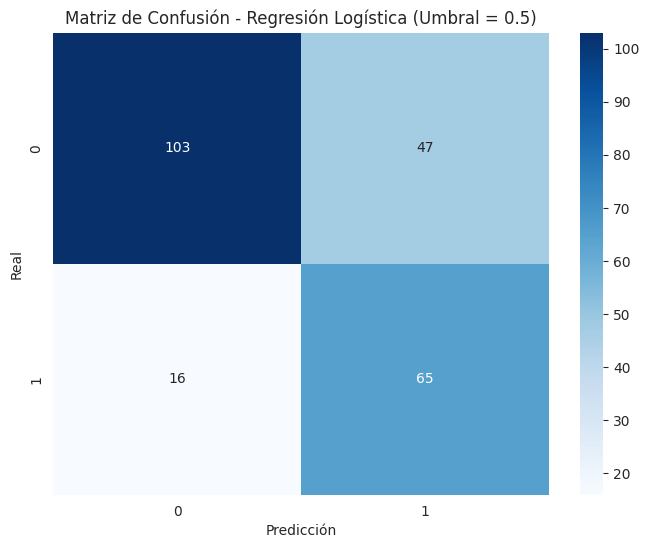

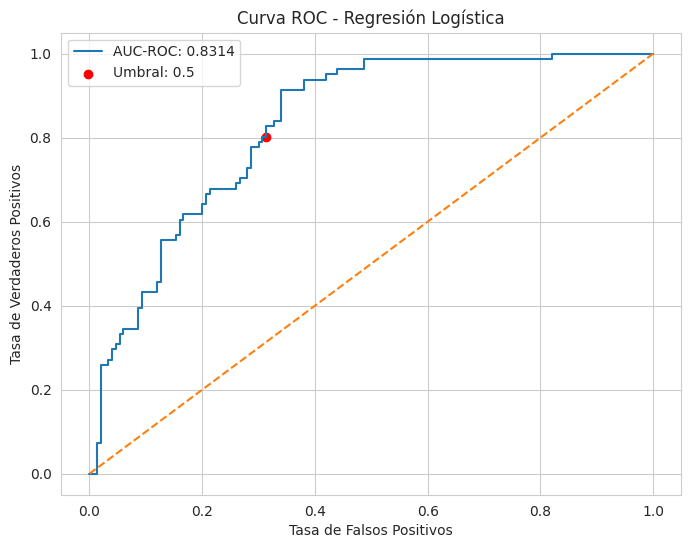

AUC-ROC en conjunto de prueba: 0.8314


In [ ]:
# Preparación de los datos
X = df_imputed[selected_features]
y = df_imputed['Outcome']

# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)

# Configurar validación cruzada estratificada
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Crear el pipeline con ADASYN y Regresión Logística
pipeline_lr = ImbPipeline([
    ('scaler', StandardScaler()),
    ('adasyn', ADASYN(random_state=42)),
    ('classifier', LogisticRegression(C=0.01, penalty='l2', solver='liblinear', class_weight='balanced', random_state=42))
])

# Realizar predicciones con validación cruzada
y_pred_prob_cv_lr = cross_val_predict(pipeline_lr, X_train, y_train, cv=cv, method='predict_proba')[:, 1]

# Ajustar el modelo en los datos de entrenamiento completos
pipeline_lr.fit(X_train, y_train)

# Predecir probabilidades en el conjunto de prueba
y_pred_prob_test_lr = pipeline_lr.predict_proba(X_test)[:, 1]

# Aplicar un umbral (cutoff) para predicciones finales en el conjunto de prueba
threshold = 0.5
y_pred_test_lr = (y_pred_prob_test_lr >= threshold).astype(int)

# Informe de clasificación con umbral 0.5
print(f"Informe de Clasificación para Regresión Logística con Umbral = {threshold}:")
print(classification_report(y_test, y_pred_test_lr))

# Matriz de confusión con umbral 0.5
cm_lr = confusion_matrix(y_test, y_pred_test_lr)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_lr, annot=True, fmt='d', cmap='Blues')
plt.title(f'Matriz de Confusión - Regresión Logística (Umbral = {threshold})')
plt.xlabel('Predicción')
plt.ylabel('Real')
plt.show()

# Curva ROC para Regresión Logística en conjunto de prueba
fpr_lr, tpr_lr, thresholds_roc_lr = roc_curve(y_test, y_pred_prob_test_lr)
roc_auc_lr = roc_auc_score(y_test, y_pred_prob_test_lr)

plt.figure(figsize=(8, 6))
plt.plot(fpr_lr, tpr_lr,label=f'AUC-ROC: {roc_auc_lr:.4f}')
threshold_index_lr = np.argmin(np.abs(thresholds_roc_lr - threshold))
plt.scatter(fpr_lr[threshold_index_lr], tpr_lr[threshold_index_lr], color='red', label=f'Umbral: {threshold}')
plt.plot([0 ,1],[0 ,1],linestyle="--")
plt.xlabel('Tasa de Falsos Positivos')
plt.ylabel('Tasa de Verdaderos Positivos')
plt.title('Curva ROC - Regresión Logística')
plt.legend()
plt.show()

# Mostrar resultados finales
print(f"AUC-ROC en conjunto de prueba: {roc_auc_lr:.4f}")


Informe de Clasificación para SVM con Umbral = 0.4:
              precision    recall  f1-score   support

           0       0.95      0.66      0.78       150
           1       0.60      0.94      0.73        81

    accuracy                           0.76       231
   macro avg       0.78      0.80      0.76       231
weighted avg       0.83      0.76      0.76       231



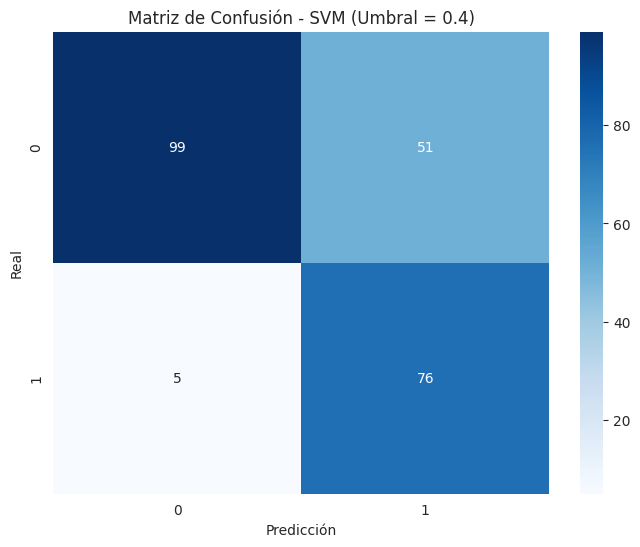

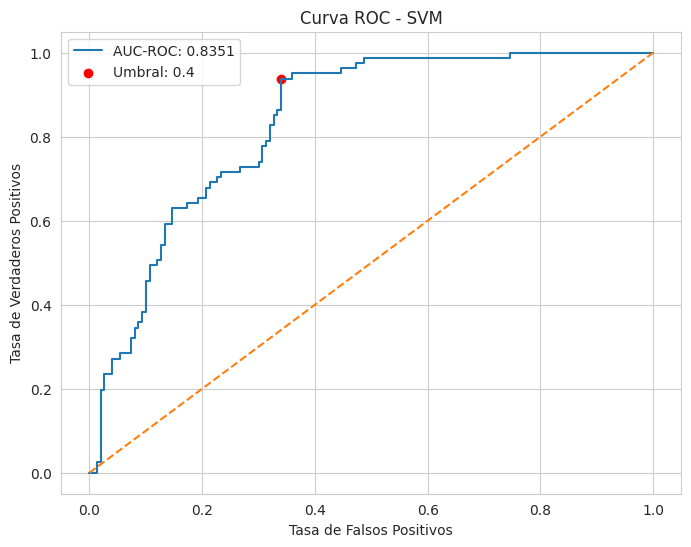

In [ ]:
# Preparación de los datos
X = df_imputed[selected_features]
y = df_imputed['Outcome']

# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)

# Configurar validación cruzada estratificada
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Crear el pipeline con Borderline-SMOTE y SVM
pipeline_svm = ImbPipeline([
    ('scaler', StandardScaler()),
    ('borderline_smote', BorderlineSMOTE(random_state=42)),
    ('classifier', SVC(C=0.01, kernel='linear', gamma='scale', probability=True, random_state=42))
])

# Realizar predicciones con validación cruzada
y_pred_prob_cv_svm = cross_val_predict(pipeline_svm, X_train, y_train, cv=cv, method='predict_proba')[:, 1]

# Ajustar el modelo en los datos de entrenamiento completos
pipeline_svm.fit(X_train, y_train)

# Predecir probabilidades en el conjunto de prueba
y_pred_prob_test_svm = pipeline_svm.predict_proba(X_test)[:, 1]

# Aplicar un umbral (cutoff) para predicciones finales en el conjunto de prueba
threshold = 0.4
y_pred_test_svm = (y_pred_prob_test_svm >= threshold).astype(int)

# Informe de clasificación con umbral 0.4
print(f"Informe de Clasificación para SVM con Umbral = {threshold}:")
print(classification_report(y_test, y_pred_test_svm))

# Matriz de confusión con umbral 0.4
cm_svm = confusion_matrix(y_test, y_pred_test_svm)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_svm, annot=True, fmt='d', cmap='Blues')
plt.title(f'Matriz de Confusión - SVM (Umbral = {threshold})')
plt.xlabel('Predicción')
plt.ylabel('Real')
plt.show()

# Curva ROC para SVM
fpr_svm, tpr_svm, thresholds_roc_svm = roc_curve(y_test, y_pred_prob_test_svm)
roc_auc_svm = roc_auc_score(y_test, y_pred_prob_test_svm)

plt.figure(figsize=(8, 6))
plt.plot(fpr_svm, tpr_svm,label=f'AUC-ROC: {roc_auc_svm:.4f}')
threshold_index_svm = np.argmin(np.abs(thresholds_roc_svm - threshold))
plt.scatter(fpr_svm[threshold_index_svm], tpr_svm[threshold_index_svm], color='red', label=f'Umbral: {threshold}')
plt.plot([0 ,1],[0 ,1],linestyle="--")
plt.xlabel('Tasa de Falsos Positivos')
plt.ylabel('Tasa de Verdaderos Positivos')
plt.title('Curva ROC - SVM')
plt.legend()
plt.show()



- El modelo individual de SVM es la mejor opción, ya que logra un recall significativamente más alto (94%) mientras mantiene un F1-score competitivo (73%) y una buena capacidad discriminativa según el AUC (0.8351).

- Si buscamos un equilibrio entre precisión y recall:
Regresión Logística es una alternativa sólida con un buen balance entre precisión (58%) y recall (**80%) y una exactitud razonable (**73%).

- Decisión Final:
Dado que el objetivo principal del proyecto es identificar correctamente pacientes con diabetes mientras mantenemos un buen equilibrio entre precisión y recall, continuaremos trabajando con el modelo individual de SVM, ya que ofrece el mejor desempeño general.

---

### **MODELO DE ELECCIÓN: SVM**

---

### **Rendimiento General del Modelo**
El modelo de SVM ha mostrado el mejor desempeño general en comparación con Regresión Logística, especialmente en términos de recall para la Clase Positiva (diabetes). A continuación detallamos las métricas clave y su interpretación:

---

### **1. Métricas Clave**
#### **AUC-ROC**:
- **SVM** tiene un AUC-ROC de **0.8351**, lo que indica una excelente capacidad discriminativa entre las clases.
- Este valor es superior al obtenido con Regresión Logística, lo que refuerza la elección de SVM como modelo final.

#### **Sensibilidad (Recall)**:
- El modelo de SVM tiene un recall notablemente alto para la Clase Positiva (**94%**), lo que significa que identifica correctamente la mayoría de los pacientes con diabetes.
- Este resultado es crucial en un contexto médico, donde es preferible minimizar los falsos negativos (pacientes no diagnosticados).

#### **Especificidad**:
- La especificidad para SVM es del **66%**, lo que significa que identifica correctamente una proporción razonable de pacientes sin diabetes.
- Sin embargo, el modelo tiende a producir más falsos positivos en comparación con Regresión Logística.

#### **F1-Score**:
- El F1-score para la Clase Positiva es del **73%**, lo que refleja un buen equilibrio entre precisión y recall.

#### **Precisión**:
- La precisión para la Clase Positiva es del **60%**, lo que indica que hay algunos falsos positivos, pero el modelo sigue siendo competitivo.

#### **Exactitud Global**:
- La exactitud global del modelo es del **76%**, mostrando un rendimiento sólido en general.

---

### **2. Análisis del Balance entre Especificidad y Sensibilidad**
#### Sensibilidad (Recall para Clase Positiva):
- El modelo identifica correctamente el **94%** de los casos positivos reales (pacientes con diabetes). Este resultado es altamente favorable en un contexto médico, donde es crucial no pasar por alto casos positivos.

#### Especificidad:
- El modelo identifica correctamente el **66%** de los casos negativos reales (pacientes sin diabetes). Esto confirma una ligera tendencia del modelo a producir falsos positivos, lo cual puede ser aceptable si priorizamos minimizar los falsos negativos.

#### Balance:
El balance entre sensibilidad y especificidad muestra un sesgo hacia la detección de casos positivos, lo cual es apropiado en este proyecto donde se prefieren falsos positivos a falsos negativos.

---

### **3. Interpretación del F1-score en el Contexto de Clases Desbalanceadas**
El F1-score para la Clase Positiva es del **73%**, reflejando un buen equilibrio entre precisión (**60%**) y recall (**94%**) para esta clase. Esto indica que el modelo maneja bien el desbalance de clases y prioriza correctamente la detección de pacientes con diabetes.

---

### **4. Análisis por Clases**
#### Clase 0 (Sin Diabetes):
- Alta precisión (**95%**) pero recall moderado (**66%**), resultando en un F1-score de **78%**.
  
#### Clase 1 (Con Diabetes):
- Moderada precisión (**60%**) pero excelente recall (**94%**), resultando en un F1-score de **73%**.

Estos resultados confirman que el modelo está optimizado para detectar casos positivos, sacrificando algo de precisión en la Clase Negativa.

---

### **5. Comparación con Regresión Logística**
| Métrica                | Regresión Logística | SVM       |
|------------------------|---------------------|-----------|
| AUC-ROC               | 0.8314                 | 0.8351    |
| Precisión (Clase 1)    | 58%                 | 60%       |
| Recall (Clase 1)       | 80%                 | 94%       |
| F1-score (Clase 1)     | 67%                 | 73%       |
| Exactitud Global       | 73%                 | 76%       |

El modelo de SVM supera a Regresión Logística en todas las métricas clave relacionadas con la detección de pacientes con diabetes.

---

### **6. Evaluación Final**
El modelo muestra un rendimiento sólido, especialmente en términos de sensibilidad para la Clase Positiva. Esto lo convierte en una opción ideal para este proyecto, donde es crucial identificar correctamente a los pacientes con diabetes. Aunque produce más falsos positivos, este sesgo es aceptable dado el contexto médico.

---

### **7. Sugerencias para Mejorar el Modelo**
1. **Ajustes Adicionales del Cutoff**:
   - Experimentar con valores intermedios entre 0.4 y 0.5 para optimizar aún más el balance entre sensibilidad y especificidad.

2. **Calibración de Probabilidades**:
   - Utilizar `CalibratedClassifierCV` para ajustar las probabilidades predichas y mejorar la interpretación del cutoff.

3. **Explorar Modelos No Lineales**:
   - Probar SVM con kernel RBF o modelos como Gradient Boosting si se sospecha que las relaciones entre las características son no lineales.

4. **Validación Cruzada Repetida**:
   - Implementar validación cruzada repetida para confirmar la estabilidad del rendimiento del modelo.

5. **Ingeniería de Características**:
   - Considerar agregar nuevas características relevantes o realizar transformaciones adicionales sobre las existentes.

---

En resumen, el modelo final seleccionado es **SVM**, ya que ofrece el mejor desempeño general y cumple con los objetivos principales del proyecto: maximizar el recall para identificar correctamente pacientes con diabetes mientras mantiene un buen equilibrio entre precisión y especificidad.



Dado que este proyecto tiene como objetivo principal identificar correctamente pacientes con diabetes, priorizaremos el recall para minimizar los falsos negativos.

Por lo tanto, seleccionamos cutoff = 0.40, ya que maximiza el recall y mantiene un buen equilibrio entre las métricas clave.